In [43]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify
import numpy as np
import cv2
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.models import load_model
import os



In [44]:


# Path to the directory containing images
image_dir = r"D:\Holland_Year_2\Block_B\2024-25b-fai2-adsai-PetarPaskalev232725\datalab_tasks\Task8\Kaggle"

# Loop through all image files in the directory
processed_images = []
for filename in os.listdir(image_dir):
    if filename.endswith(('.png', '.jpg', '.jpeg', '.tif')):  # Add other formats if needed
        image_path = os.path.join(image_dir, filename)
        
        # Load the image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Skipping {filename} - could not load image.")
            continue
        
        # Convert to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Resize the image if necessary
        target_size = (256, 256)  # Define desired size
        resized_image = cv2.resize(gray_image, target_size, interpolation=cv2.INTER_AREA)
        
        # Normalize pixel values
        normalized_image = resized_image / 255.0
        
        # Patchify the image
        patch_size = 256  # Example patch size
        step_size = 256   # Example step size
        patches = patchify(normalized_image, (patch_size, patch_size), step=step_size)
        
        # Store patches for later use or processing
        processed_images.append((filename, patches))

        # Optional: Print progress
        print(f"Processed {filename} - Patches shape: {patches.shape}")

# Check the number of processed images
print(f"Total processed images: {len(processed_images)}")


Processed test_image_1.png - Patches shape: (1, 1, 256, 256)
Processed test_image_10.png - Patches shape: (1, 1, 256, 256)
Processed test_image_11.png - Patches shape: (1, 1, 256, 256)
Processed test_image_12.png - Patches shape: (1, 1, 256, 256)
Processed test_image_13.png - Patches shape: (1, 1, 256, 256)
Processed test_image_14.png - Patches shape: (1, 1, 256, 256)
Processed test_image_15.png - Patches shape: (1, 1, 256, 256)
Processed test_image_16.png - Patches shape: (1, 1, 256, 256)
Processed test_image_17.png - Patches shape: (1, 1, 256, 256)
Processed test_image_18.png - Patches shape: (1, 1, 256, 256)
Processed test_image_2.png - Patches shape: (1, 1, 256, 256)
Processed test_image_3.png - Patches shape: (1, 1, 256, 256)
Processed test_image_4.png - Patches shape: (1, 1, 256, 256)
Processed test_image_5.png - Patches shape: (1, 1, 256, 256)
Processed test_image_6.png - Patches shape: (1, 1, 256, 256)
Processed test_image_7.png - Patches shape: (1, 1, 256, 256)
Processed test_

In [45]:


# **Load and preprocess all images in the dataset**
def load_images_from_directory(directory_path):
    """
    Load all images from a directory in grayscale mode.
    """
    images = []
    filenames = []
    for filename in os.listdir(directory_path):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.tif')):  # Supported formats
            image_path = os.path.join(directory_path, filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                images.append(image)
                filenames.append(filename)
            else:
                print(f"Failed to load {filename}")
    return images, filenames

# **Detect edges to find the Petri dish**
def detect_edges(image, max_size=2800):
    """
    Detect edges and find the approximate square Petri dish.
    """
    blurred_image = cv2.GaussianBlur(image, (51, 51), 0)
    sobel_x = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=5)
    gradient_magnitude = cv2.magnitude(sobel_x, sobel_y)
    _, edges = cv2.threshold(gradient_magnitude, 50, 255, cv2.THRESH_BINARY)
    edges = edges.astype(np.uint8)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(max_contour)

    side_length = min(max(w, h), max_size)
    center_x, center_y = x + w // 2, y + h // 2
    half_side = side_length // 2
    new_x = max(center_x - half_side, 0)
    new_y = max(center_y - half_side, 0)
    new_w = new_h = min(side_length, min(image.shape[1] - new_x, image.shape[0] - new_y))
    return new_x, new_x + new_w, new_y, new_y + new_h

# **Crop the image based on detected edges**
def crop_image(image, edges, max_size=2800):
    """
    Crop the image based on detected edges and resize if necessary.
    """
    left, right, top, bottom = edges
    cropped = image[top:bottom, left:right]
    if cropped.shape[1] > max_size or cropped.shape[0] > max_size:
        cropped = cv2.resize(cropped, (min(cropped.shape[1], max_size), min(cropped.shape[0], max_size)))
    return cropped

# **Pad the image to make dimensions divisible by the patch size**
def padder(image, patch_size):
    """
    Add padding to make dimensions divisible by the patch size.
    """
    h, w = image.shape[:2]
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w
    top_padding = int(height_padding / 2)
    bottom_padding = height_padding - top_padding
    left_padding = int(width_padding / 2)
    right_padding = width_padding - left_padding
    padded_image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=0)
    return padded_image

# **Patchify and normalize the image**
def preprocess_image(image, patch_size=256):
    """
    Preprocess the image: pad, patchify, and normalize.
    """
    patches = patchify(image, (patch_size, patch_size), step=patch_size)
    patches_reshaped = patches.reshape(-1, patch_size, patch_size, 1)  # Add channel dimension
    patches_normalized = patches_reshaped / 255.0
    return patches, patches_normalized

# **Run the preprocessing pipeline**
image_dir = r"D:\Holland_Year_2\Block_B\2024-25b-fai2-adsai-PetarPaskalev232725\datalab_tasks\Task8\Kaggle"

# Load all images from the directory
images, filenames = load_images_from_directory(image_dir)

# Preprocess each image
preprocessed_data = []
patch_size = 256
for image, filename in zip(images, filenames):
    edges = detect_edges(image)
    cropped_image = crop_image(image, edges)
    petri_dish_padded = padder(cropped_image, patch_size)
    patches, patches_normalized = preprocess_image(petri_dish_padded, patch_size)
    preprocessed_data.append((filename, patches_normalized))

    # Print progress
    print(f"Processed {filename}: Original shape {image.shape}, Padded shape {petri_dish_padded.shape}, Patches {patches.shape}")

# Verify results
print(f"Total images processed: {len(preprocessed_data)}")


Processed test_image_1.png: Original shape (3006, 4112), Padded shape (2816, 2816), Patches (11, 11, 256, 256)
Processed test_image_10.png: Original shape (3006, 4202), Padded shape (2816, 2816), Patches (11, 11, 256, 256)
Processed test_image_11.png: Original shape (3006, 4202), Padded shape (2816, 2816), Patches (11, 11, 256, 256)
Processed test_image_12.png: Original shape (3006, 4202), Padded shape (2816, 2816), Patches (11, 11, 256, 256)
Processed test_image_13.png: Original shape (2999, 4202), Padded shape (2816, 2816), Patches (11, 11, 256, 256)
Processed test_image_14.png: Original shape (3006, 4202), Padded shape (2816, 2816), Patches (11, 11, 256, 256)
Processed test_image_15.png: Original shape (3006, 4202), Padded shape (2816, 2816), Patches (11, 11, 256, 256)
Processed test_image_16.png: Original shape (3006, 4202), Padded shape (2816, 2816), Patches (11, 11, 256, 256)
Processed test_image_17.png: Original shape (3006, 4202), Padded shape (2816, 2816), Patches (11, 11, 256

In [46]:
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

8/8 [==============================] - 2s 161ms/step
Prediction completed for test_image_1.png
8/8 [==============================] - 1s 173ms/step
Prediction completed for test_image_10.png
8/8 [==============================] - 1s 159ms/step
Prediction completed for test_image_11.png
8/8 [==============================] - 1s 88ms/step
Prediction completed for test_image_12.png
8/8 [==============================] - 1s 148ms/step
Prediction completed for test_image_13.png
8/8 [==============================] - 1s 185ms/step
Prediction completed for test_image_14.png
8/8 [==============================] - 1s 150ms/step
Prediction completed for test_image_15.png
8/8 [==============================] - 1s 160ms/step
Prediction completed for test_image_16.png
8/8 [==============================] - 1s 114ms/step
Prediction completed for test_image_17.png
8/8 [==============================] - 2s 329ms/step
Prediction completed for test_image_18.png
8/8 [==============================] - 2s 

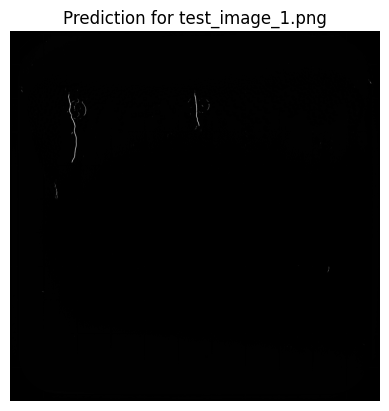

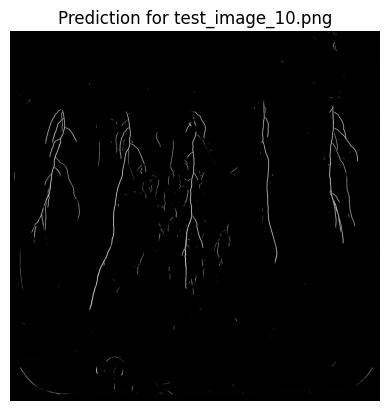

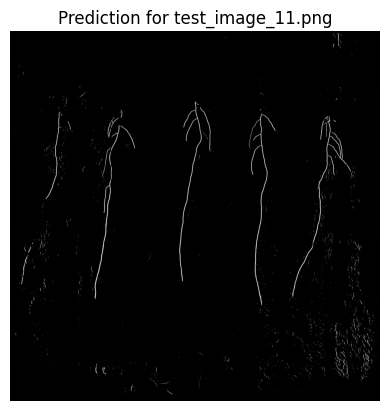

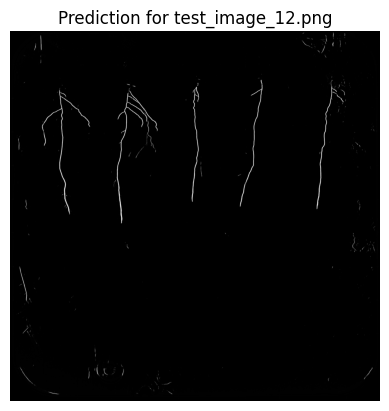

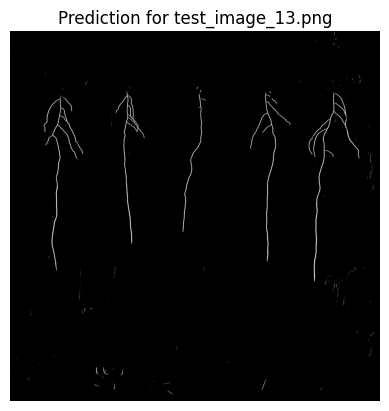

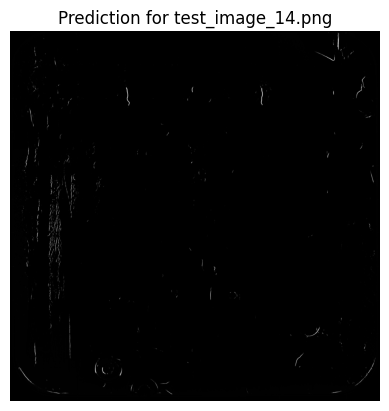

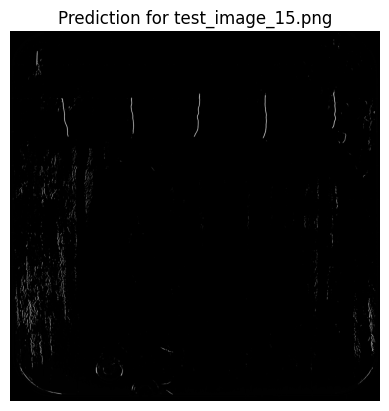

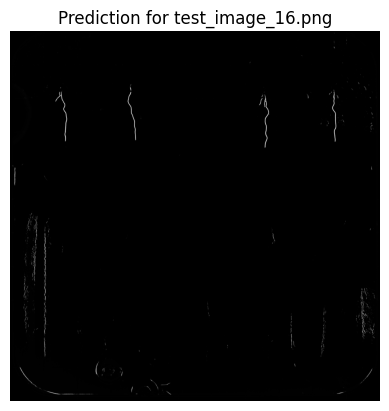

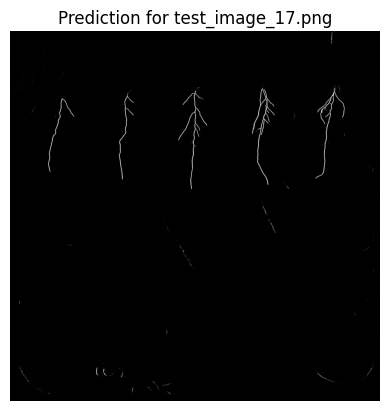

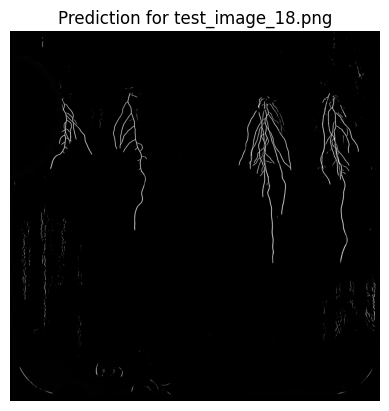

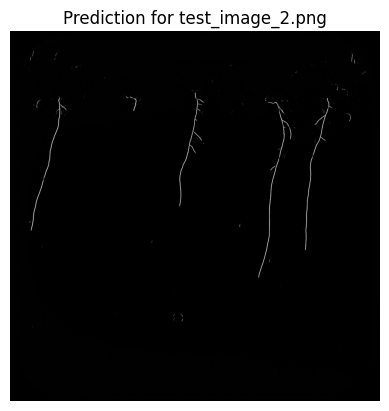

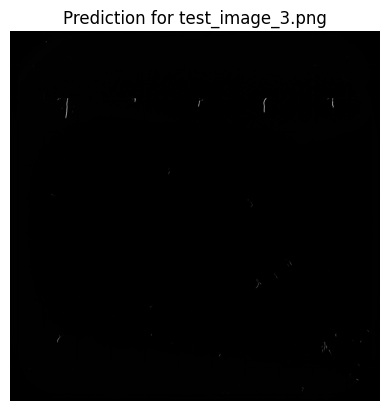

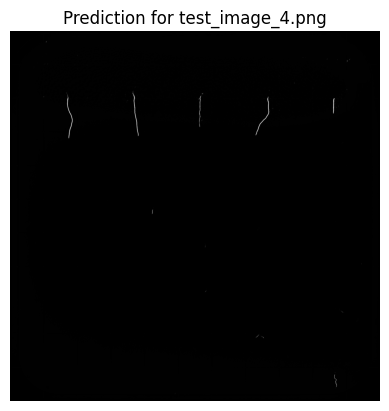

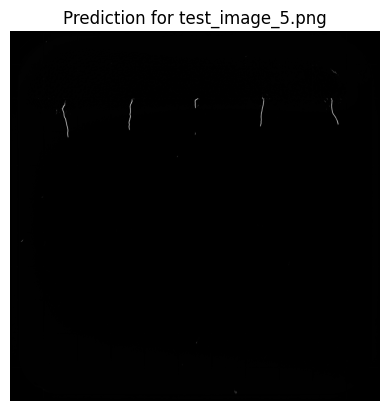

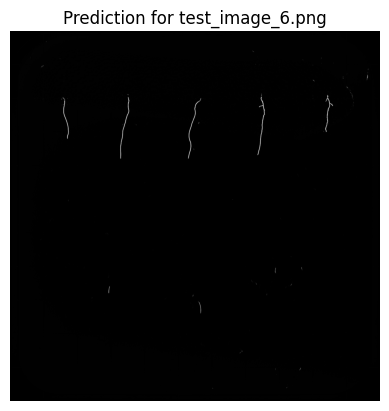

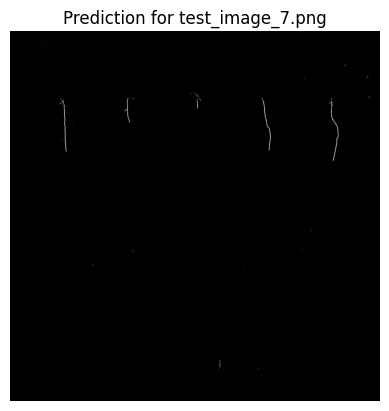

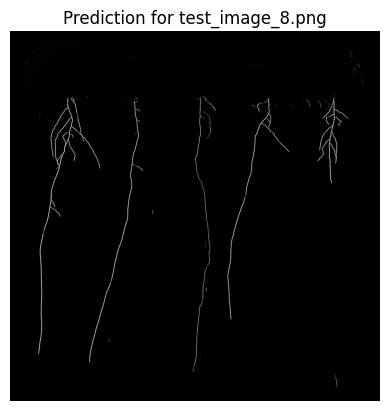

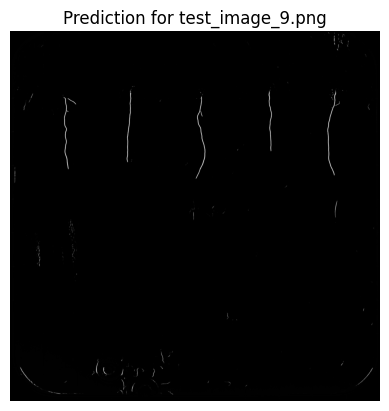

In [47]:


# **Load the model**
model_path = "PetarPaskalev_232725_unet_model_2_256px_80F1.h5"
model = load_model(model_path, custom_objects={"f1": f1})

# **Run predictions**
predictions = []
for filename, patches_normalized in preprocessed_data:
    # Predict on patches
    predicted_patches = model.predict(patches_normalized, batch_size=16)
    
    # Reshape predictions back to original patch grid
    num_patches = int(np.sqrt(predicted_patches.shape[0]))  # Assuming square grid
    predicted_patches = predicted_patches.reshape(num_patches, num_patches, patch_size, patch_size)
    
    # Reconstruct the full image using unpatchify
    petri_dish_padded_shape = (patch_size * num_patches, patch_size * num_patches)
    reconstructed_prediction = unpatchify(predicted_patches, petri_dish_padded_shape)
    
    # Store the prediction
    predictions.append((filename, reconstructed_prediction))
    print(f"Prediction completed for {filename}")

# **Visualize predictions**
for filename, predicted_mask in predictions:
    plt.figure(dpi=100)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title(f"Prediction for {filename}")
    plt.axis('off')
    plt.show()


In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Loop through predictions and convert each mask to binary
binary_predictions = []
for filename, predicted_mask in predictions:
    # Convert predicted mask to binary: thresholding at 0.5
    binary_mask = (predicted_mask > 0.5).astype(np.uint8) * 255
    
    # Store the binary mask
    binary_predictions.append((filename, binary_mask))

 

  


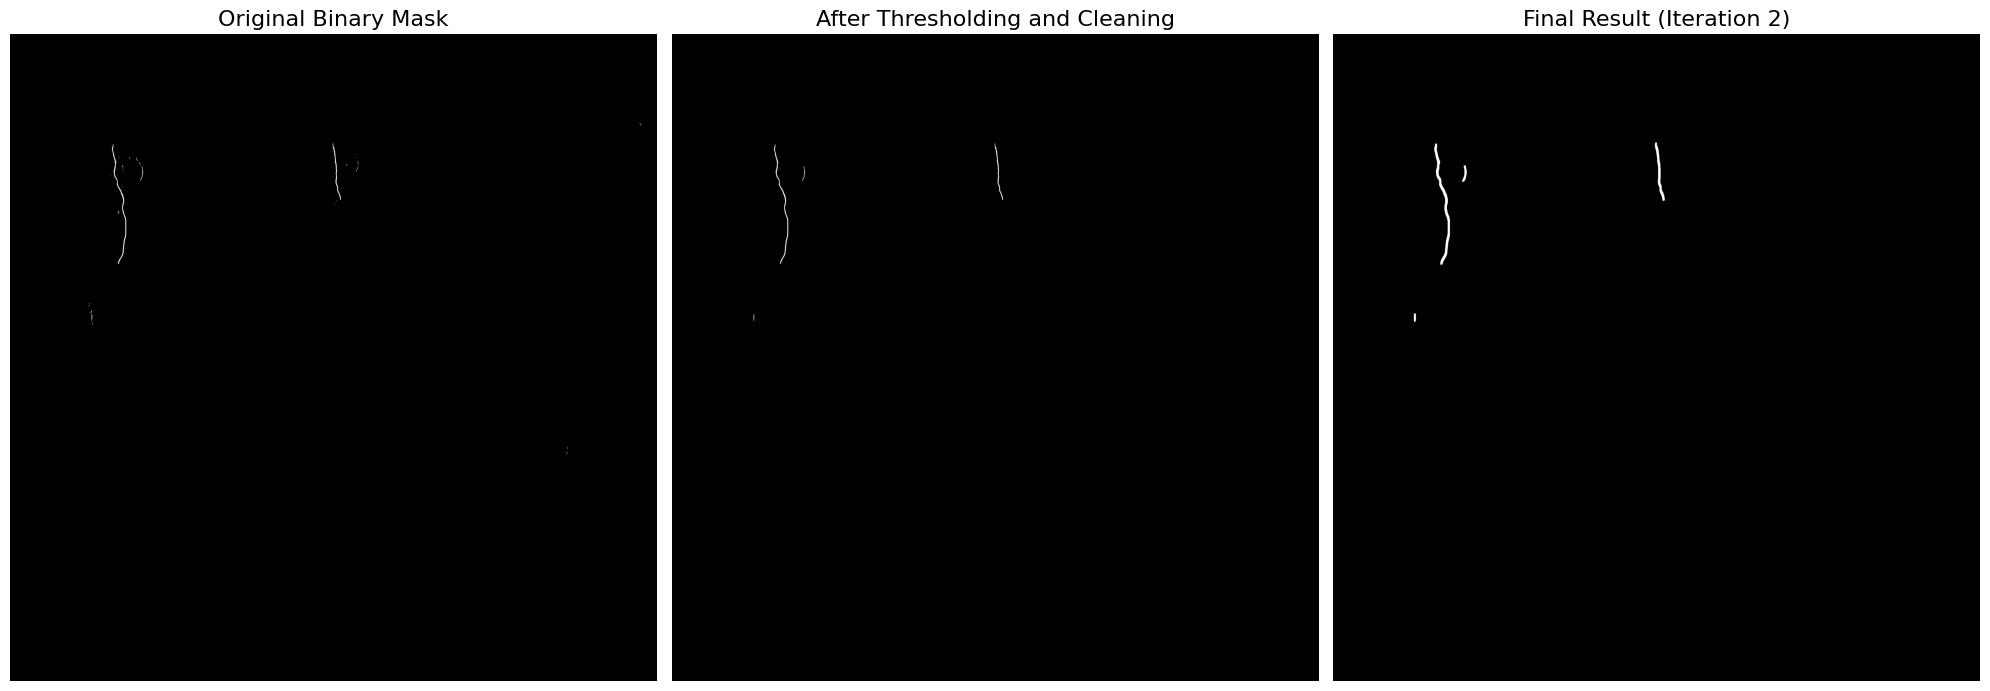

Processed test_image_1.png with Kernel Size = 7, Total Iterations = 2: Threshold = 0.5, Min Object Size = 50


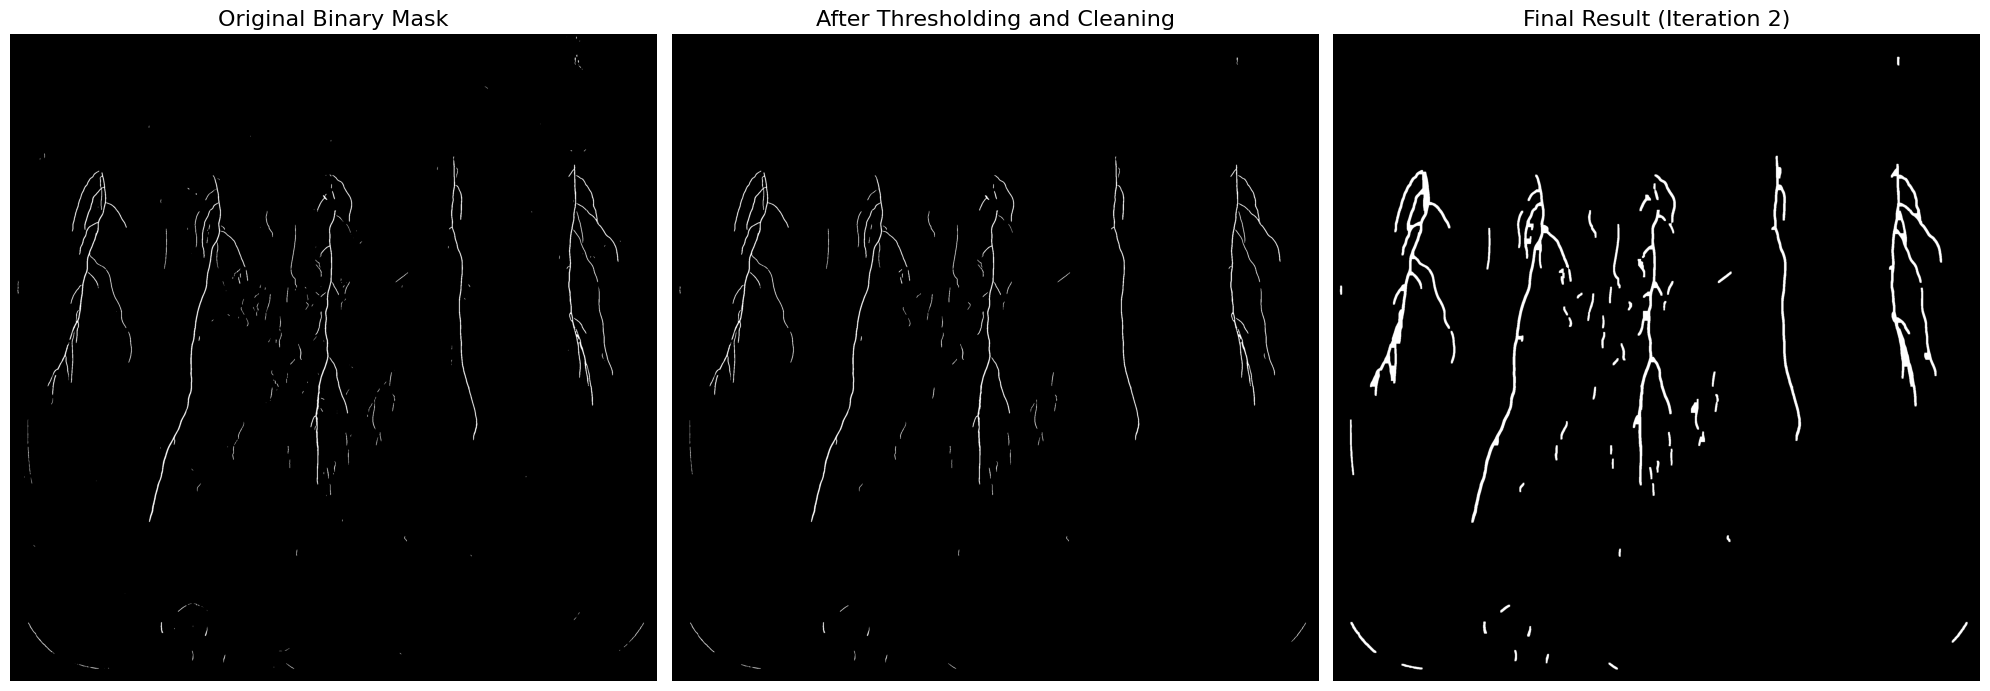

Processed test_image_10.png with Kernel Size = 7, Total Iterations = 2: Threshold = 0.5, Min Object Size = 50


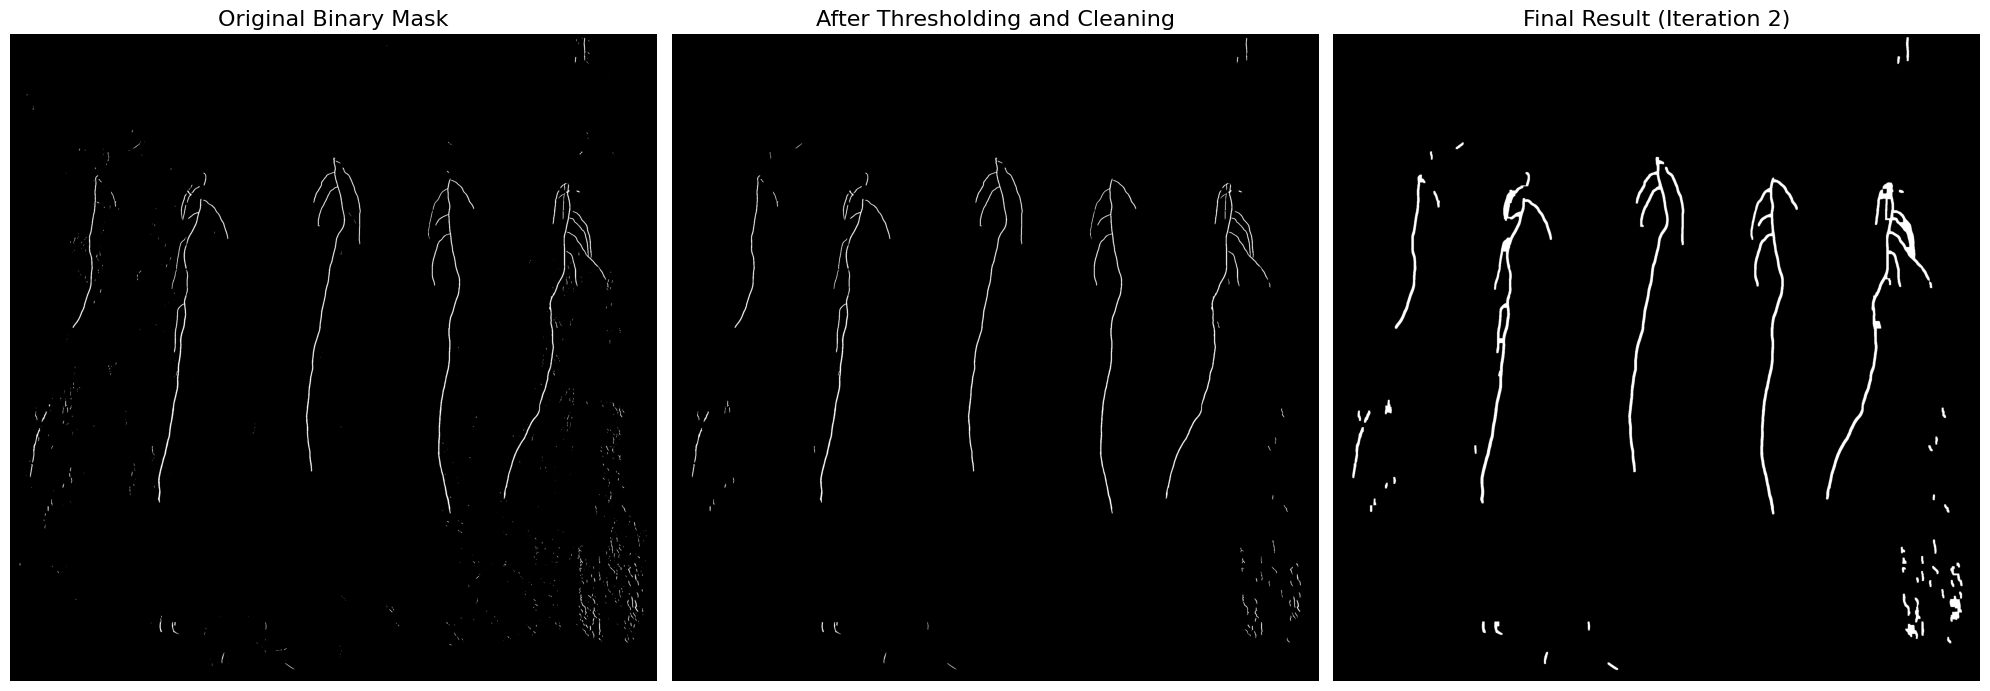

Processed test_image_11.png with Kernel Size = 7, Total Iterations = 2: Threshold = 0.5, Min Object Size = 50


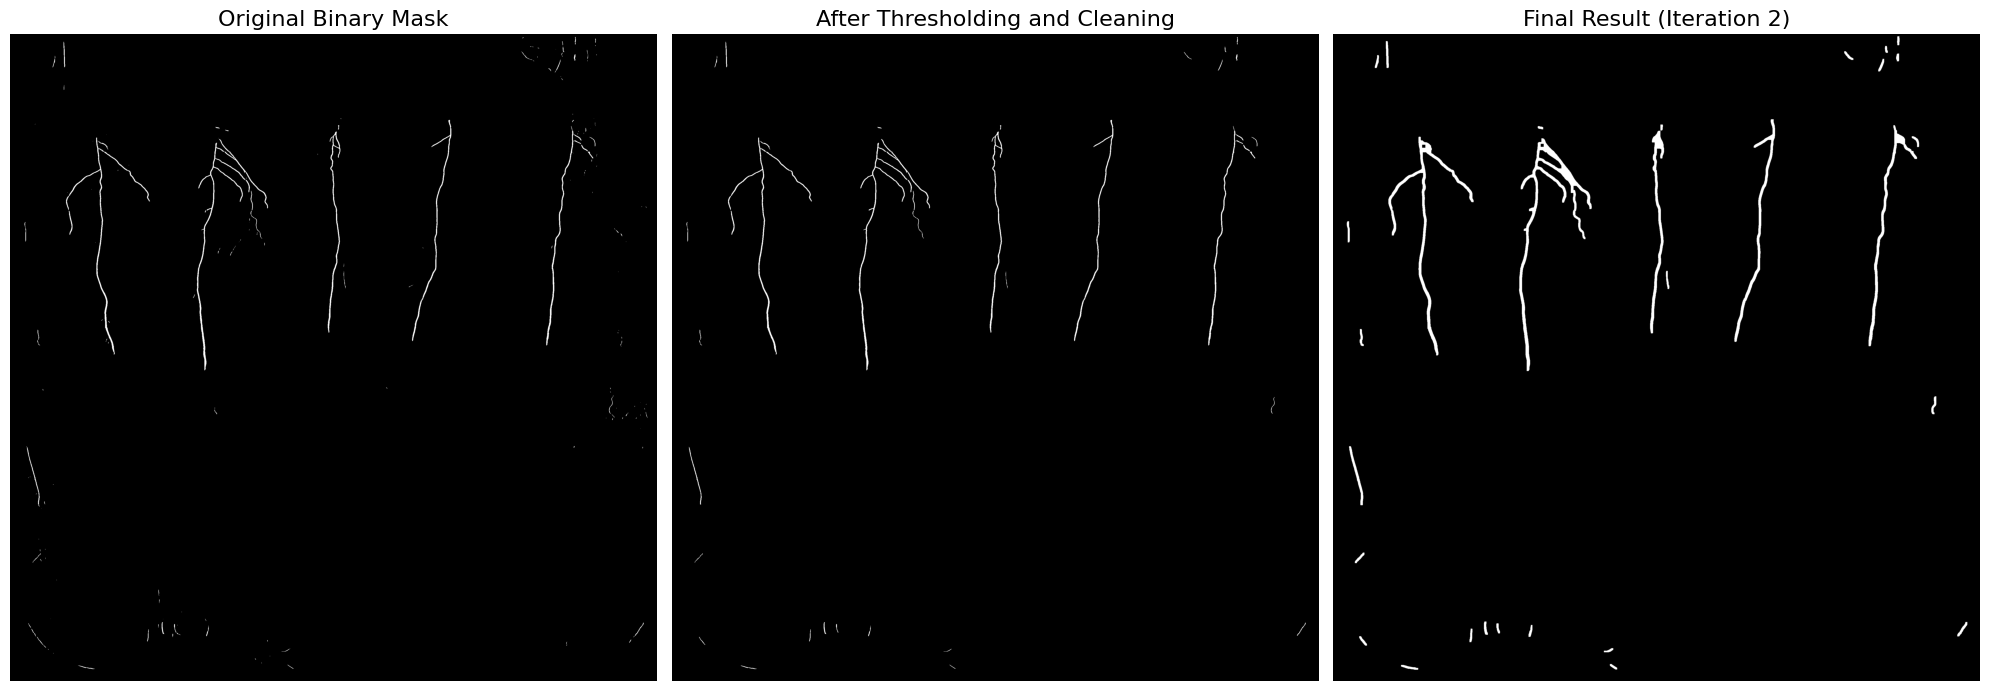

Processed test_image_12.png with Kernel Size = 7, Total Iterations = 2: Threshold = 0.5, Min Object Size = 50


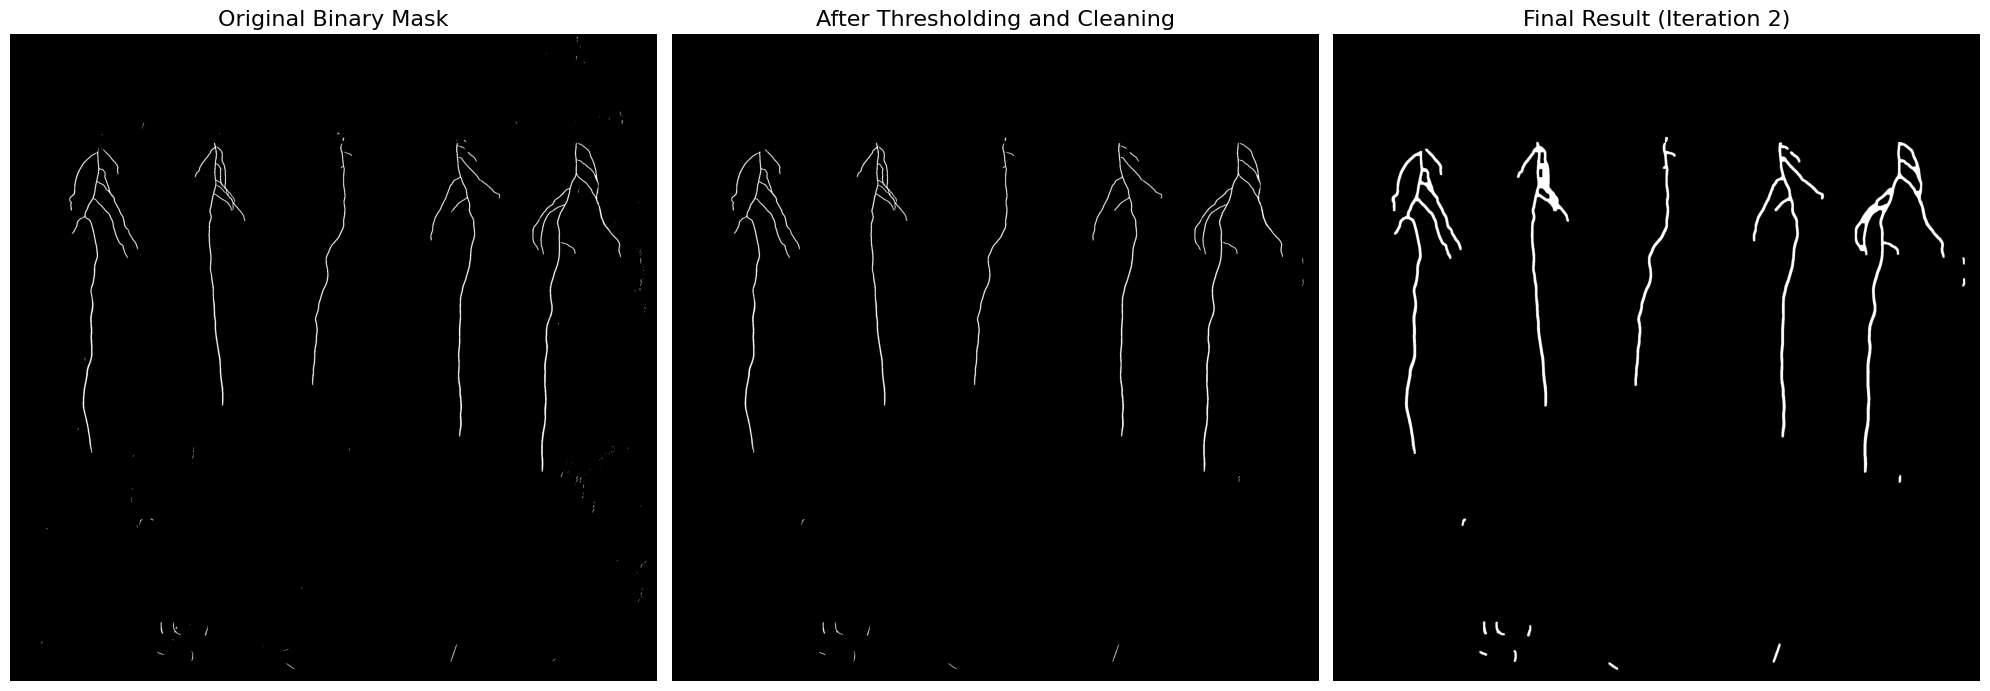

Processed test_image_13.png with Kernel Size = 7, Total Iterations = 2: Threshold = 0.5, Min Object Size = 50


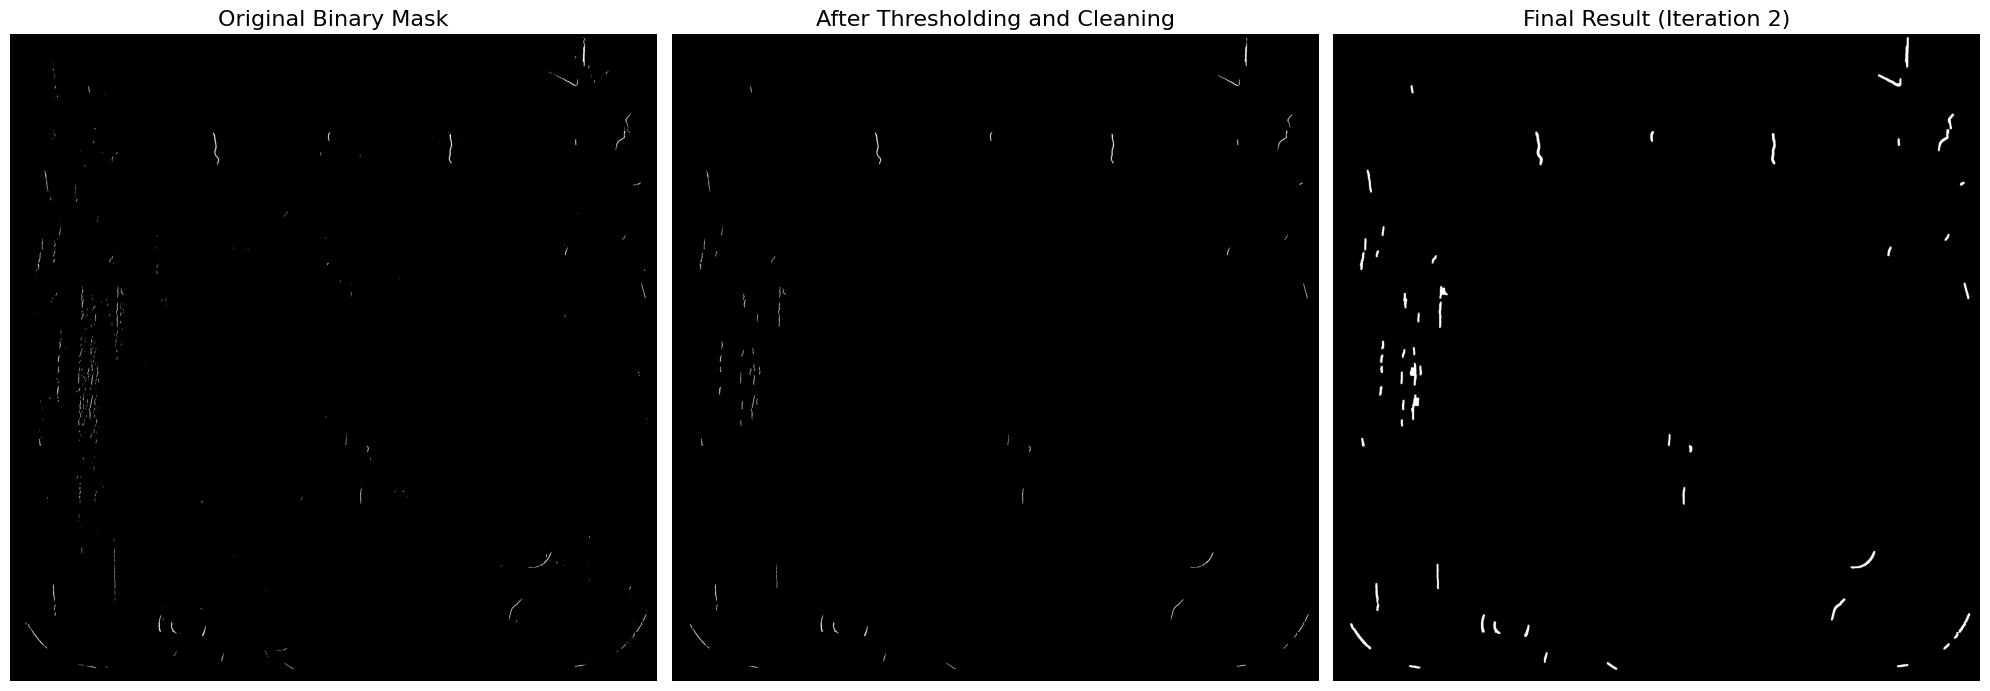

Processed test_image_14.png with Kernel Size = 7, Total Iterations = 2: Threshold = 0.5, Min Object Size = 50


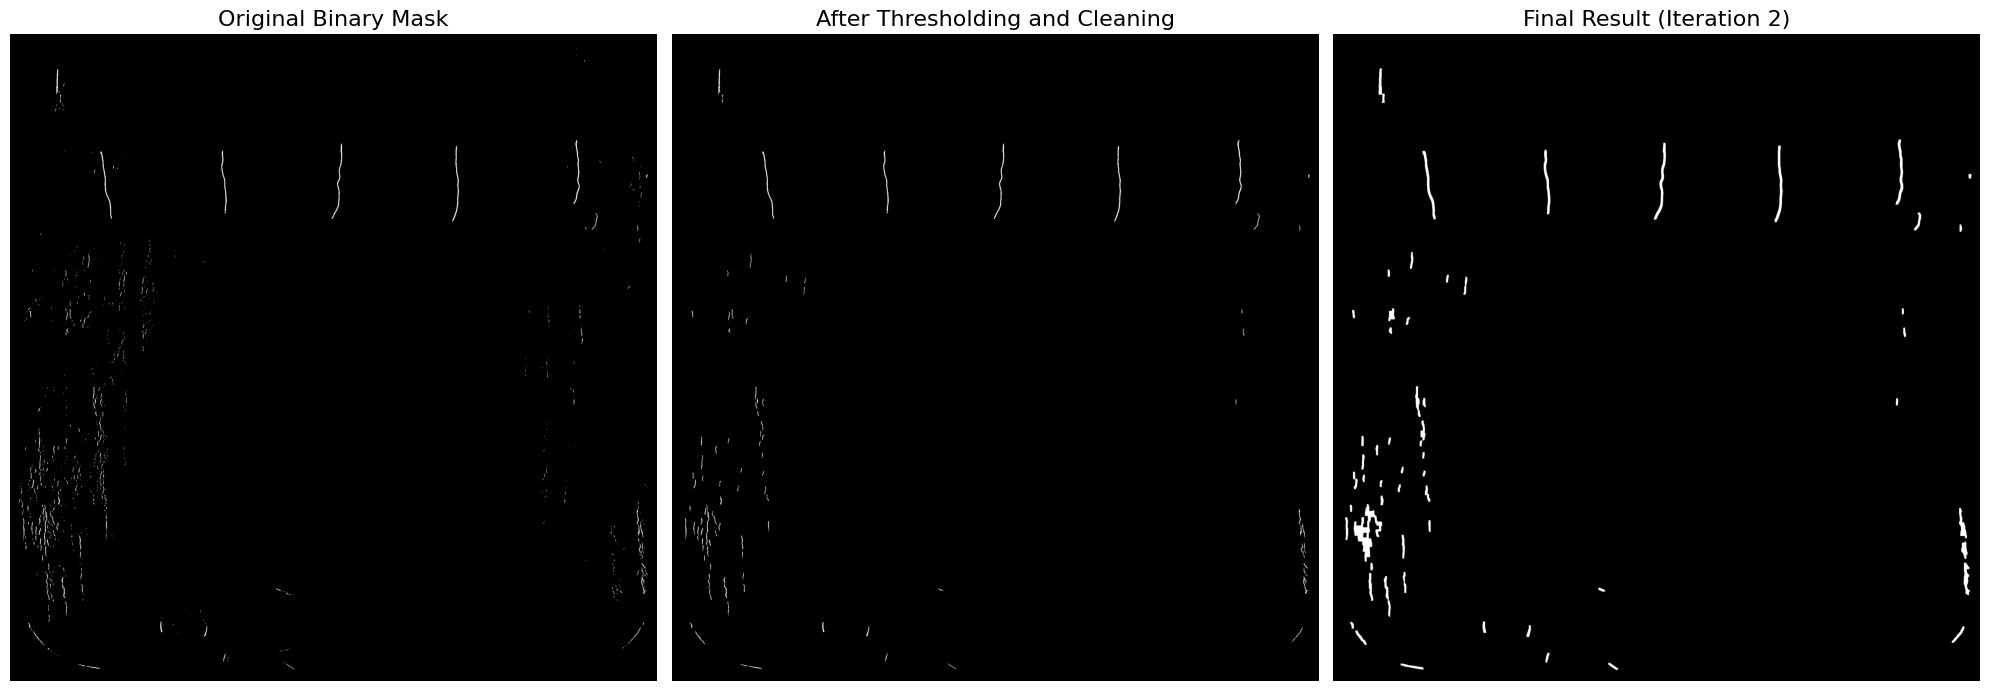

Processed test_image_15.png with Kernel Size = 7, Total Iterations = 2: Threshold = 0.5, Min Object Size = 50


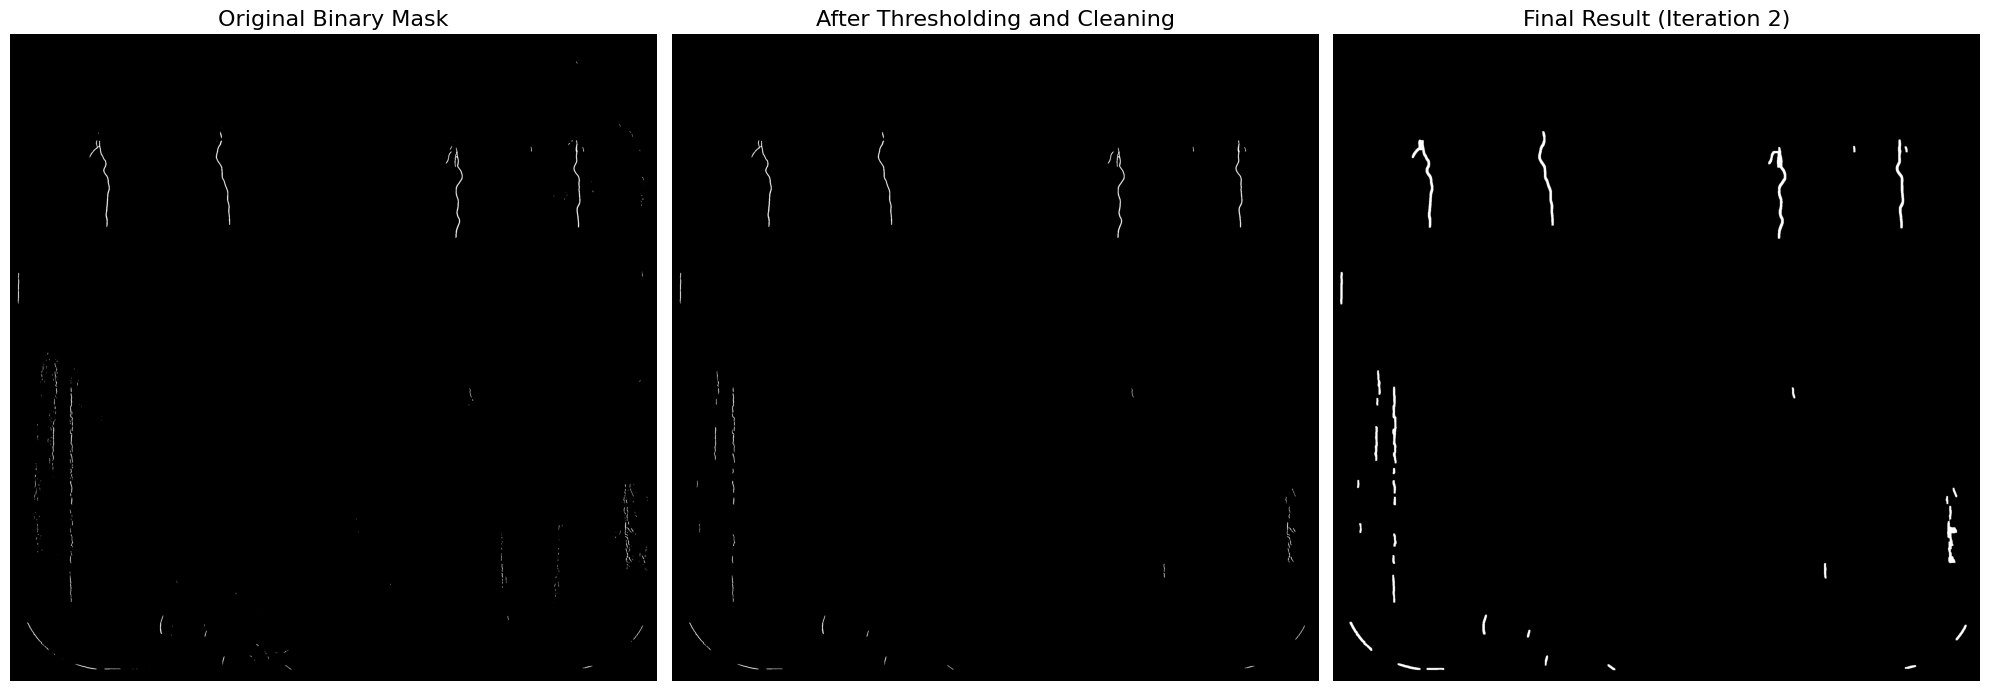

Processed test_image_16.png with Kernel Size = 7, Total Iterations = 2: Threshold = 0.5, Min Object Size = 50


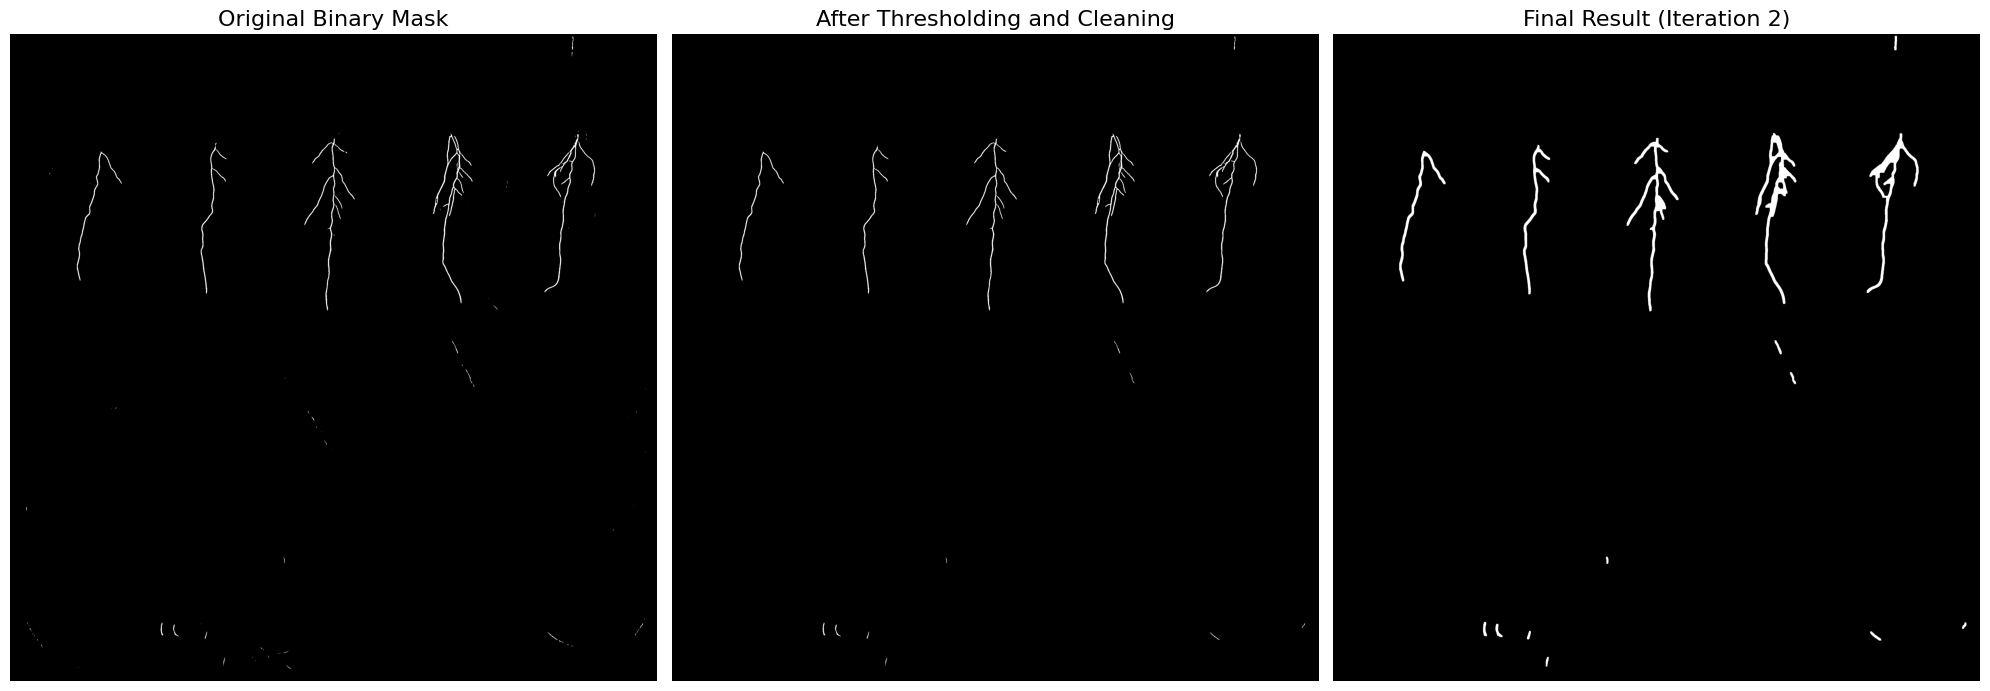

Processed test_image_17.png with Kernel Size = 7, Total Iterations = 2: Threshold = 0.5, Min Object Size = 50


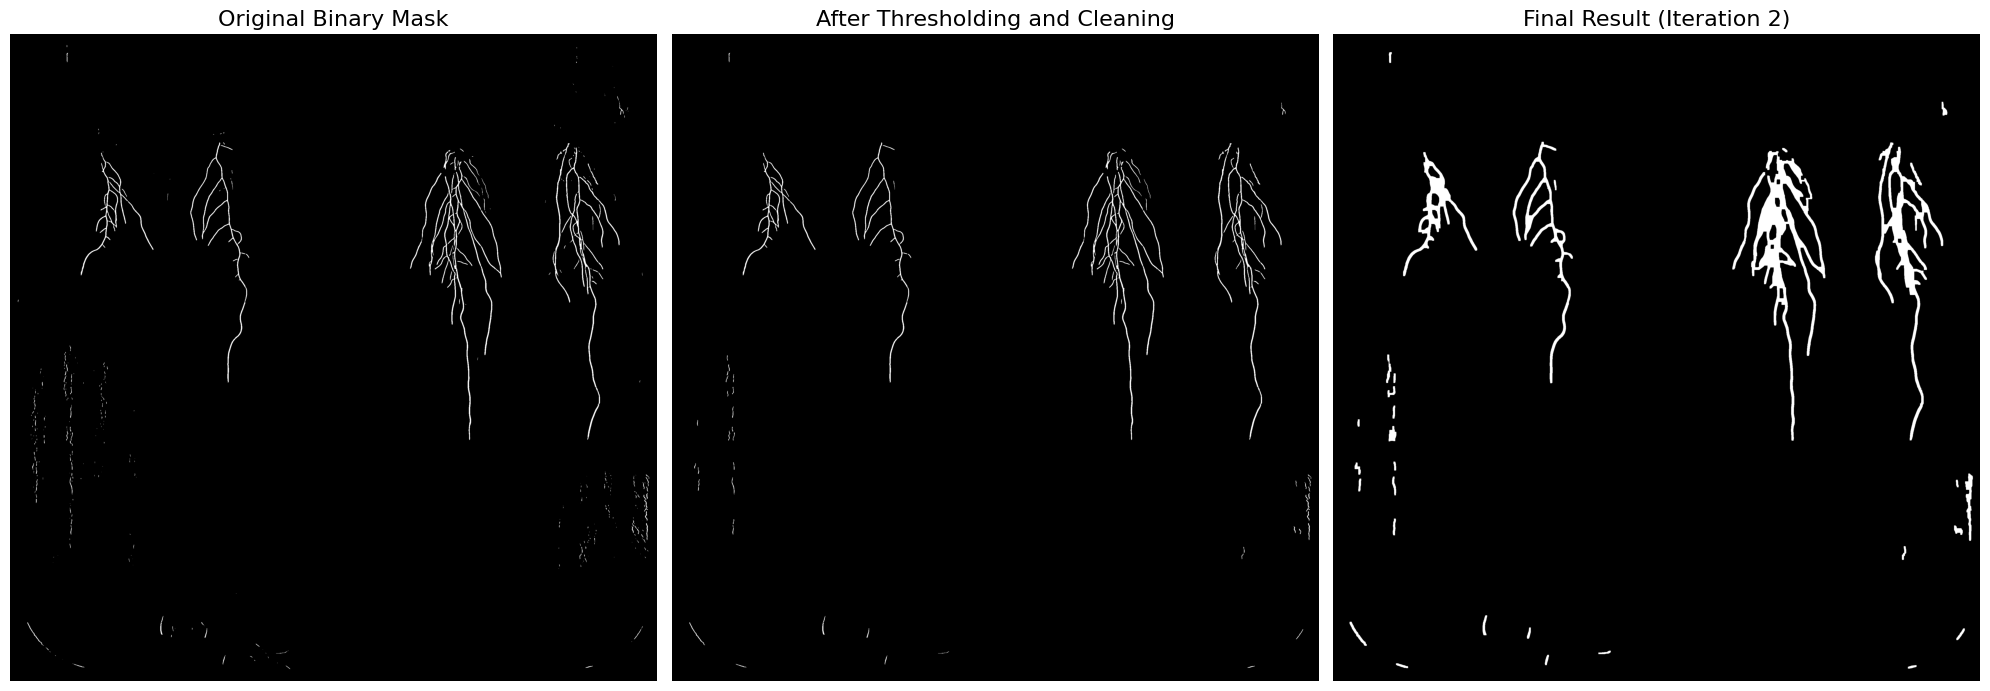

Processed test_image_18.png with Kernel Size = 7, Total Iterations = 2: Threshold = 0.5, Min Object Size = 50


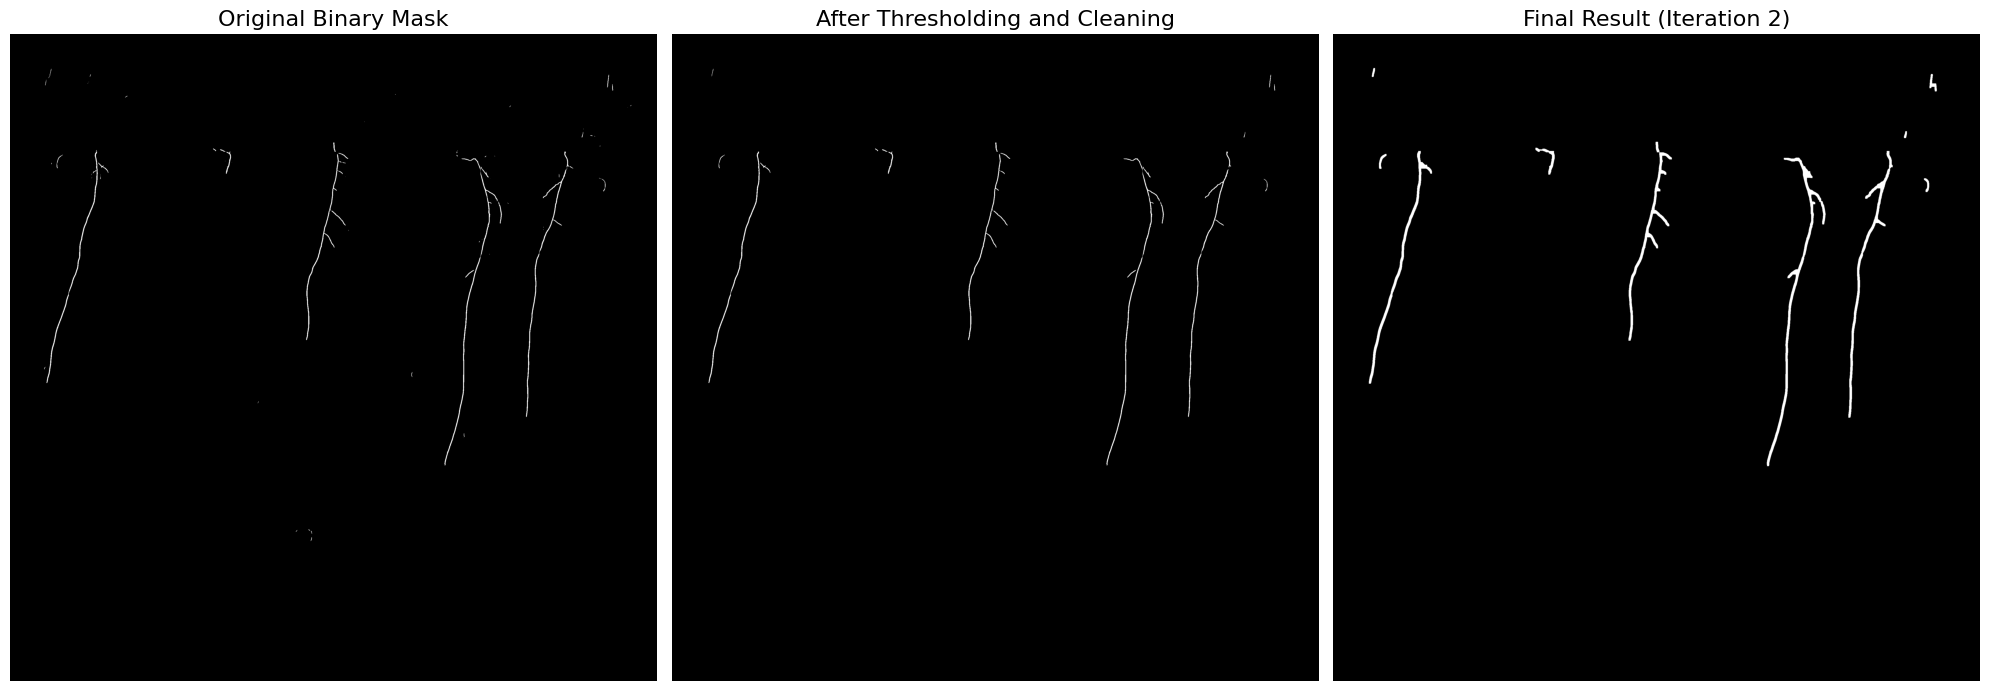

Processed test_image_2.png with Kernel Size = 7, Total Iterations = 2: Threshold = 0.5, Min Object Size = 50


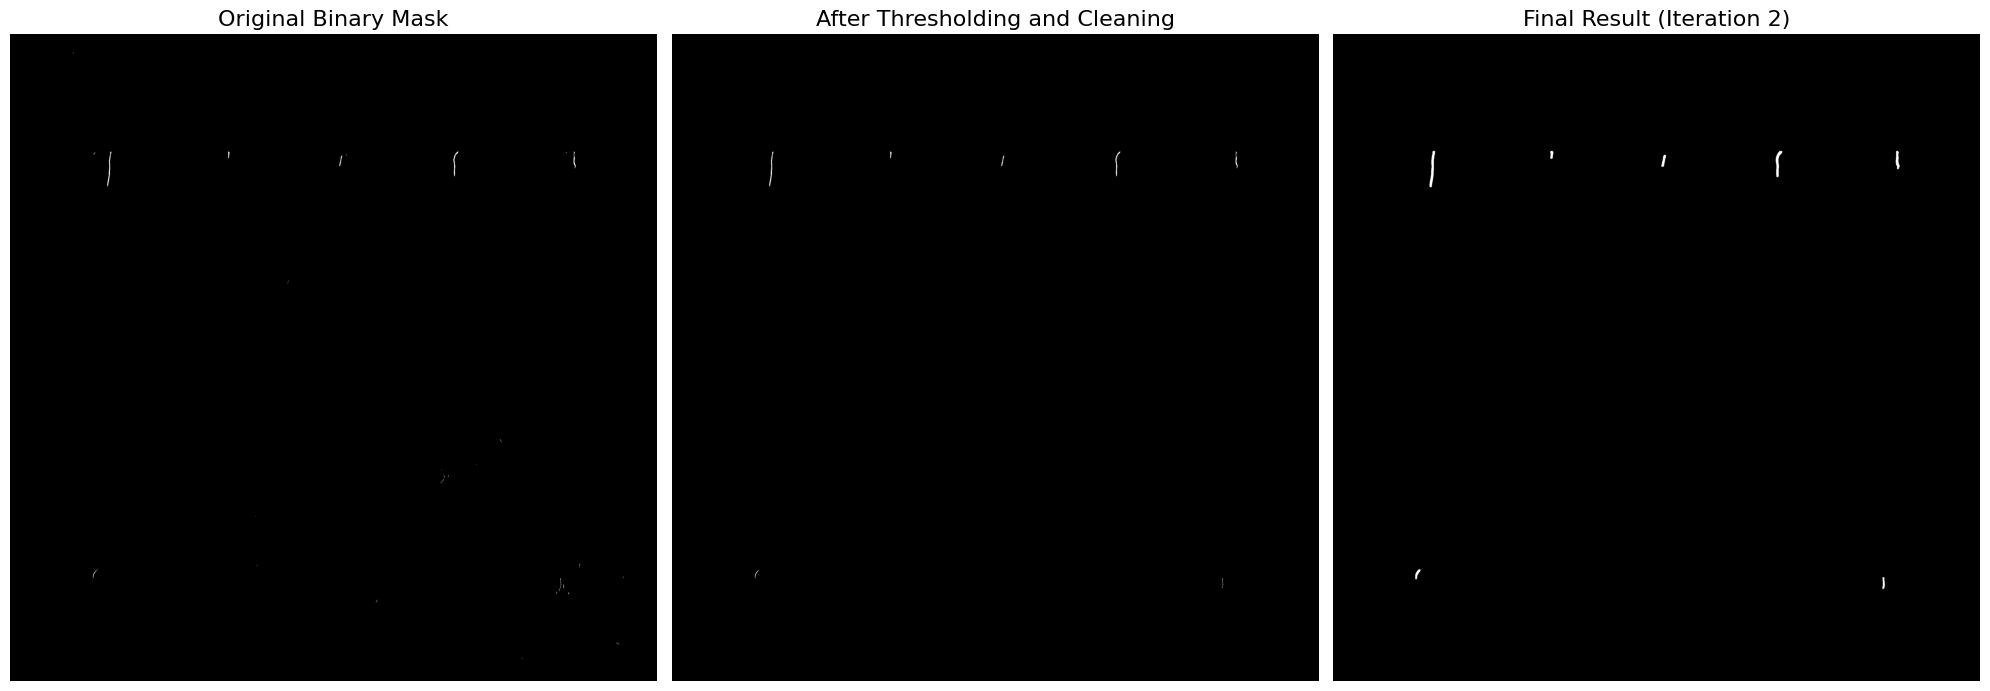

Processed test_image_3.png with Kernel Size = 7, Total Iterations = 2: Threshold = 0.5, Min Object Size = 50


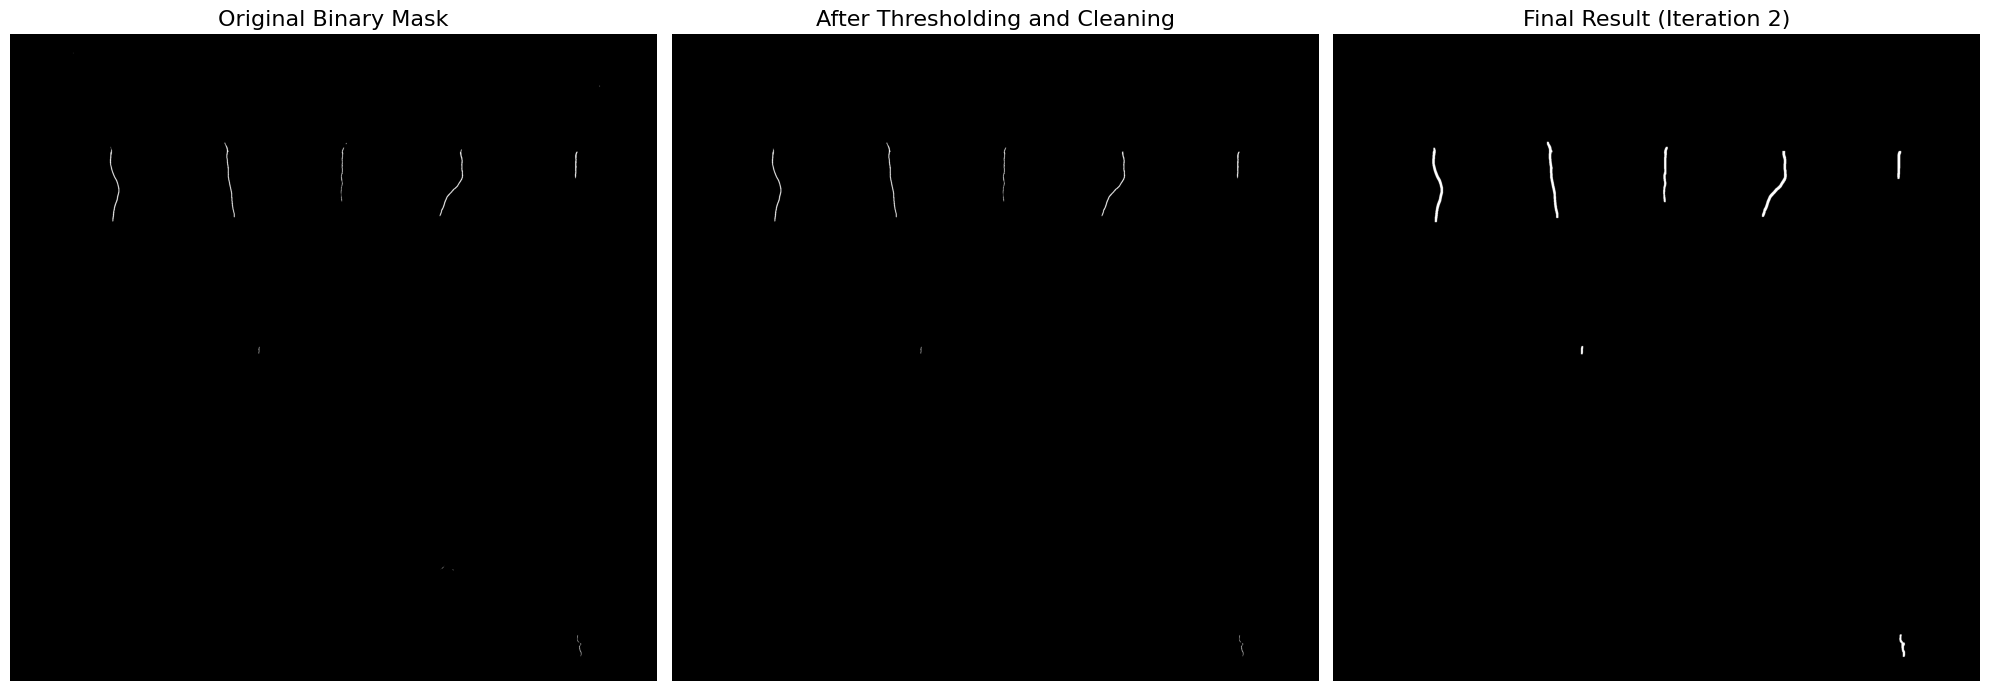

Processed test_image_4.png with Kernel Size = 7, Total Iterations = 2: Threshold = 0.5, Min Object Size = 50


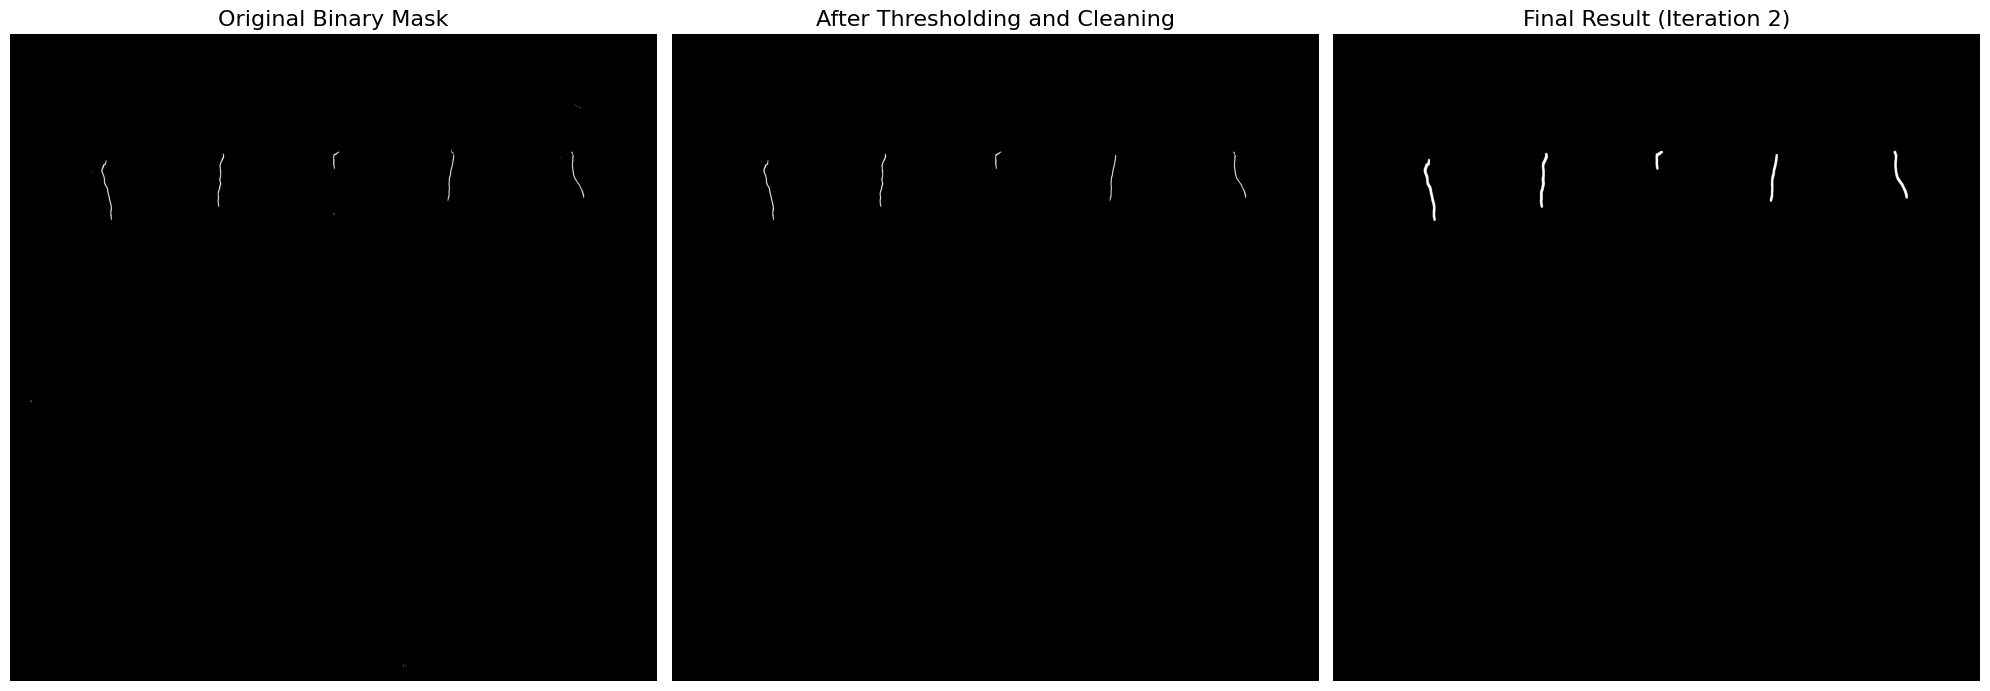

Processed test_image_5.png with Kernel Size = 7, Total Iterations = 2: Threshold = 0.5, Min Object Size = 50


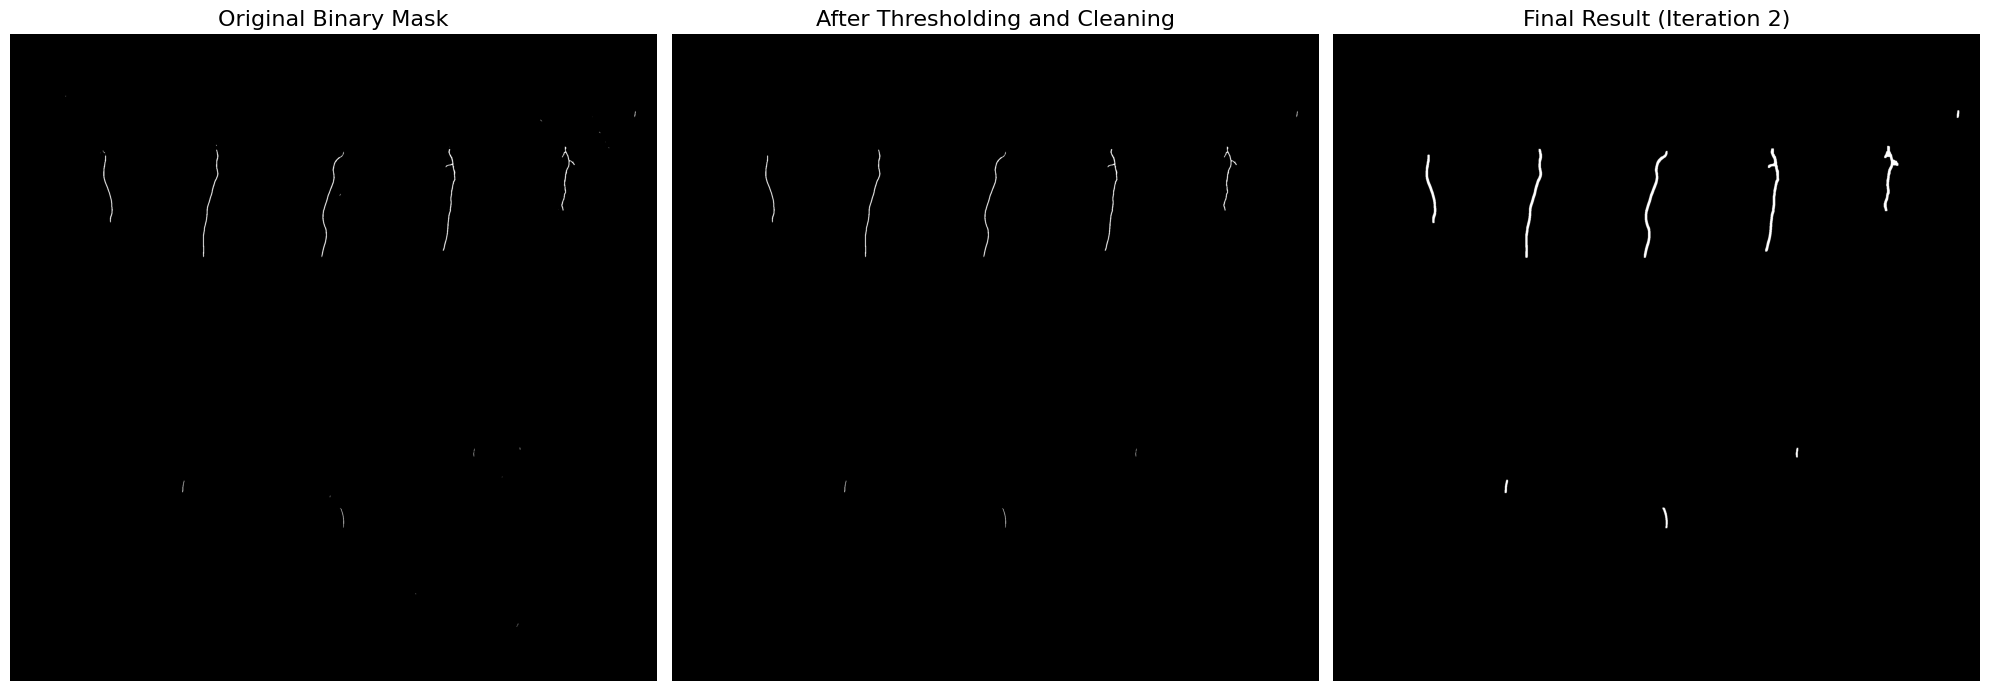

Processed test_image_6.png with Kernel Size = 7, Total Iterations = 2: Threshold = 0.5, Min Object Size = 50


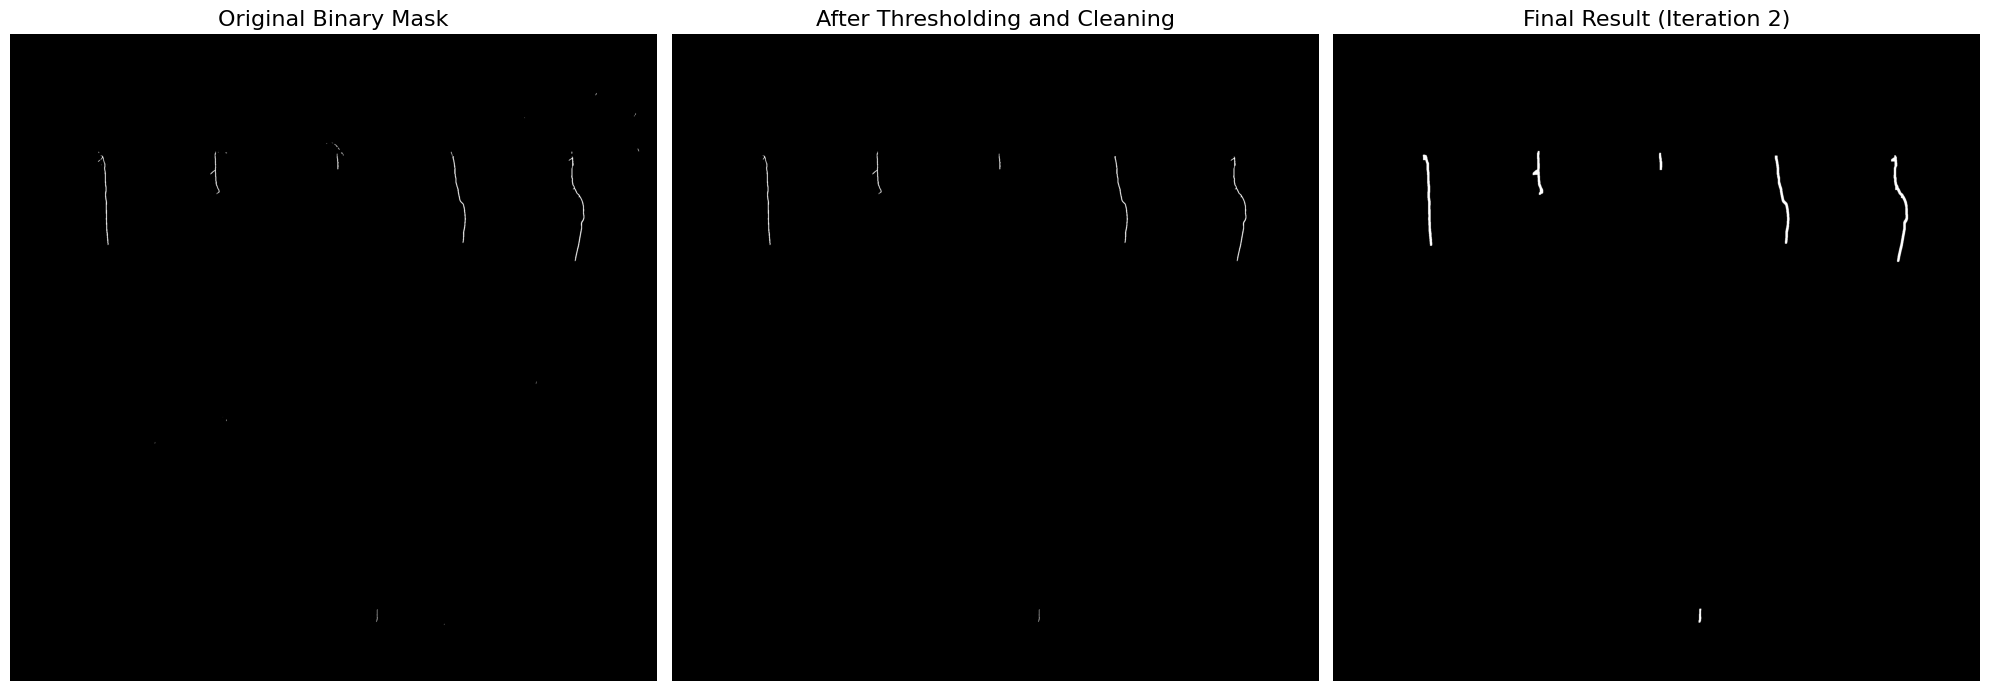

Processed test_image_7.png with Kernel Size = 7, Total Iterations = 2: Threshold = 0.5, Min Object Size = 50


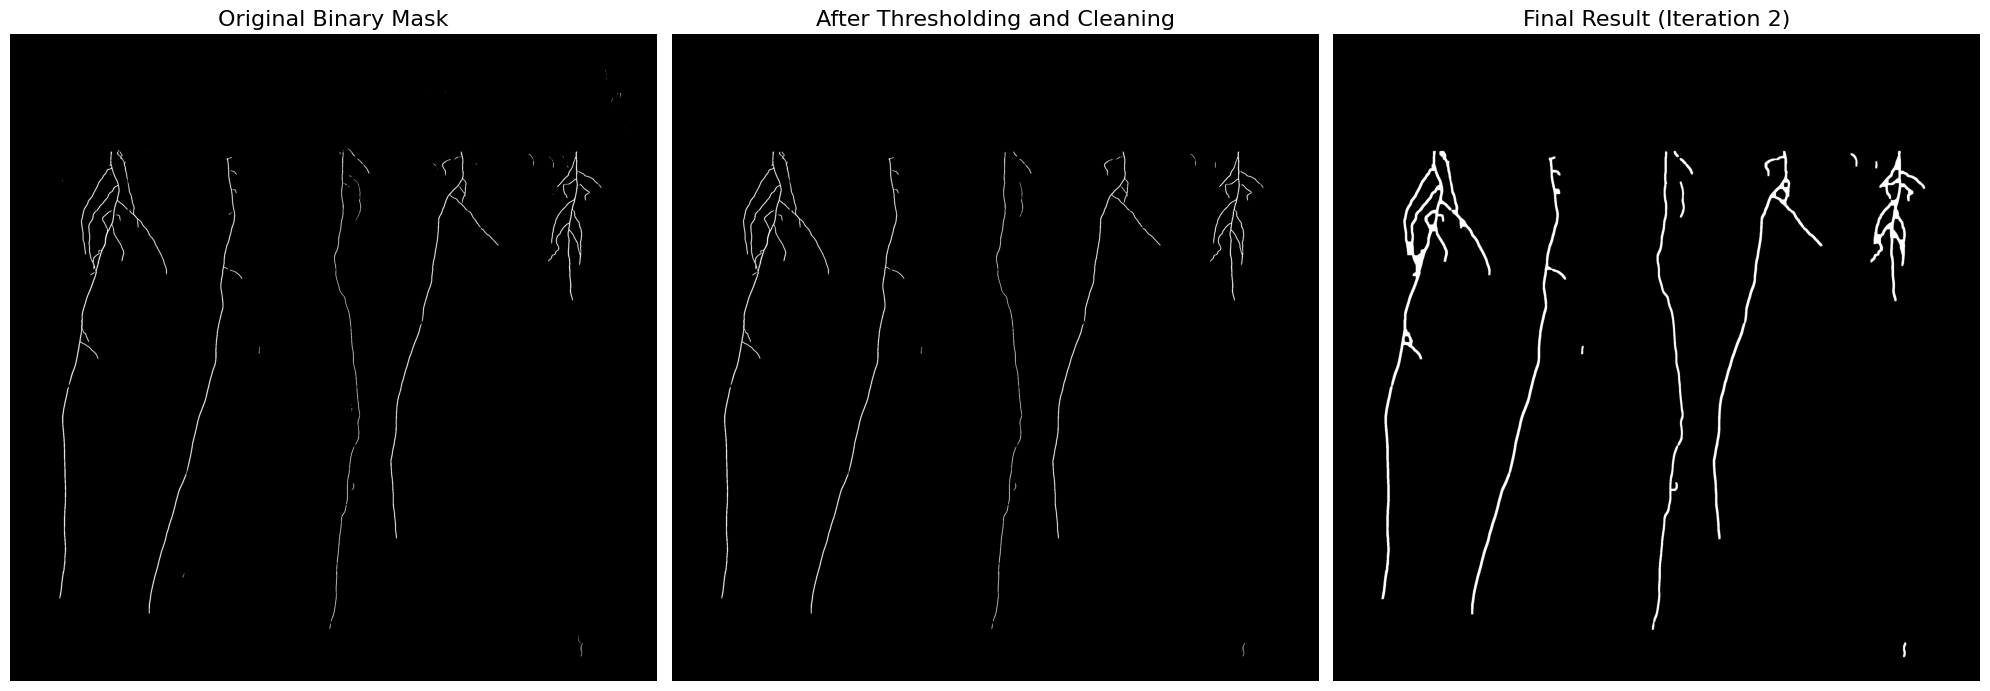

Processed test_image_8.png with Kernel Size = 7, Total Iterations = 2: Threshold = 0.5, Min Object Size = 50


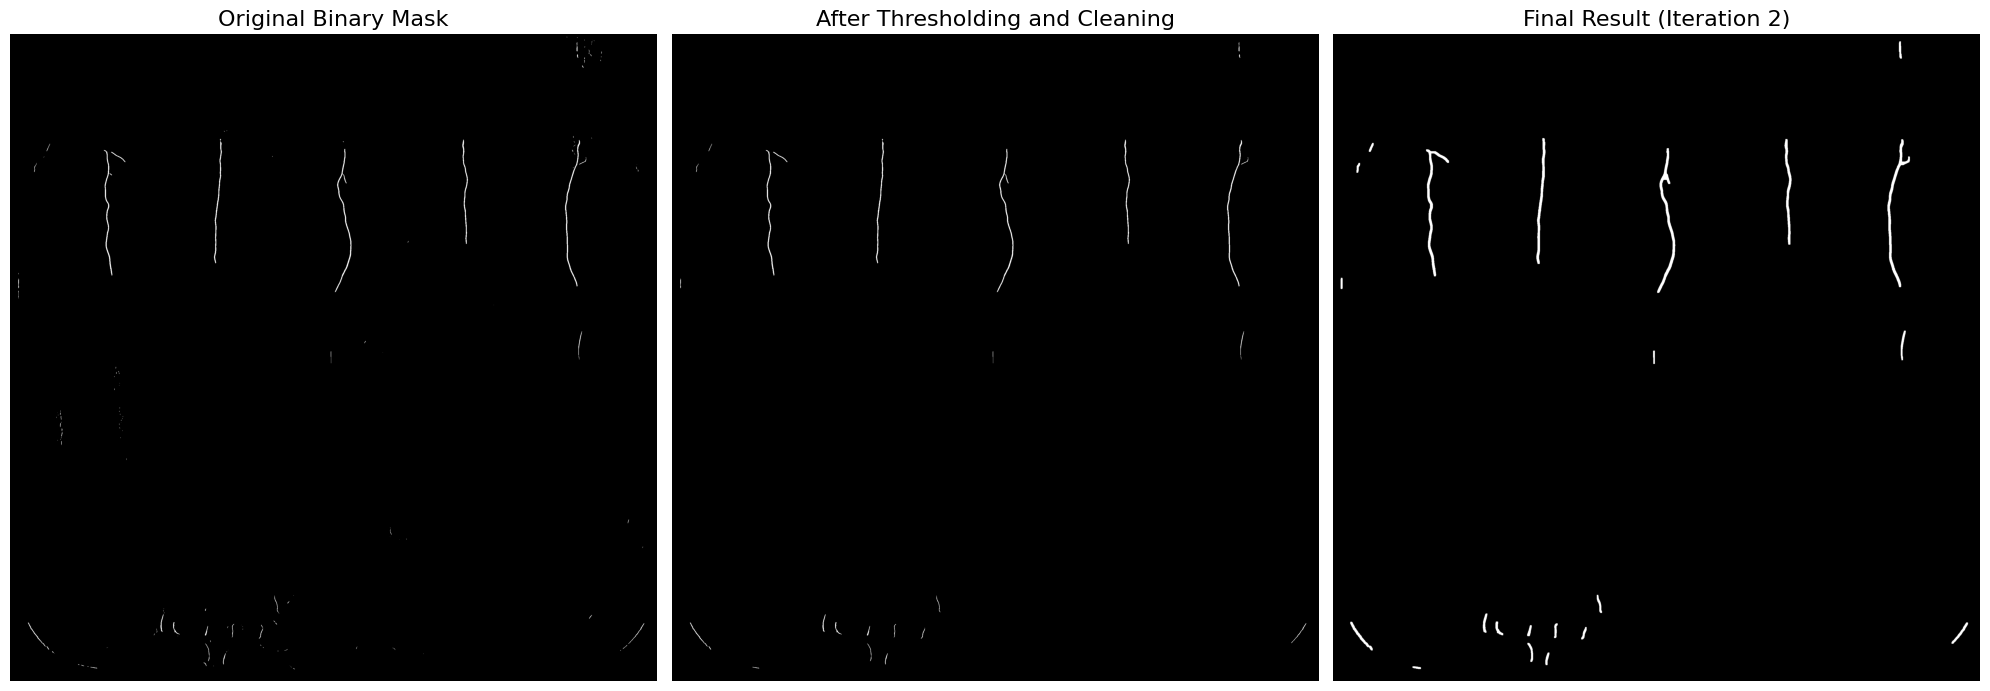

Processed test_image_9.png with Kernel Size = 7, Total Iterations = 2: Threshold = 0.5, Min Object Size = 50


In [49]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_objects

# Adjustable parameters
threshold_value = 0.5      # Adjust threshold value 
kernel_size = 7           # Set kernel size for morphological closing
iterations = 2            # Number of iterations to apply morphological closing
min_object_size = 50      # Adjust minimum object size for small object removal

# Process each binary mask in binary_predictions
processed_masks = []
for filename, binary_mask in binary_predictions:
    # Step 1: Apply thresholding
    _, thresholded_mask = cv2.threshold(binary_mask, threshold_value, 255, cv2.THRESH_BINARY)

    # Step 2: Remove small objects immediately after thresholding
    binary_mask_boolean = thresholded_mask > 0  # Convert to boolean (True for object pixels)
    cleaned_mask_after_thresholding = remove_small_objects(binary_mask_boolean, min_size=min_object_size)
    cleaned_mask_after_thresholding = (cleaned_mask_after_thresholding * 255).astype(np.uint8)  # Convert back to uint8

    # Step 3: Apply dilation before morphological closing to connect components
    dilation_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    dilated_mask = cv2.dilate(cleaned_mask_after_thresholding, dilation_kernel, iterations=1)

    final_cleaned_mask = None
    for i in range(iterations):
        # Step 4: Apply morphological closing with the same kernel size for multiple iterations
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
        closed_mask = cv2.morphologyEx(dilated_mask, cv2.MORPH_CLOSE, kernel, iterations=i+1)

        # Step 5: Remove small objects after morphological closing
        binary_mask_boolean = closed_mask > 0  # Convert to boolean (True for object pixels)
        cleaned_mask = remove_small_objects(binary_mask_boolean, min_size=min_object_size)
        final_cleaned_mask = (cleaned_mask * 255).astype(np.uint8)  # Convert back to uint8

        # Store the result of the last iteration
        if i == iterations - 1:
            processed_masks.append((filename, final_cleaned_mask))

    # Step 6: Post-processing with dilation followed by erosion (opening)
    post_dilation_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    post_dilated_mask = cv2.dilate(final_cleaned_mask, post_dilation_kernel, iterations=1)
    post_eroded_mask = cv2.erode(post_dilated_mask, post_dilation_kernel, iterations=1)

    # Update the final cleaned mask after post-processing
    final_cleaned_mask = post_eroded_mask

    # Plot final result only
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 3, 1)
    plt.title("Original Binary Mask", fontsize=16)
    plt.imshow(binary_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("After Thresholding and Cleaning", fontsize=16)
    plt.imshow(cleaned_mask_after_thresholding, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title(f"Final Result (Iteration {iterations})", fontsize=16)
    plt.imshow(final_cleaned_mask, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    print(f"Processed {filename} with Kernel Size = {kernel_size}, Total Iterations = {iterations}: Threshold = {threshold_value}, Min Object Size = {min_object_size}")


Filename: test_image_1.png | Number of connected components: 4


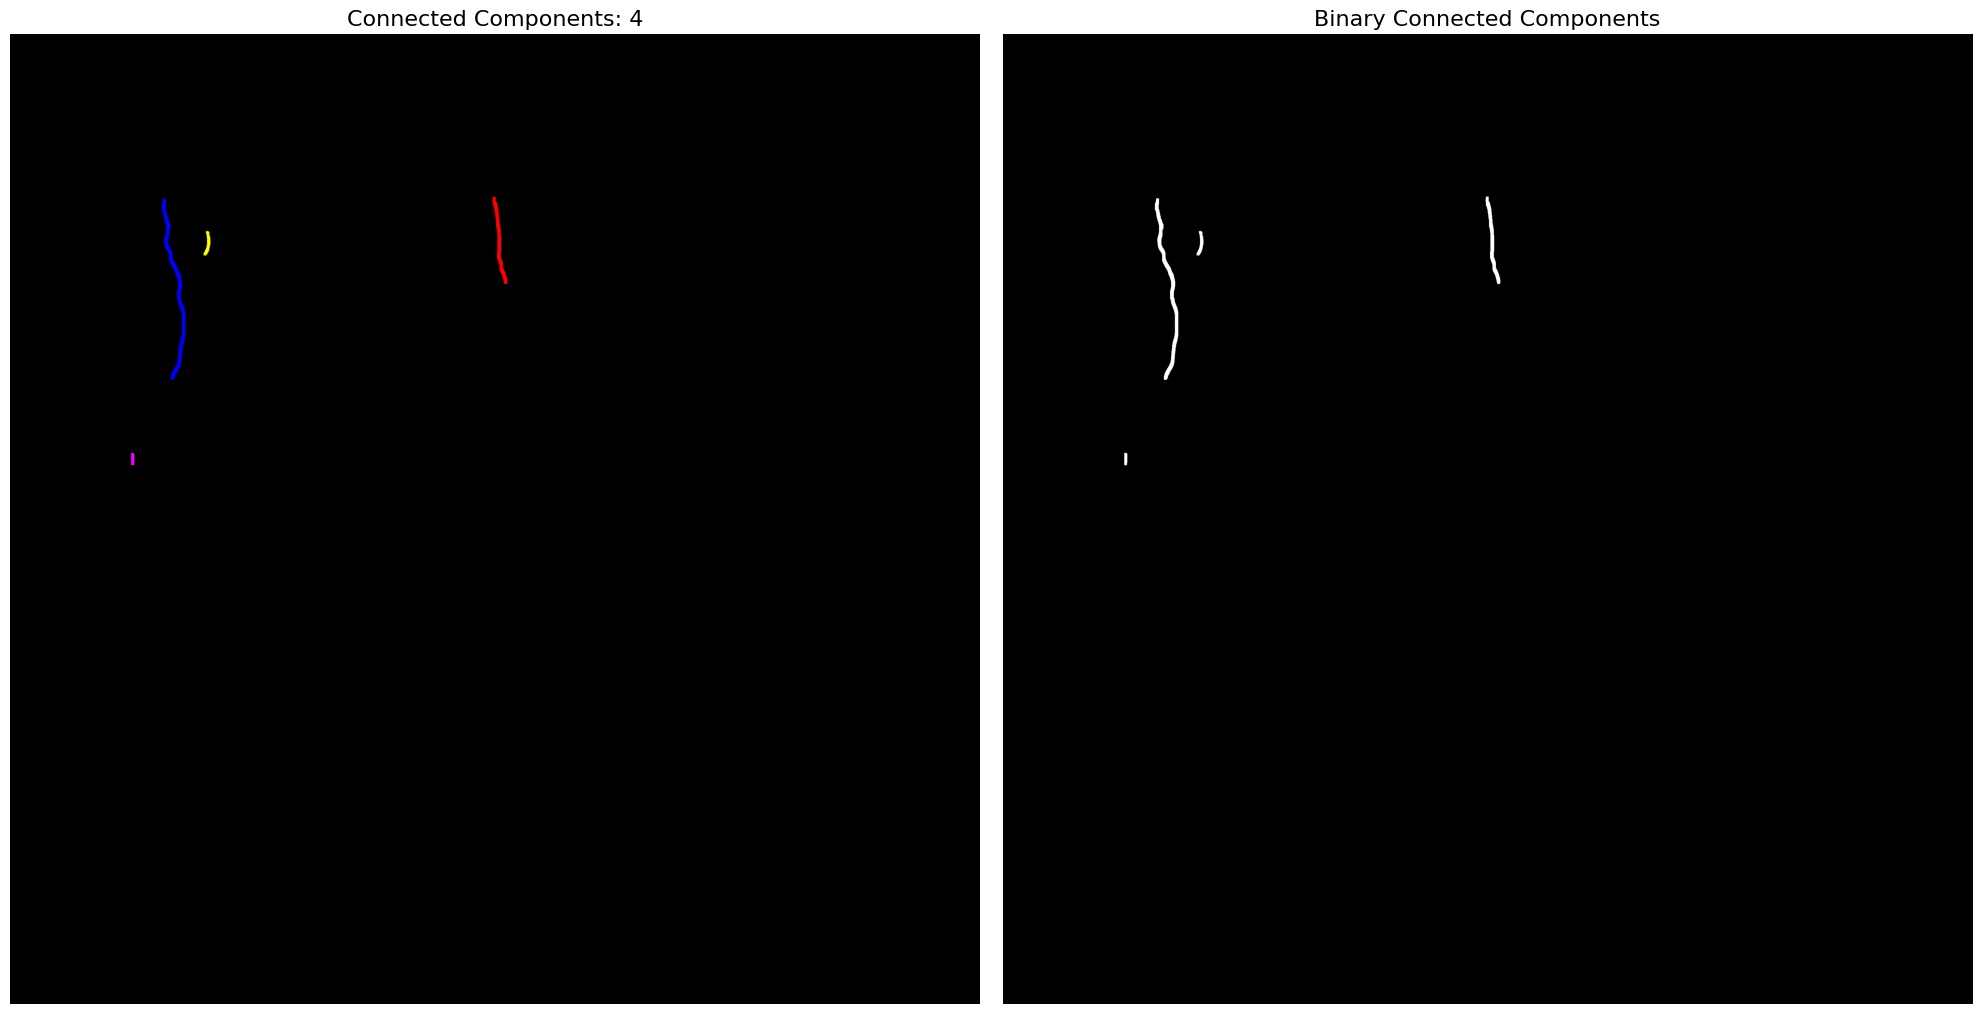

Filename: test_image_10.png | Number of connected components: 58


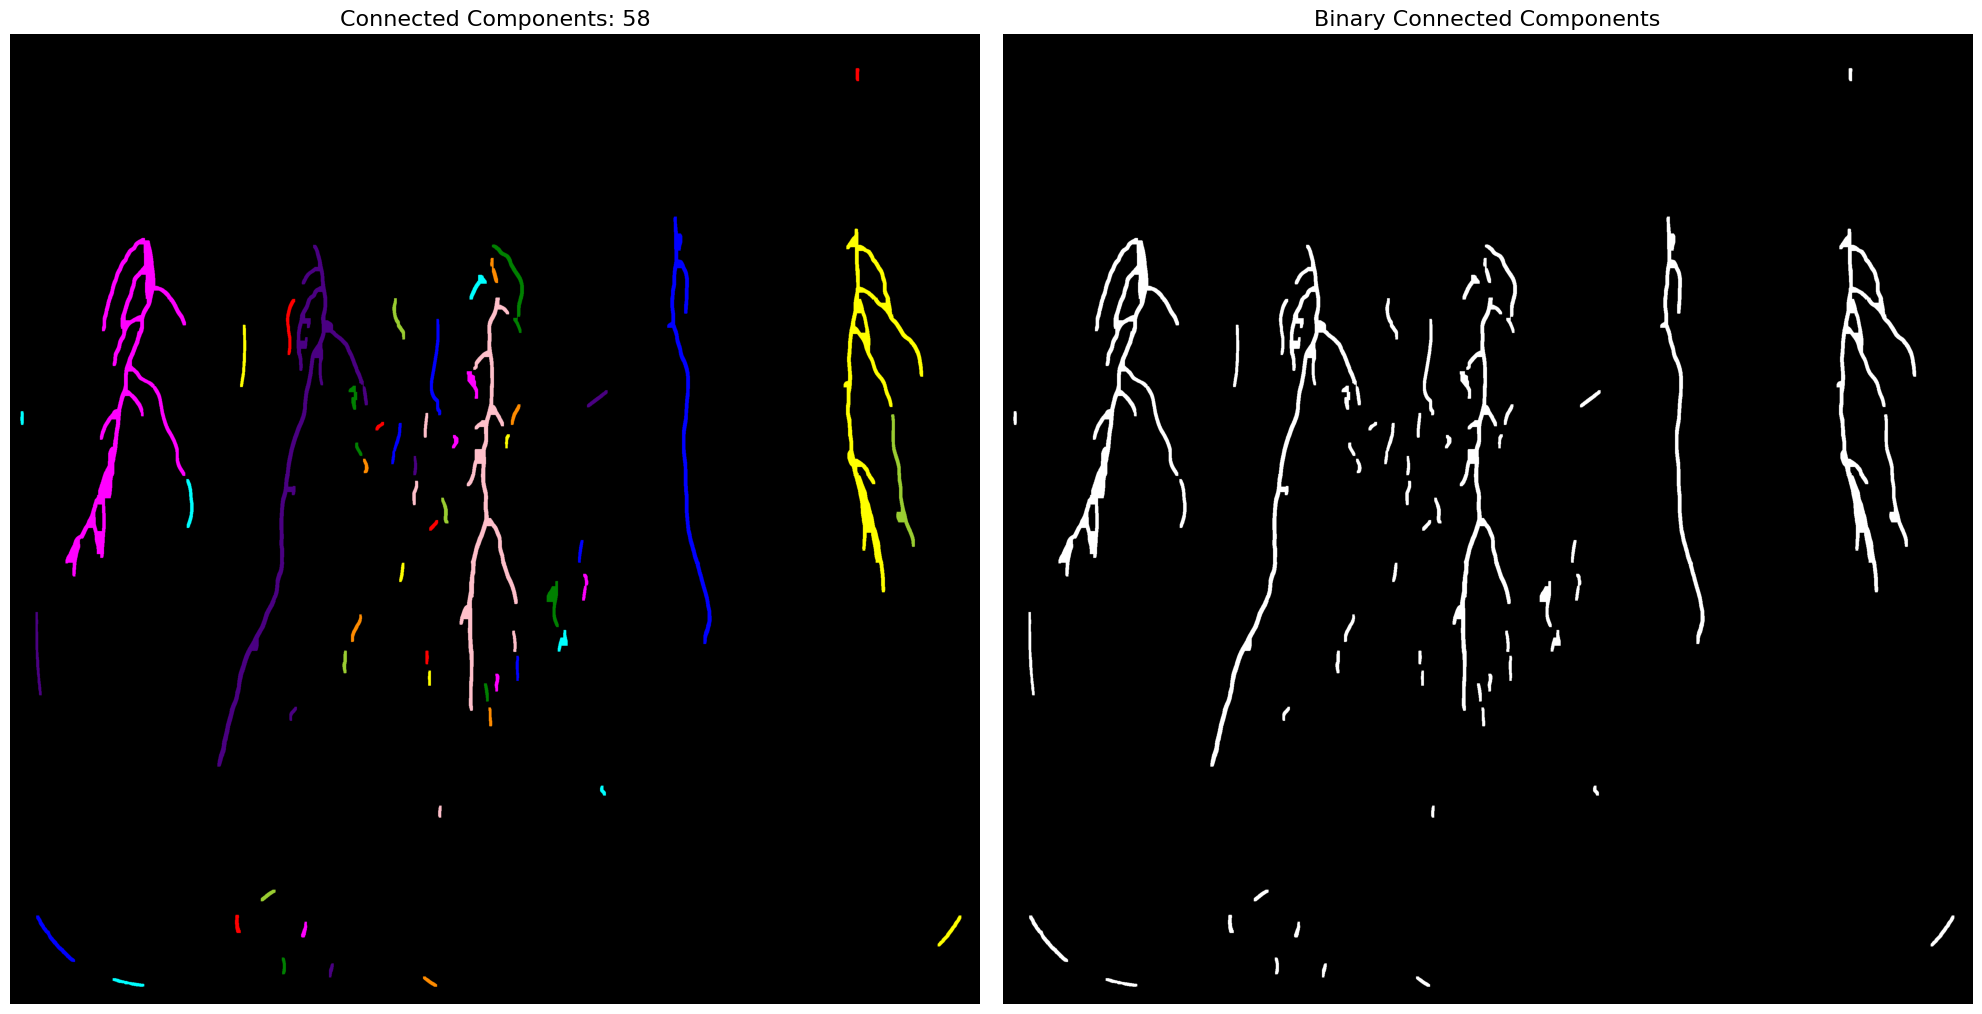

Filename: test_image_11.png | Number of connected components: 51


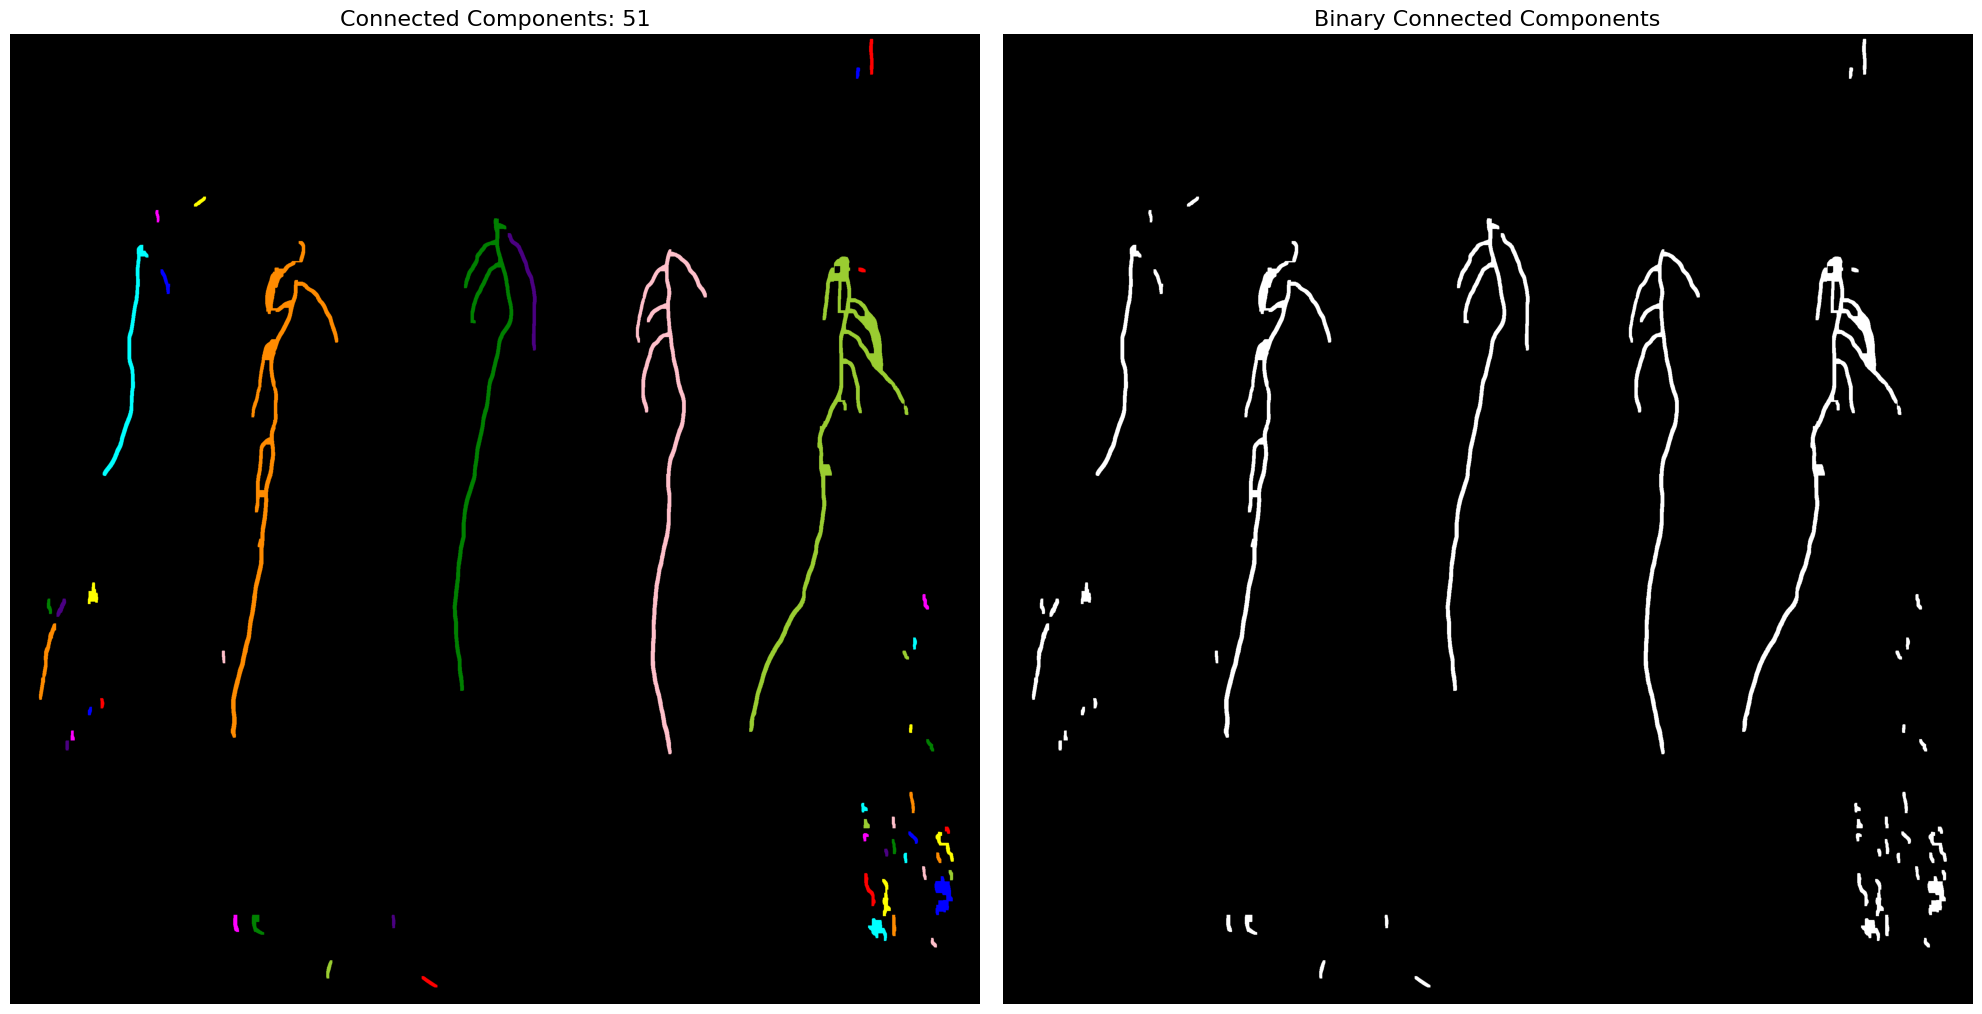

Filename: test_image_12.png | Number of connected components: 30


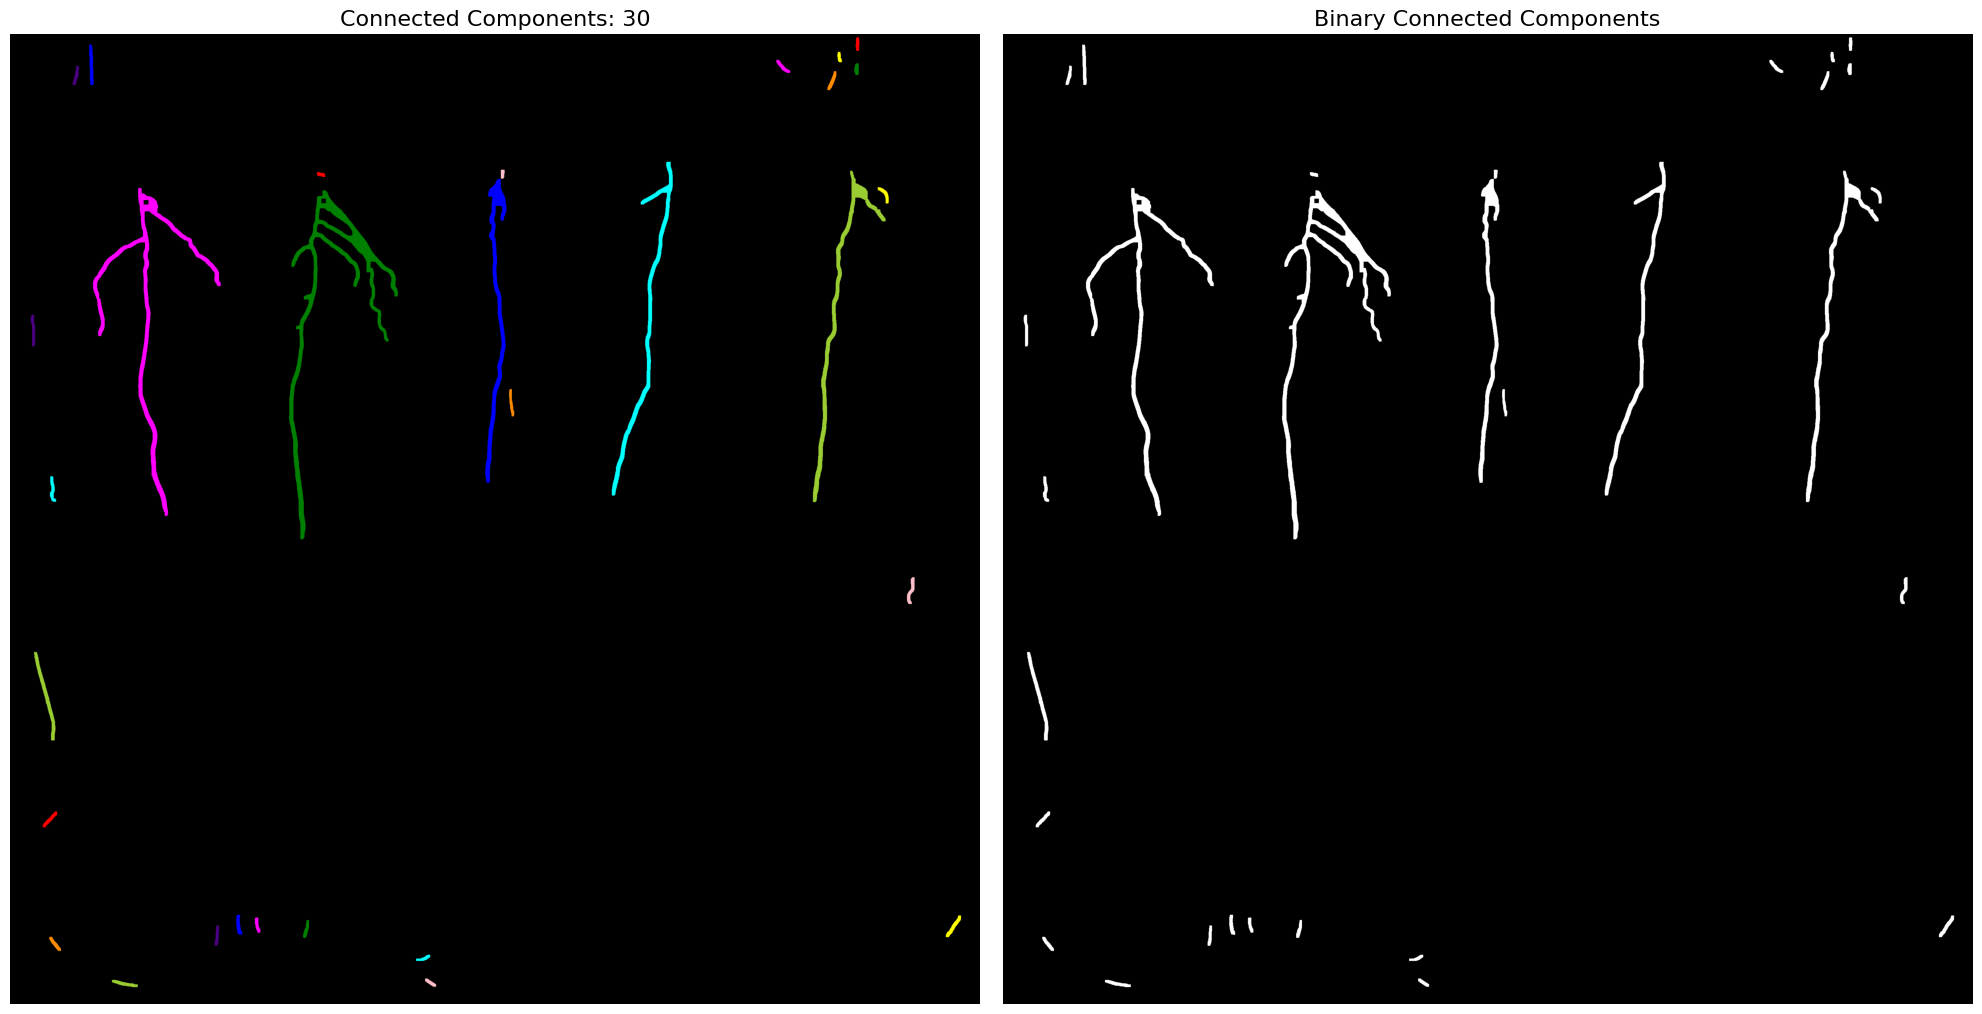

Filename: test_image_13.png | Number of connected components: 18


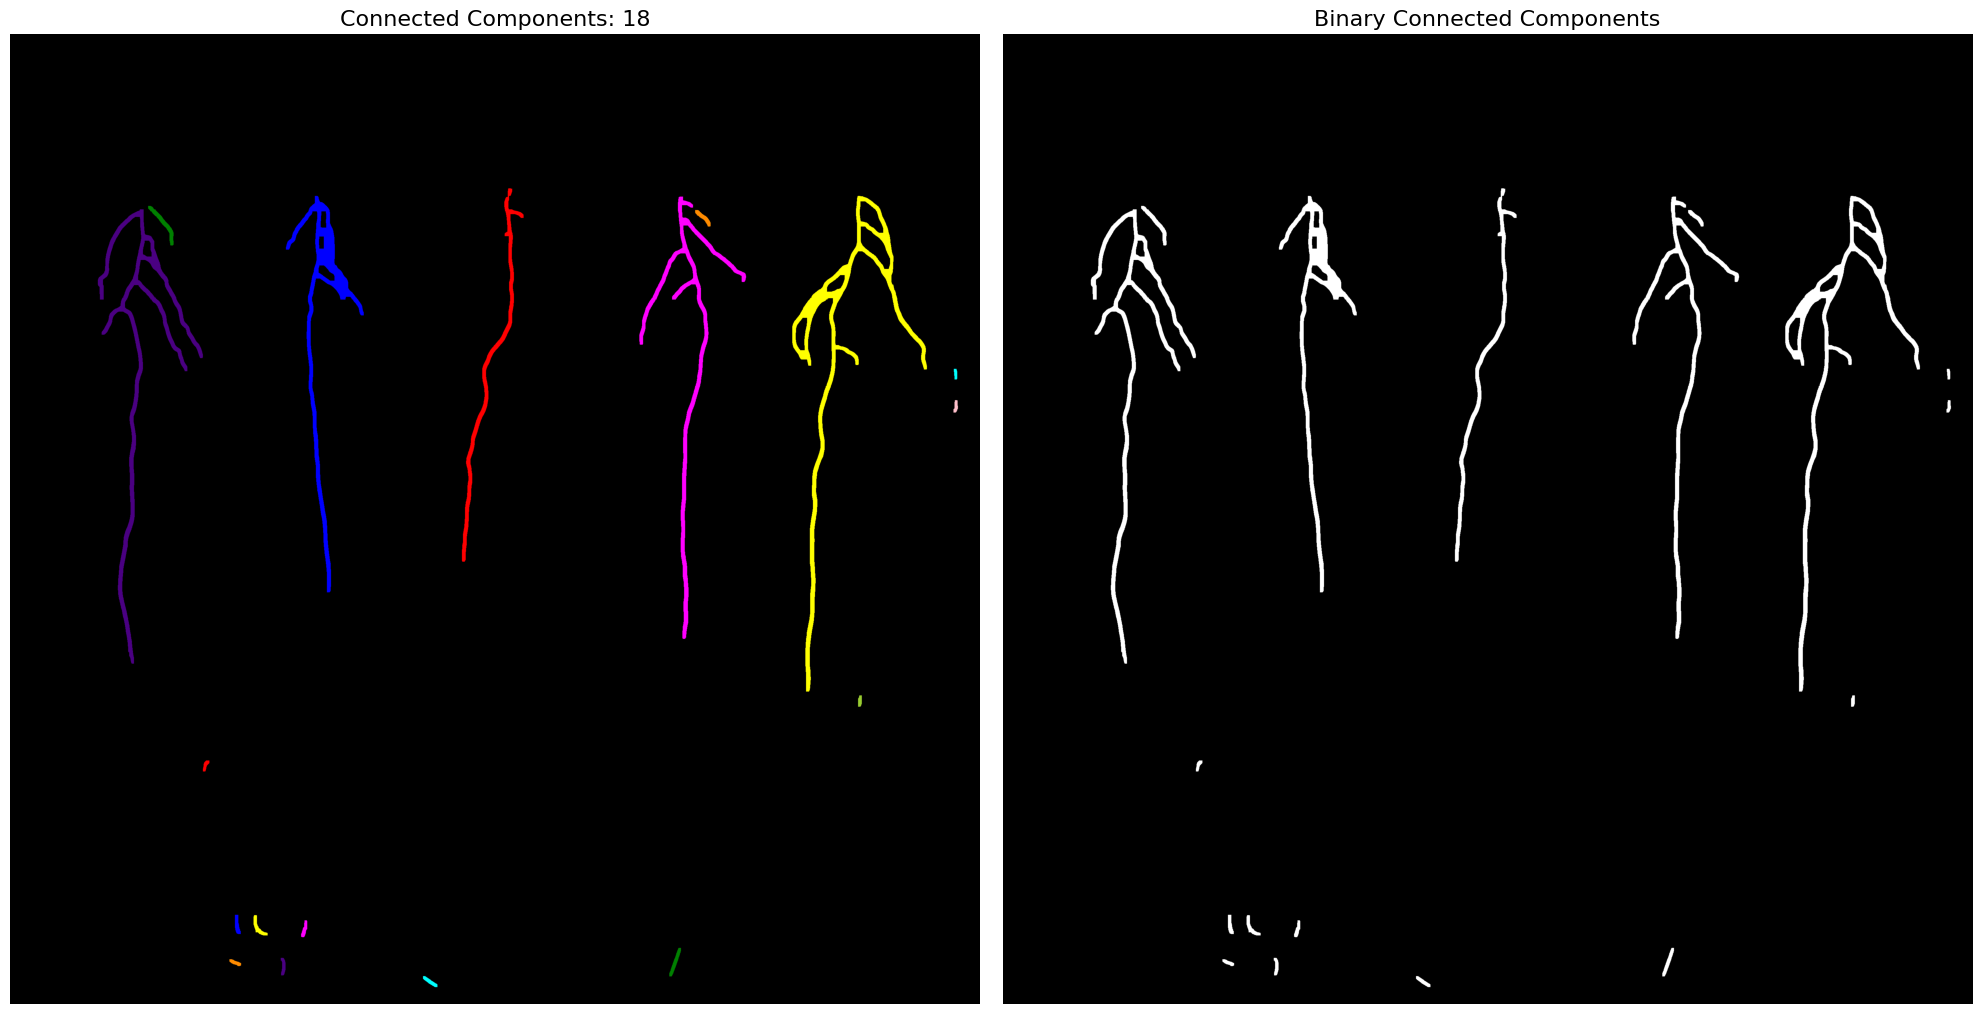

Filename: test_image_14.png | Number of connected components: 52


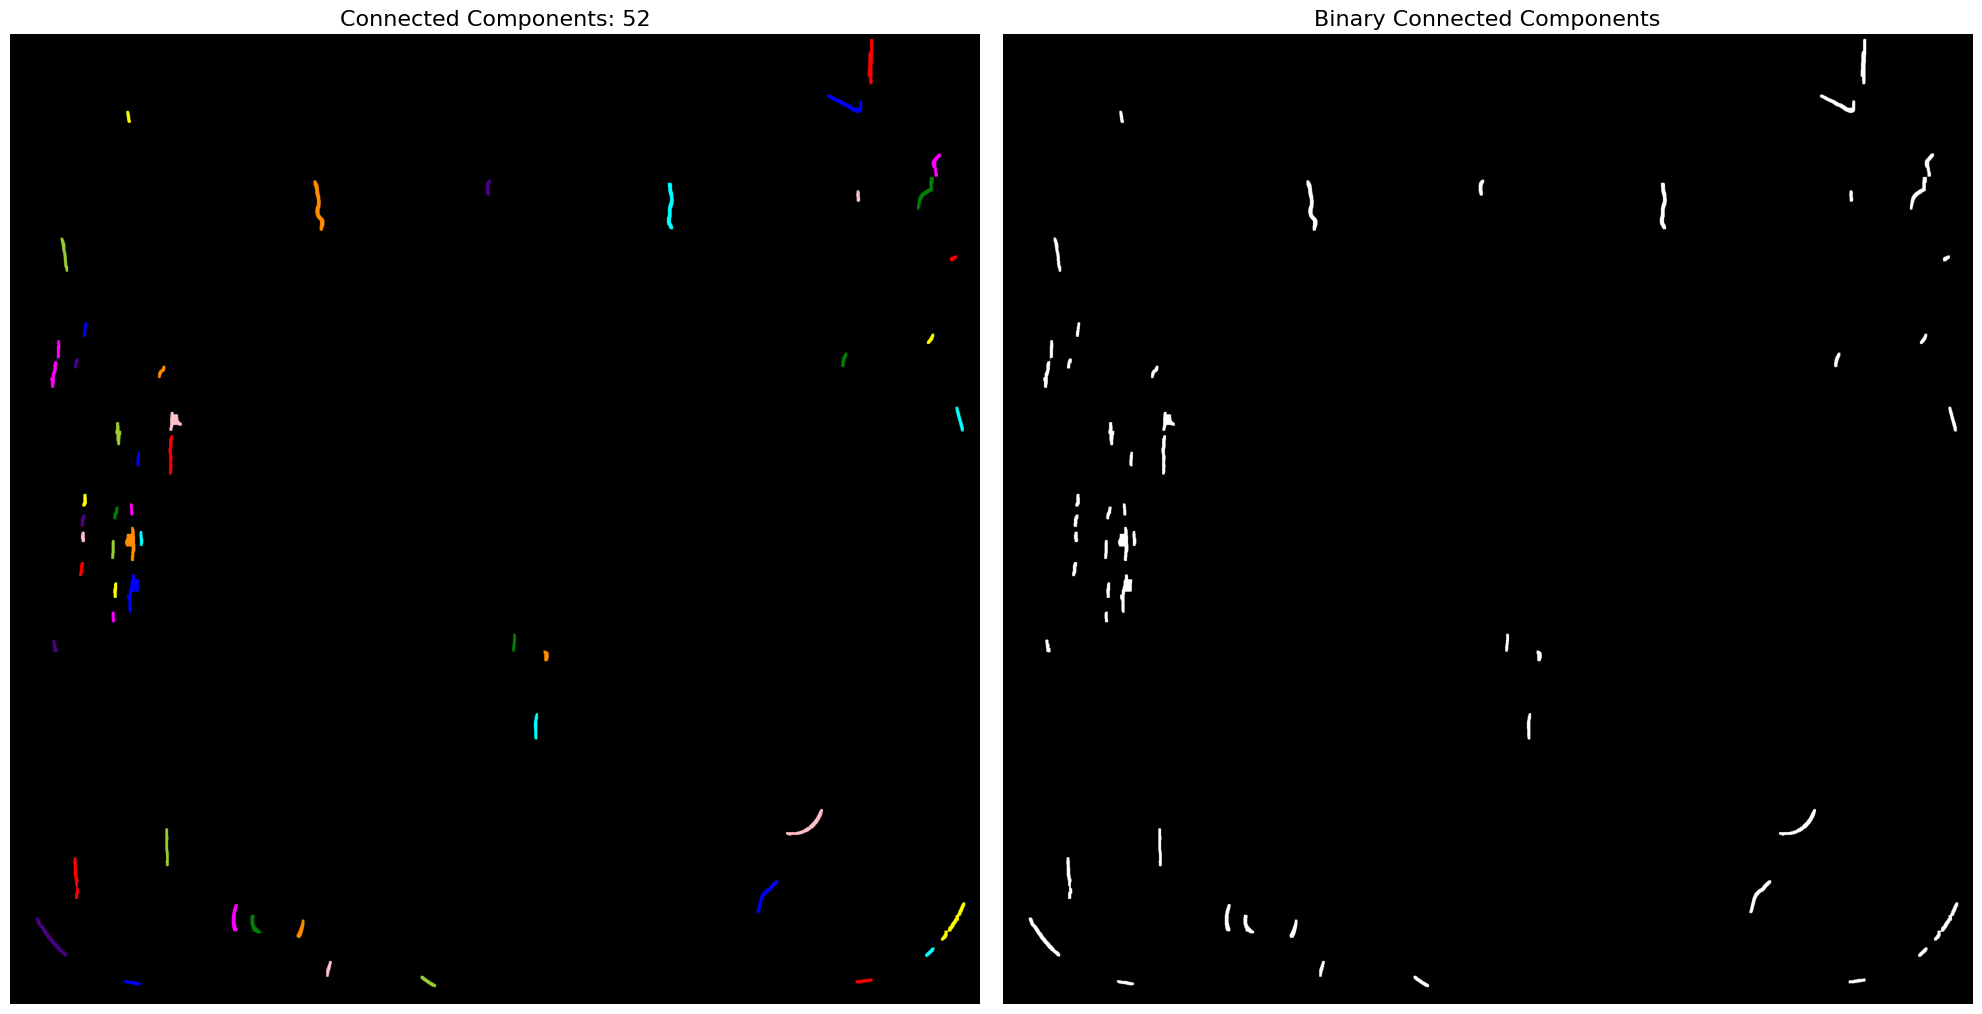

Filename: test_image_15.png | Number of connected components: 58


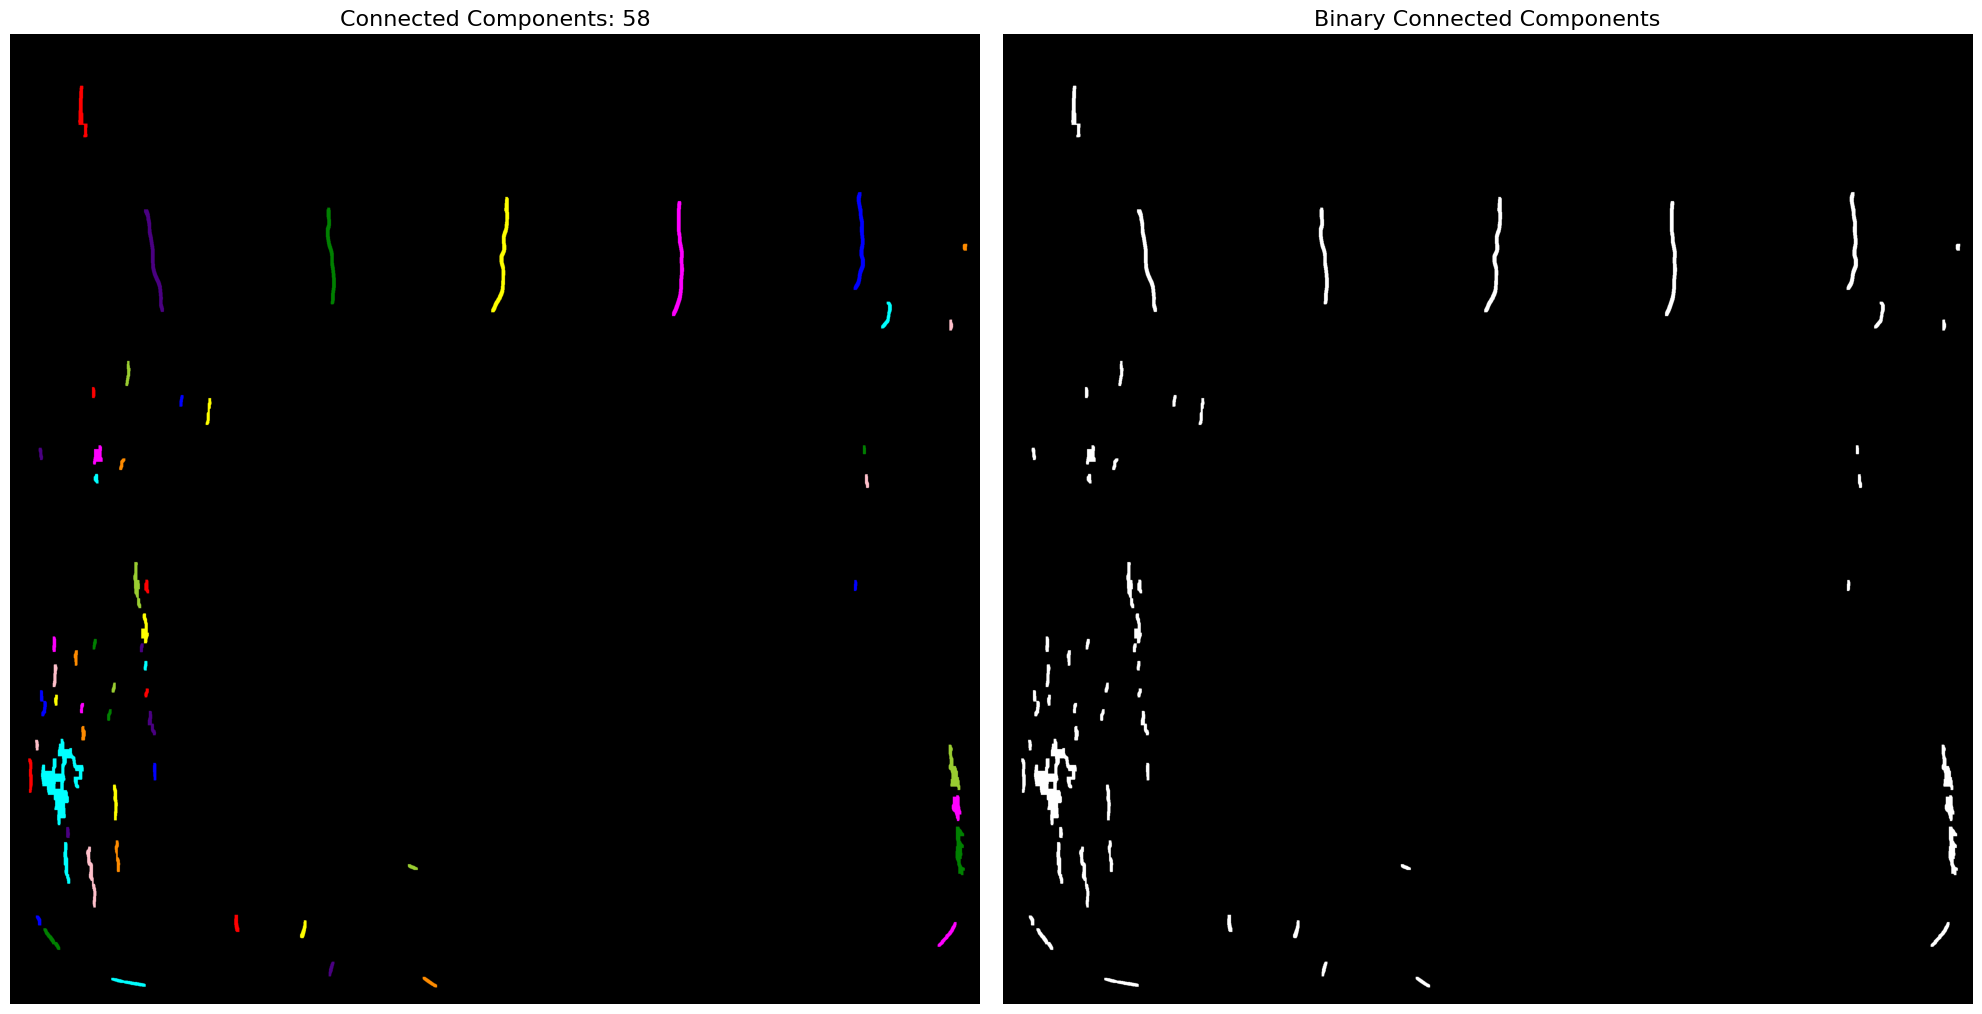

Filename: test_image_16.png | Number of connected components: 33


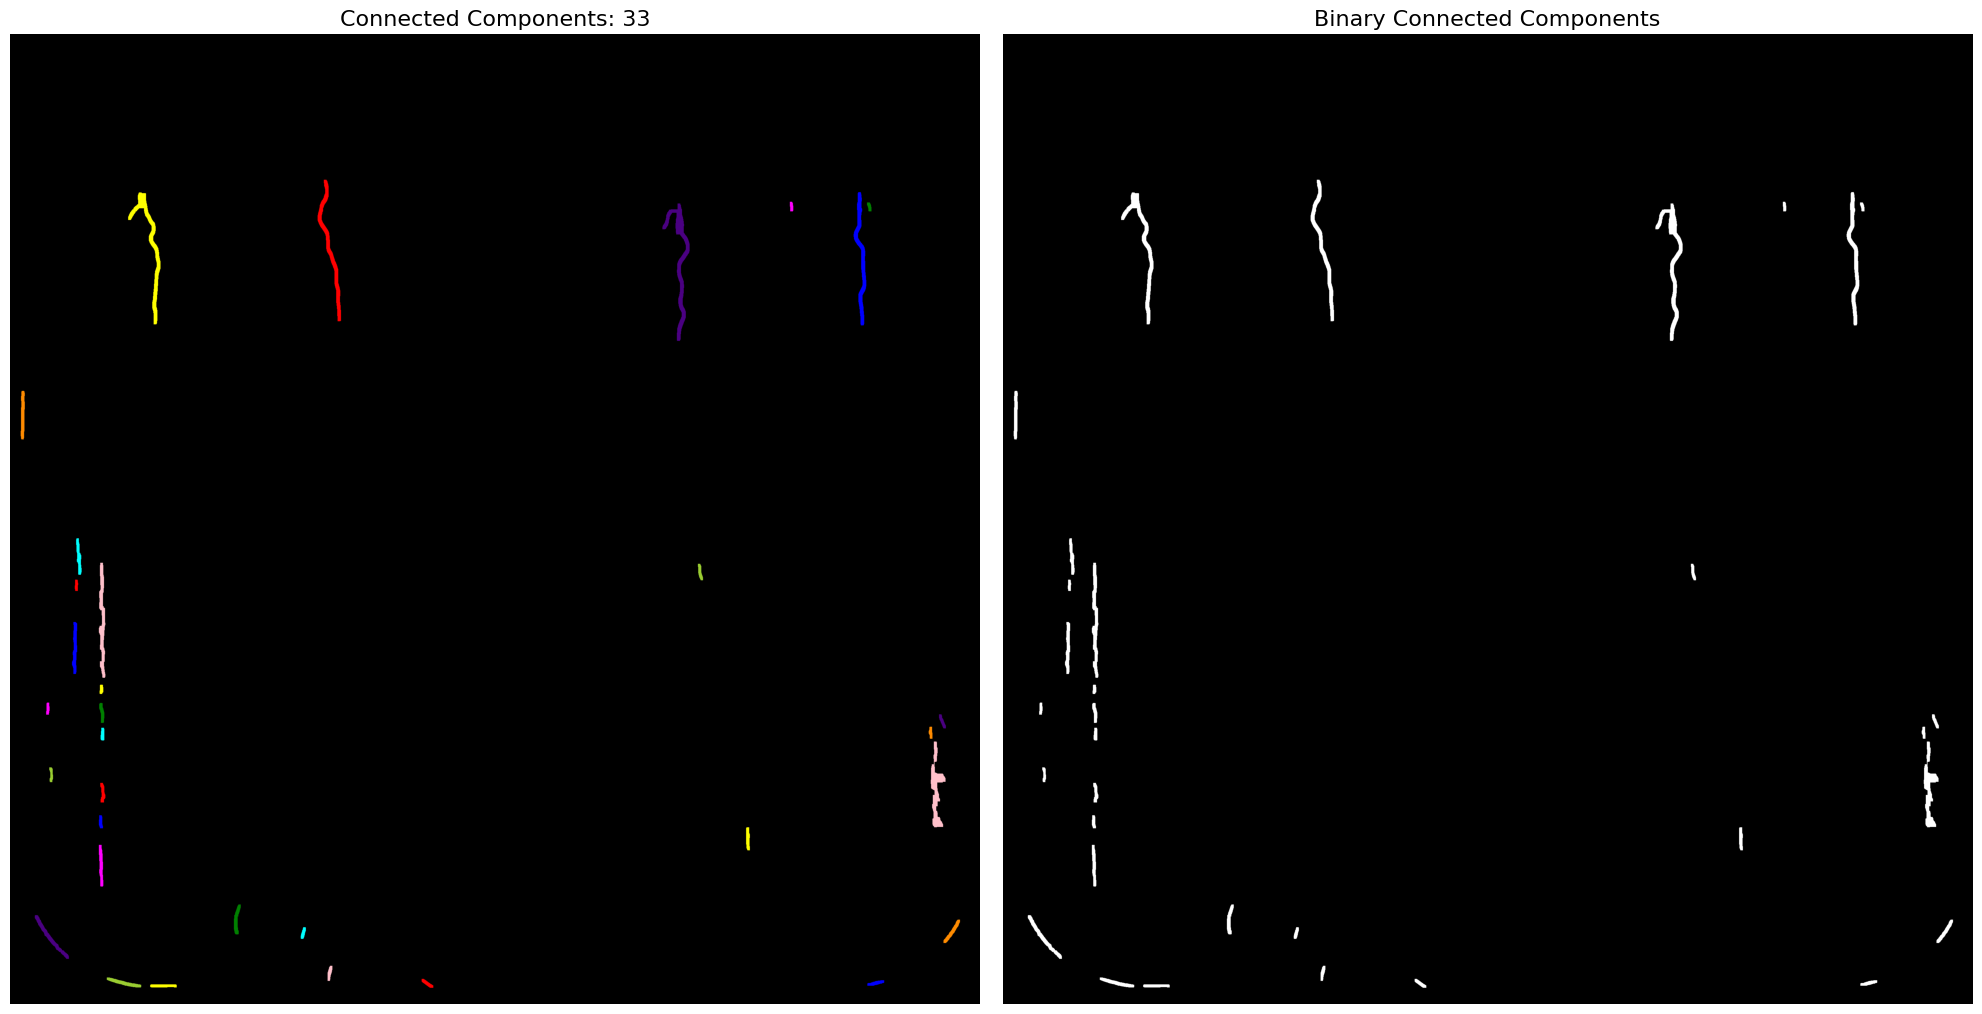

Filename: test_image_17.png | Number of connected components: 15


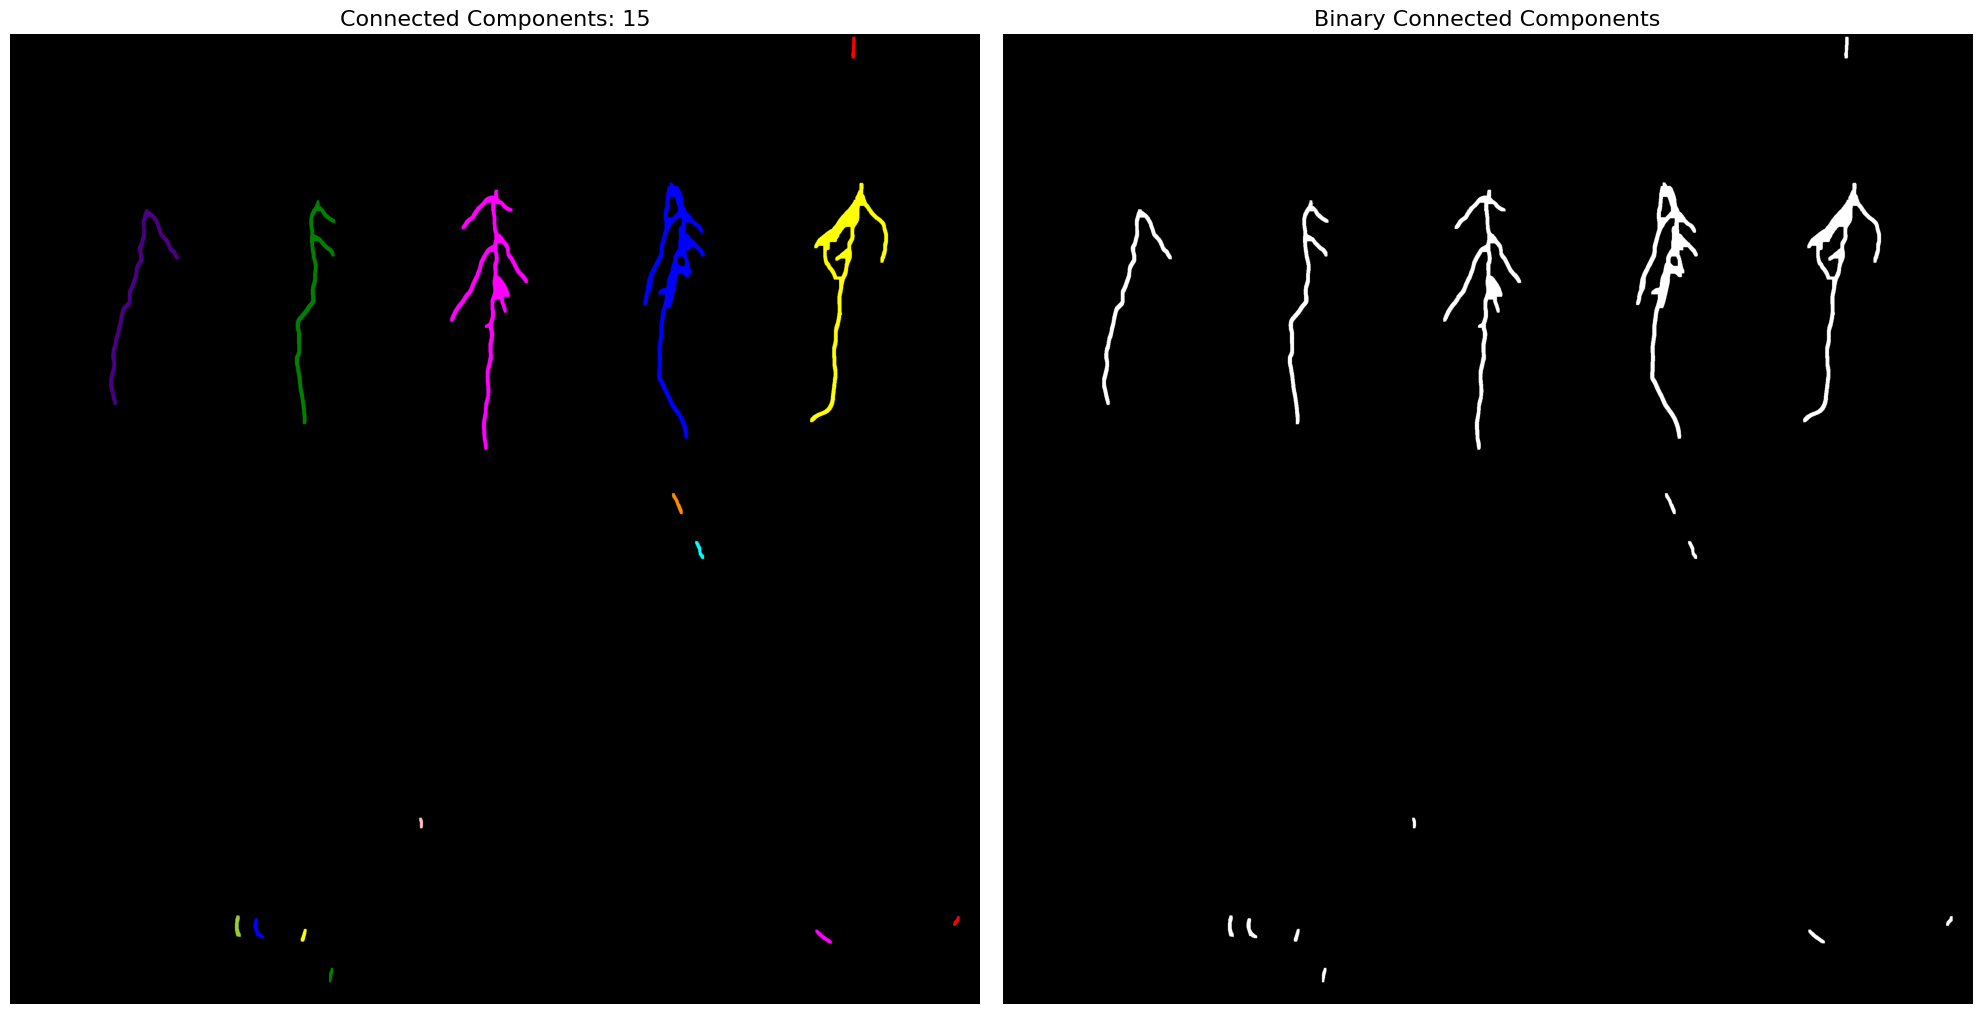

Filename: test_image_18.png | Number of connected components: 33


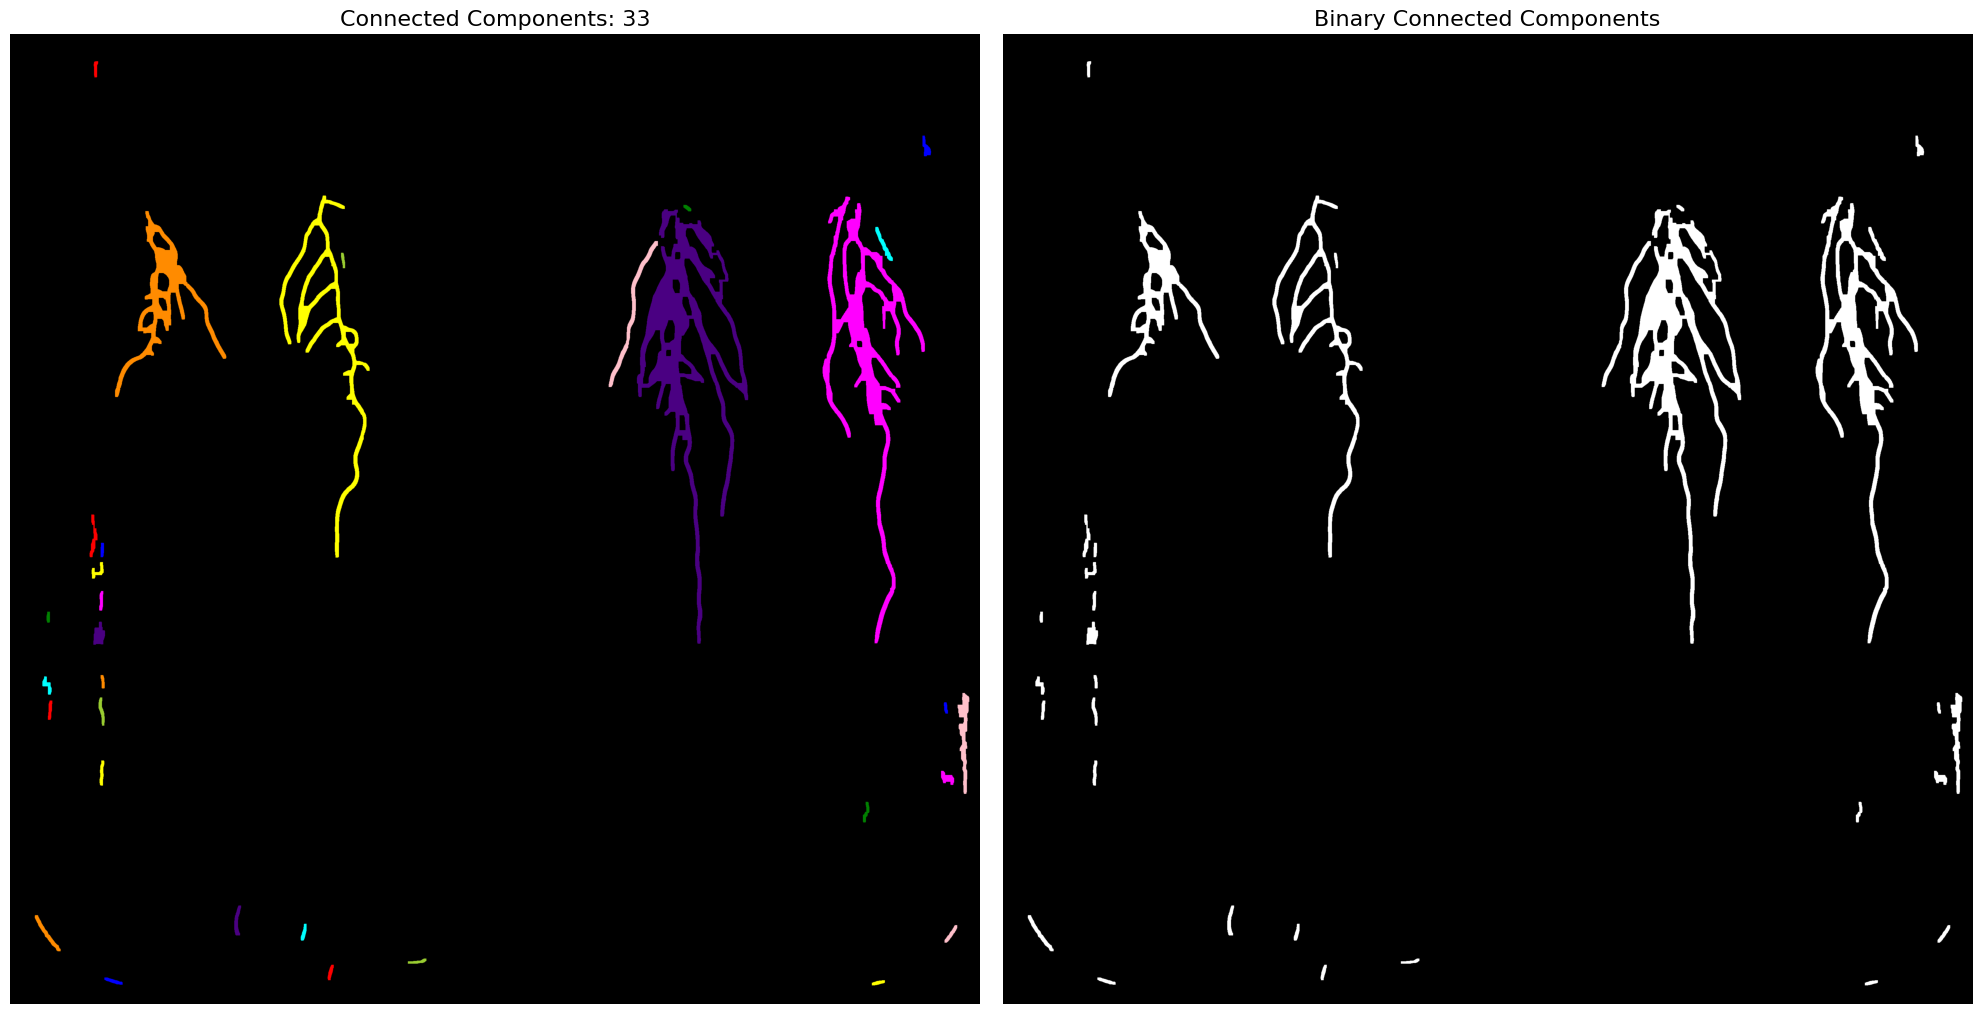

Filename: test_image_2.png | Number of connected components: 10


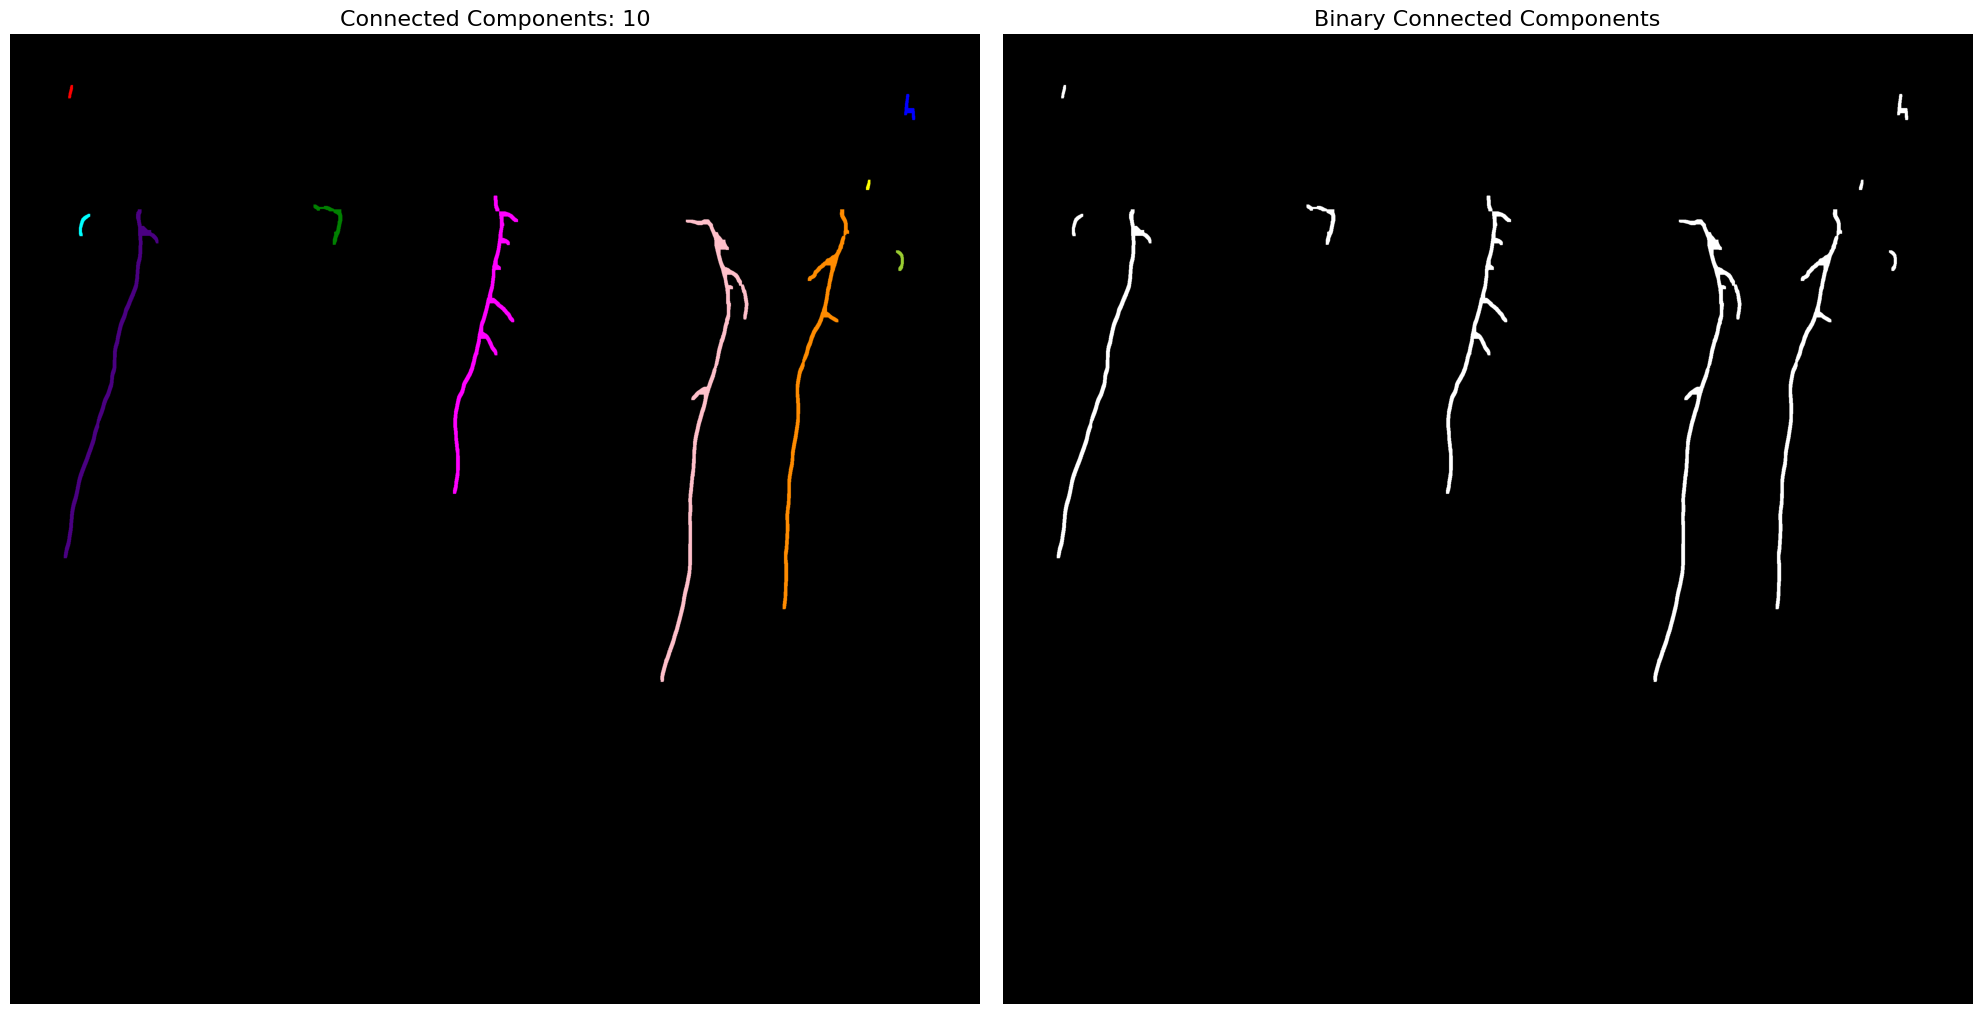

Filename: test_image_3.png | Number of connected components: 7


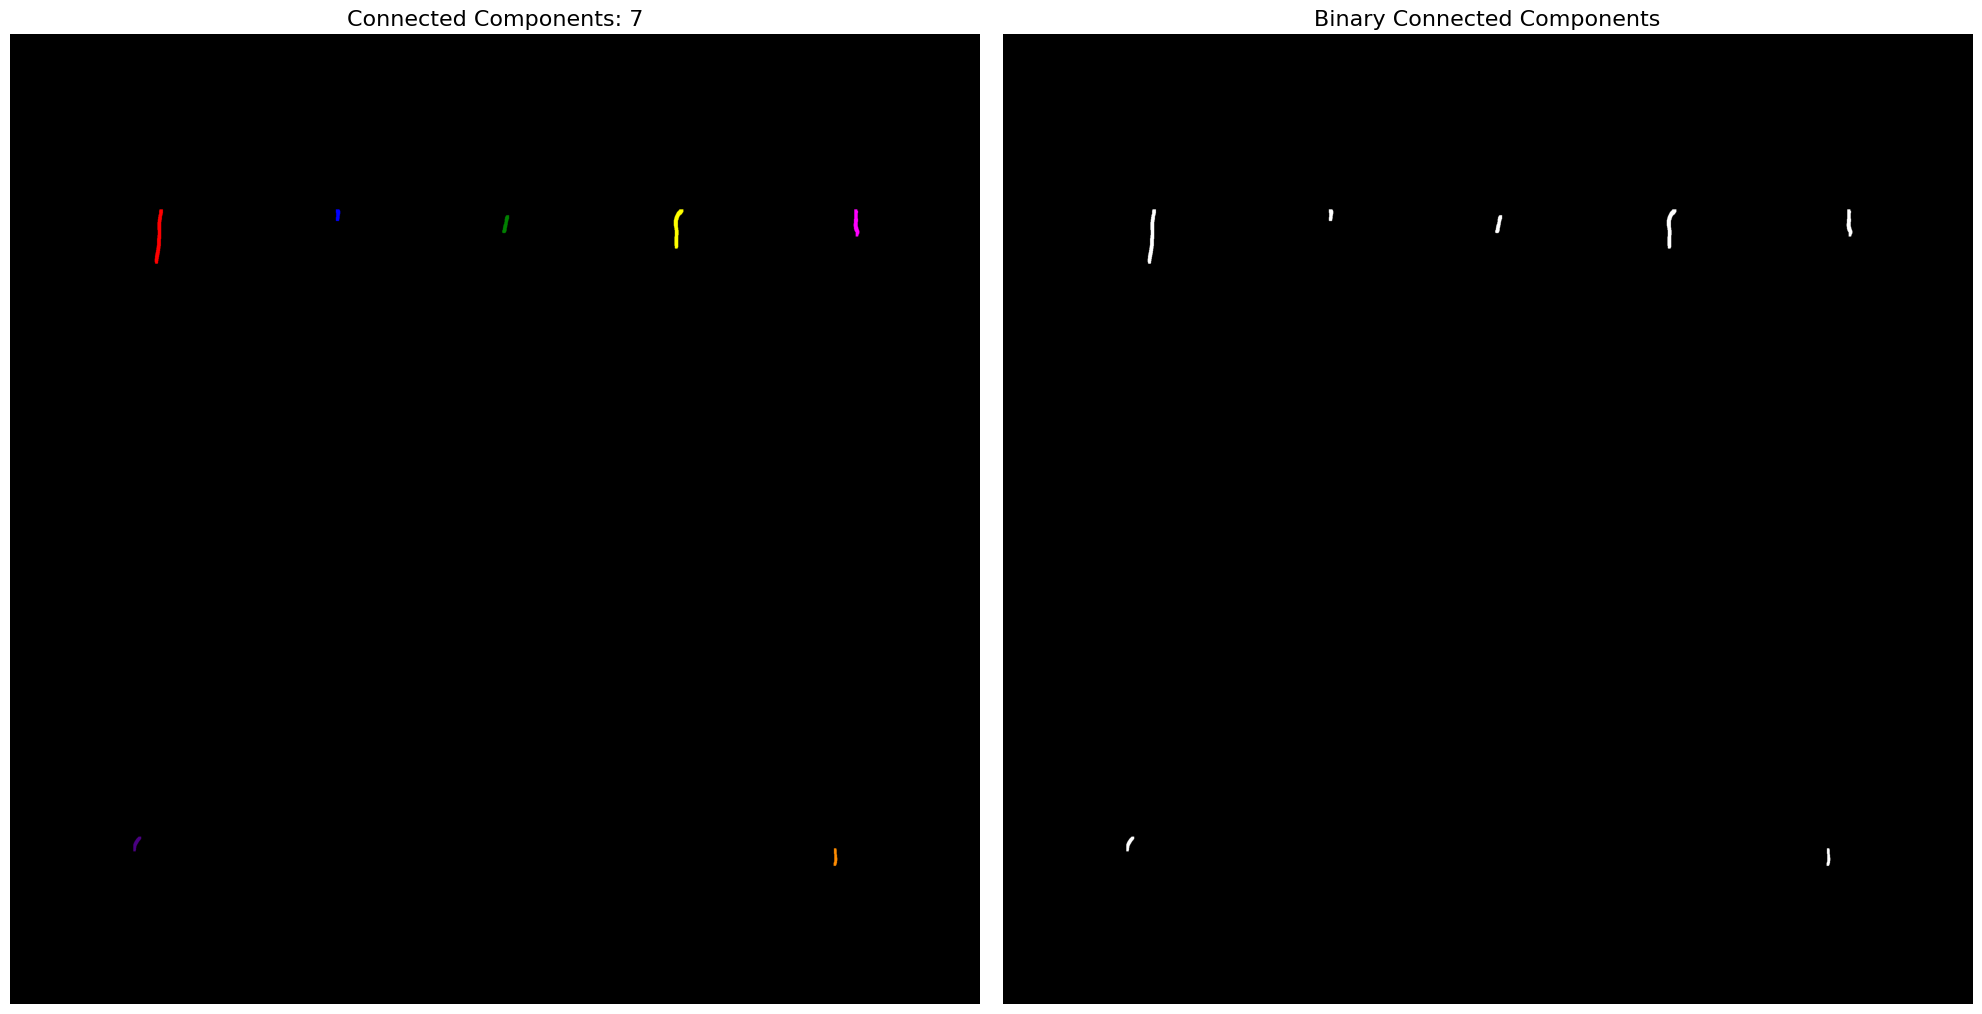

Filename: test_image_4.png | Number of connected components: 7


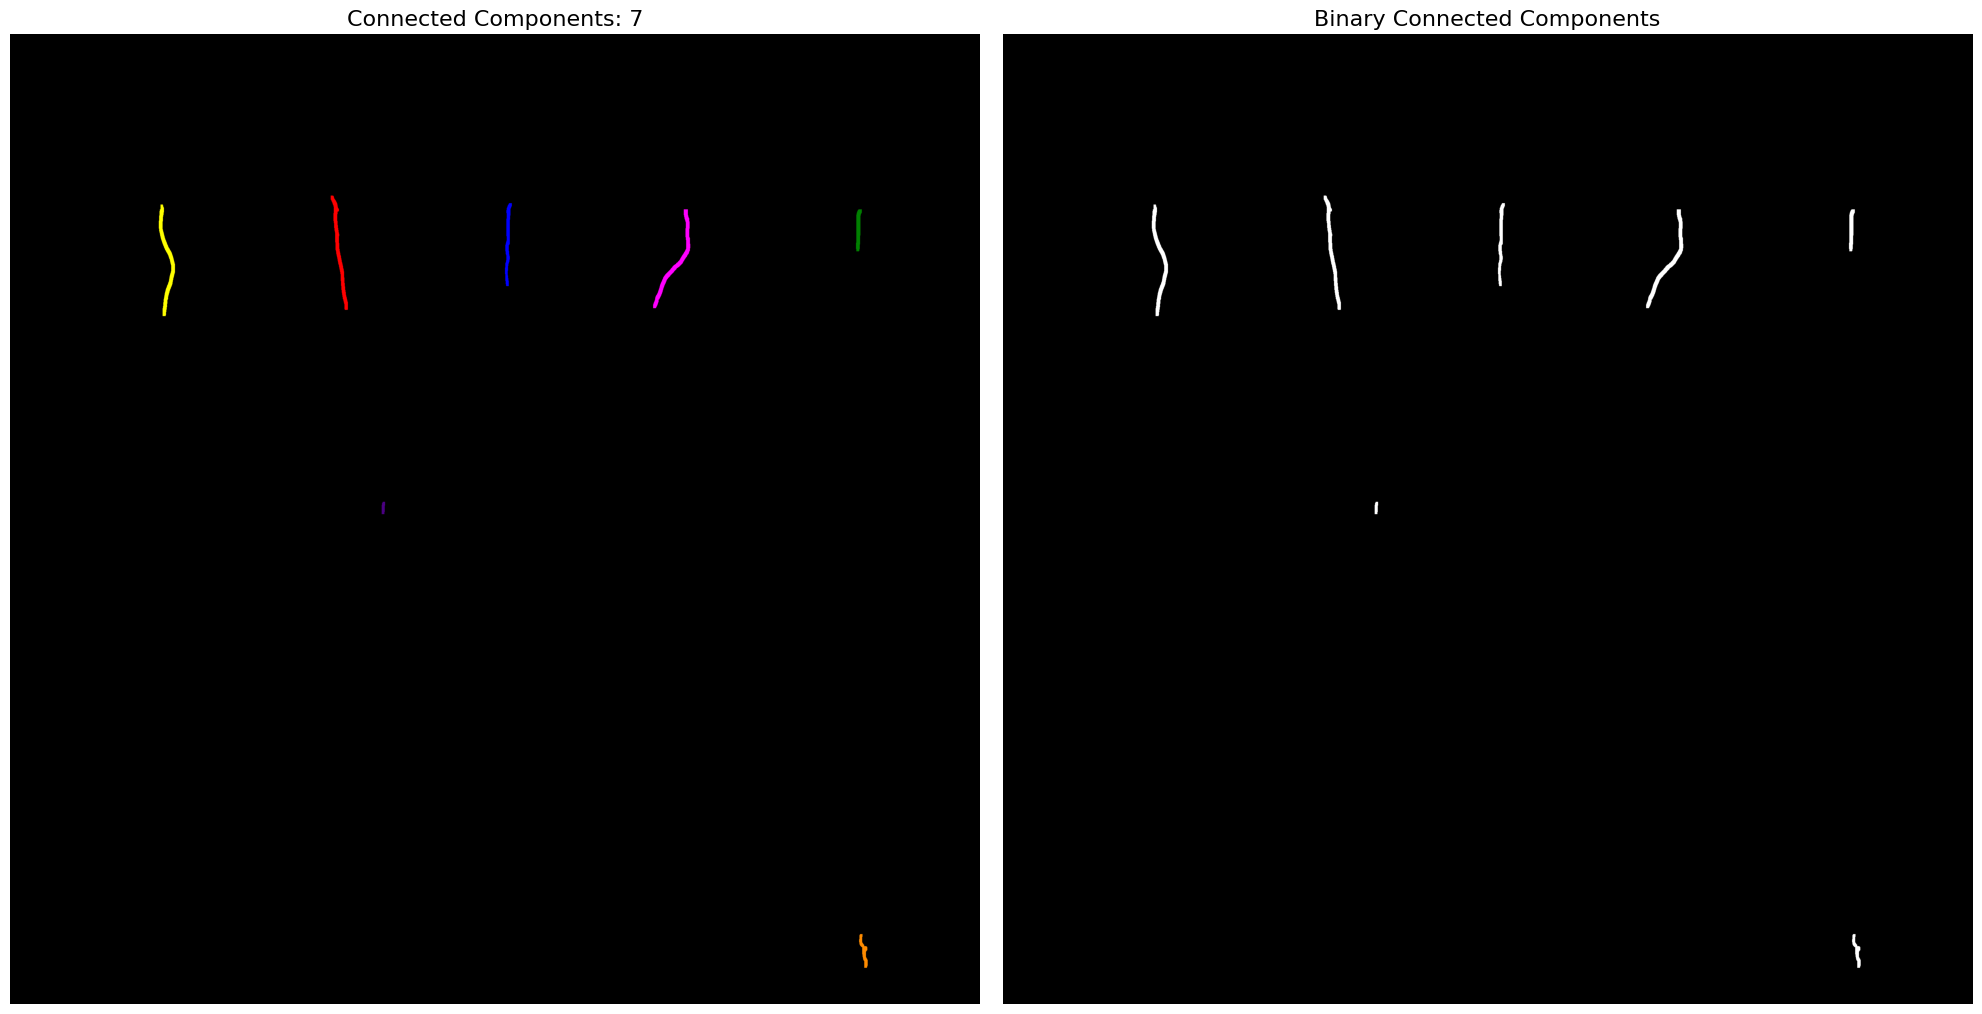

Filename: test_image_5.png | Number of connected components: 5


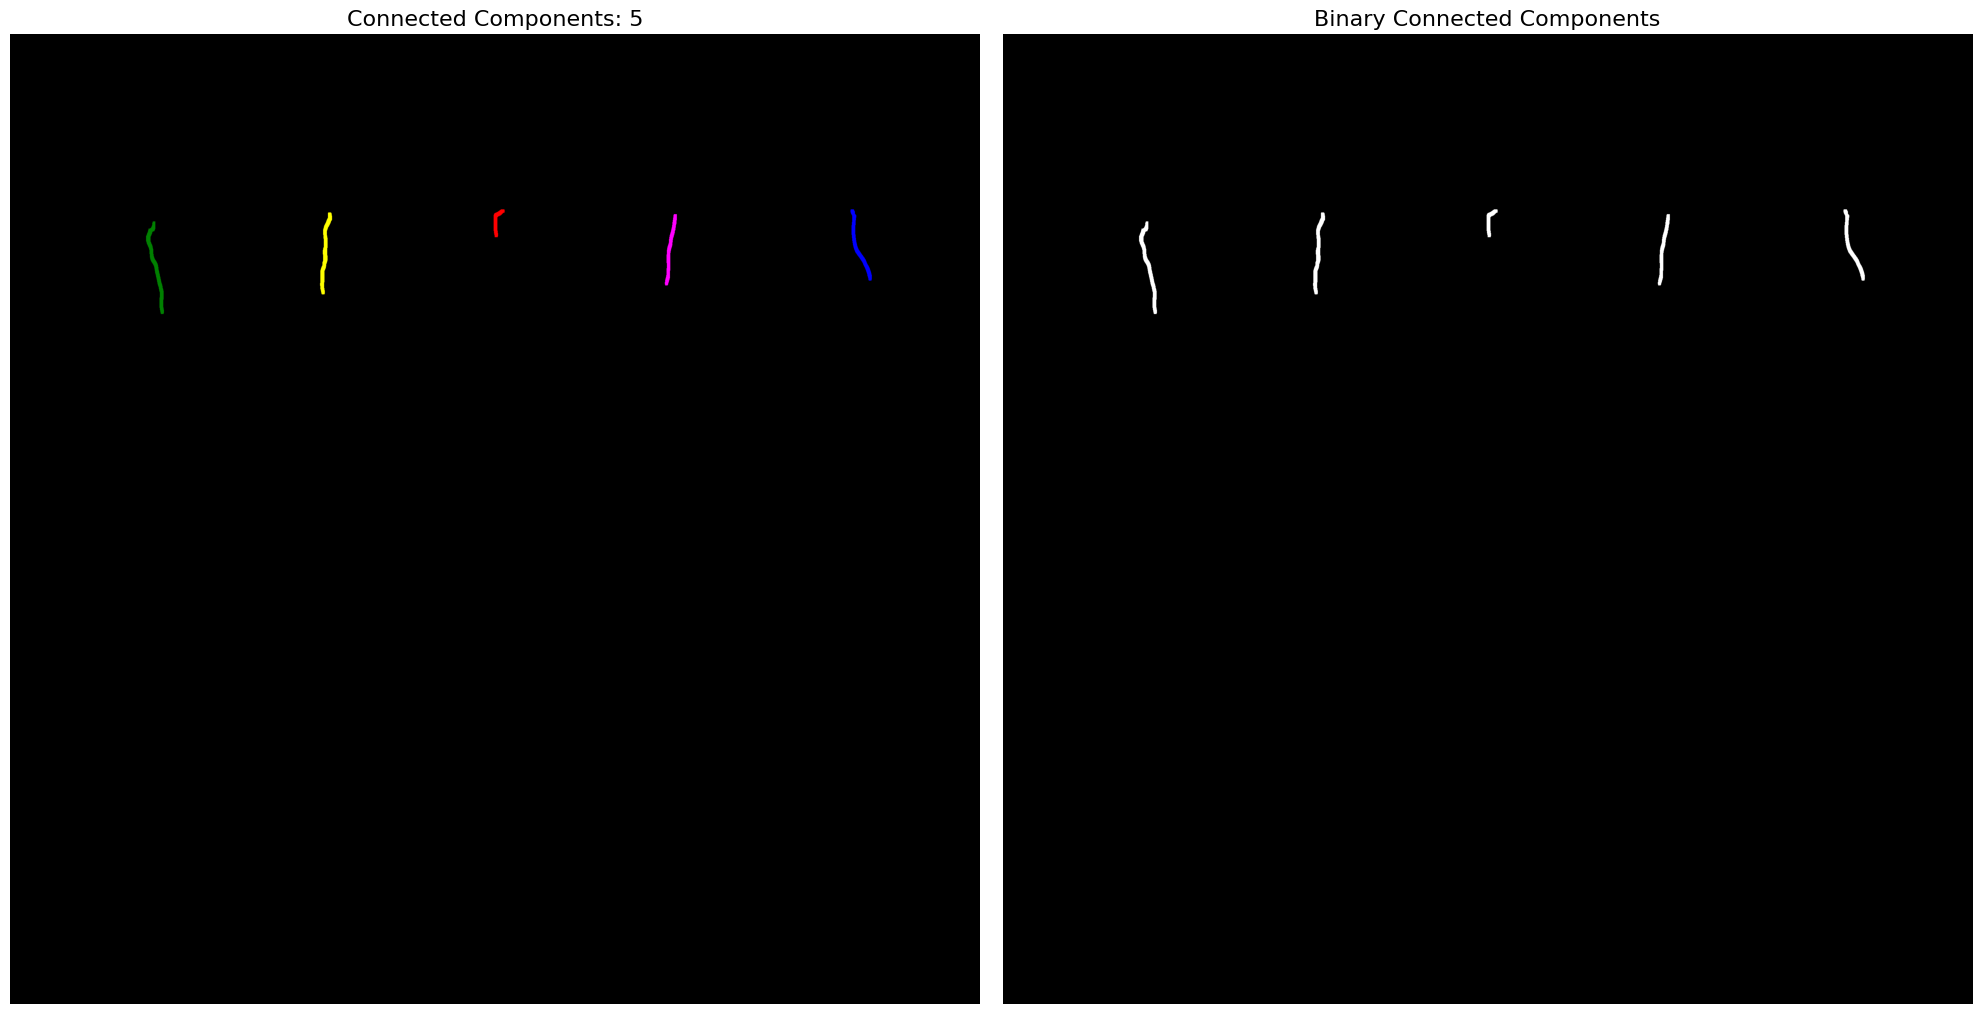

Filename: test_image_6.png | Number of connected components: 9


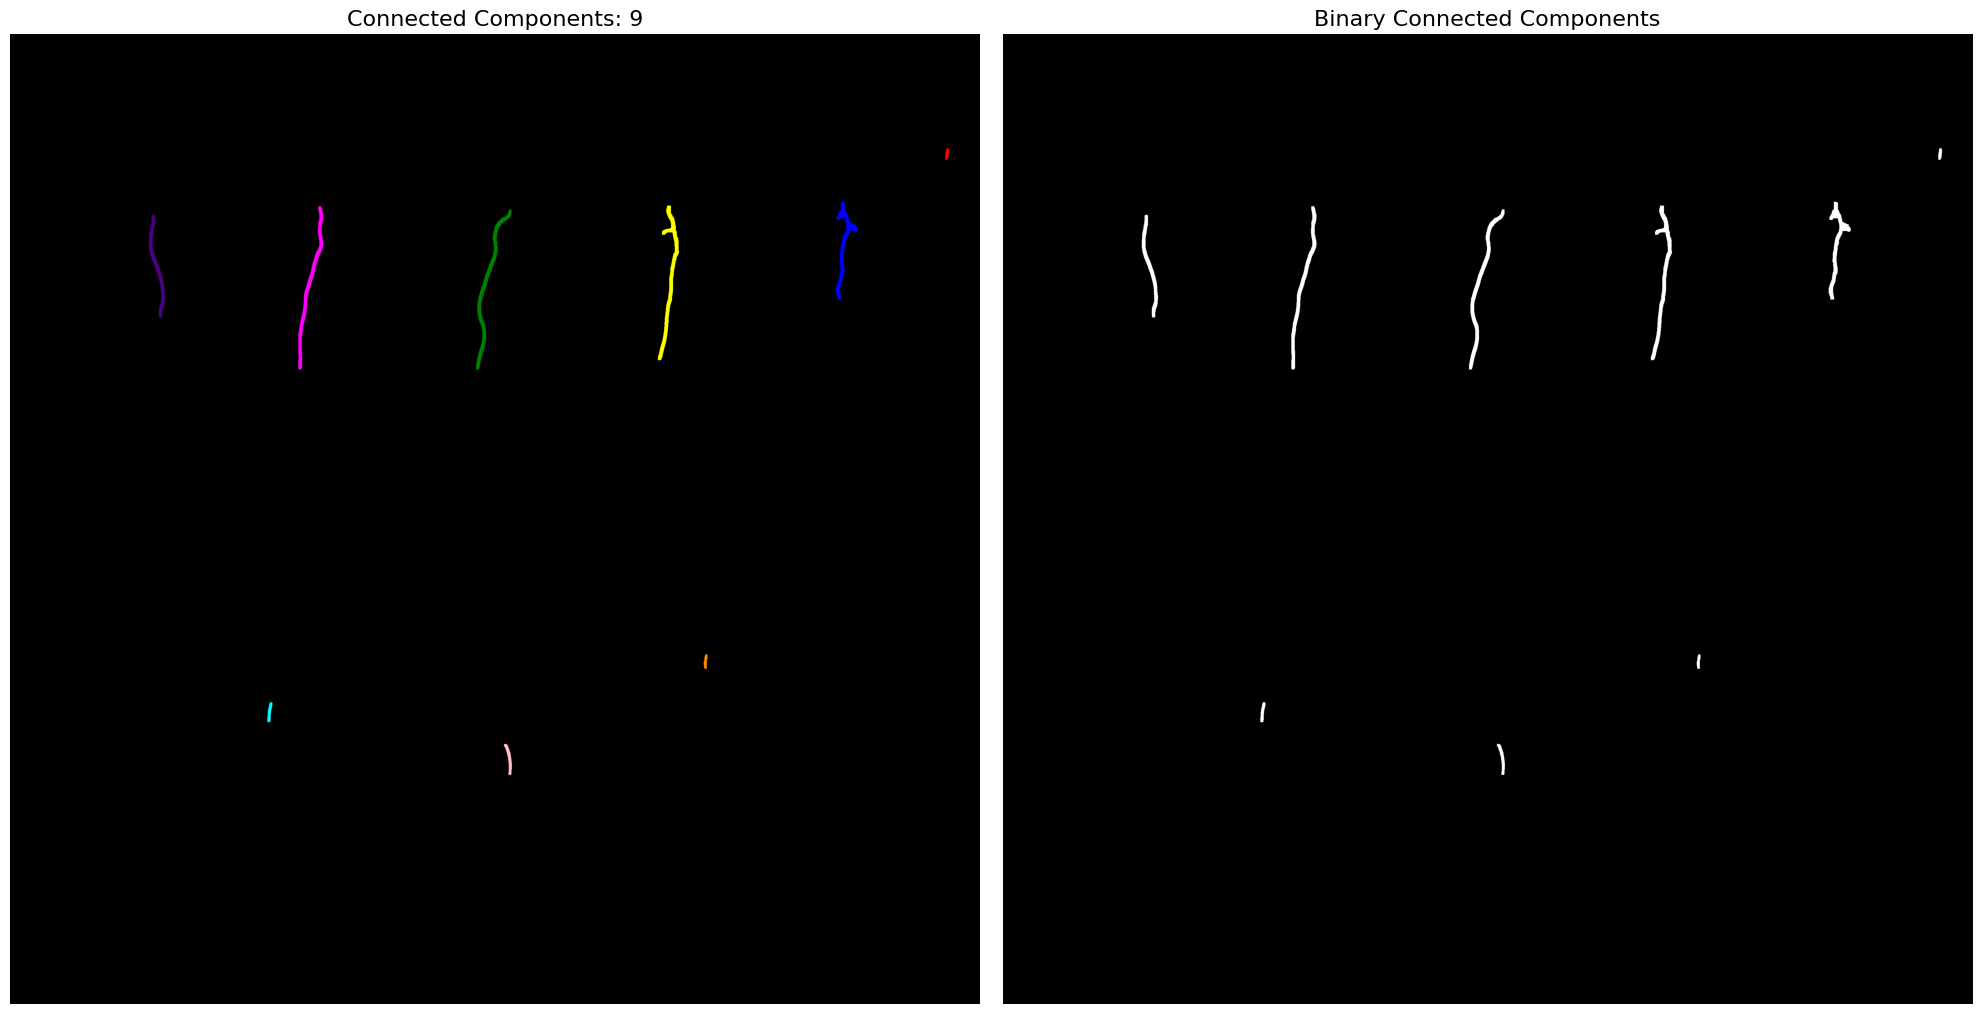

Filename: test_image_7.png | Number of connected components: 6


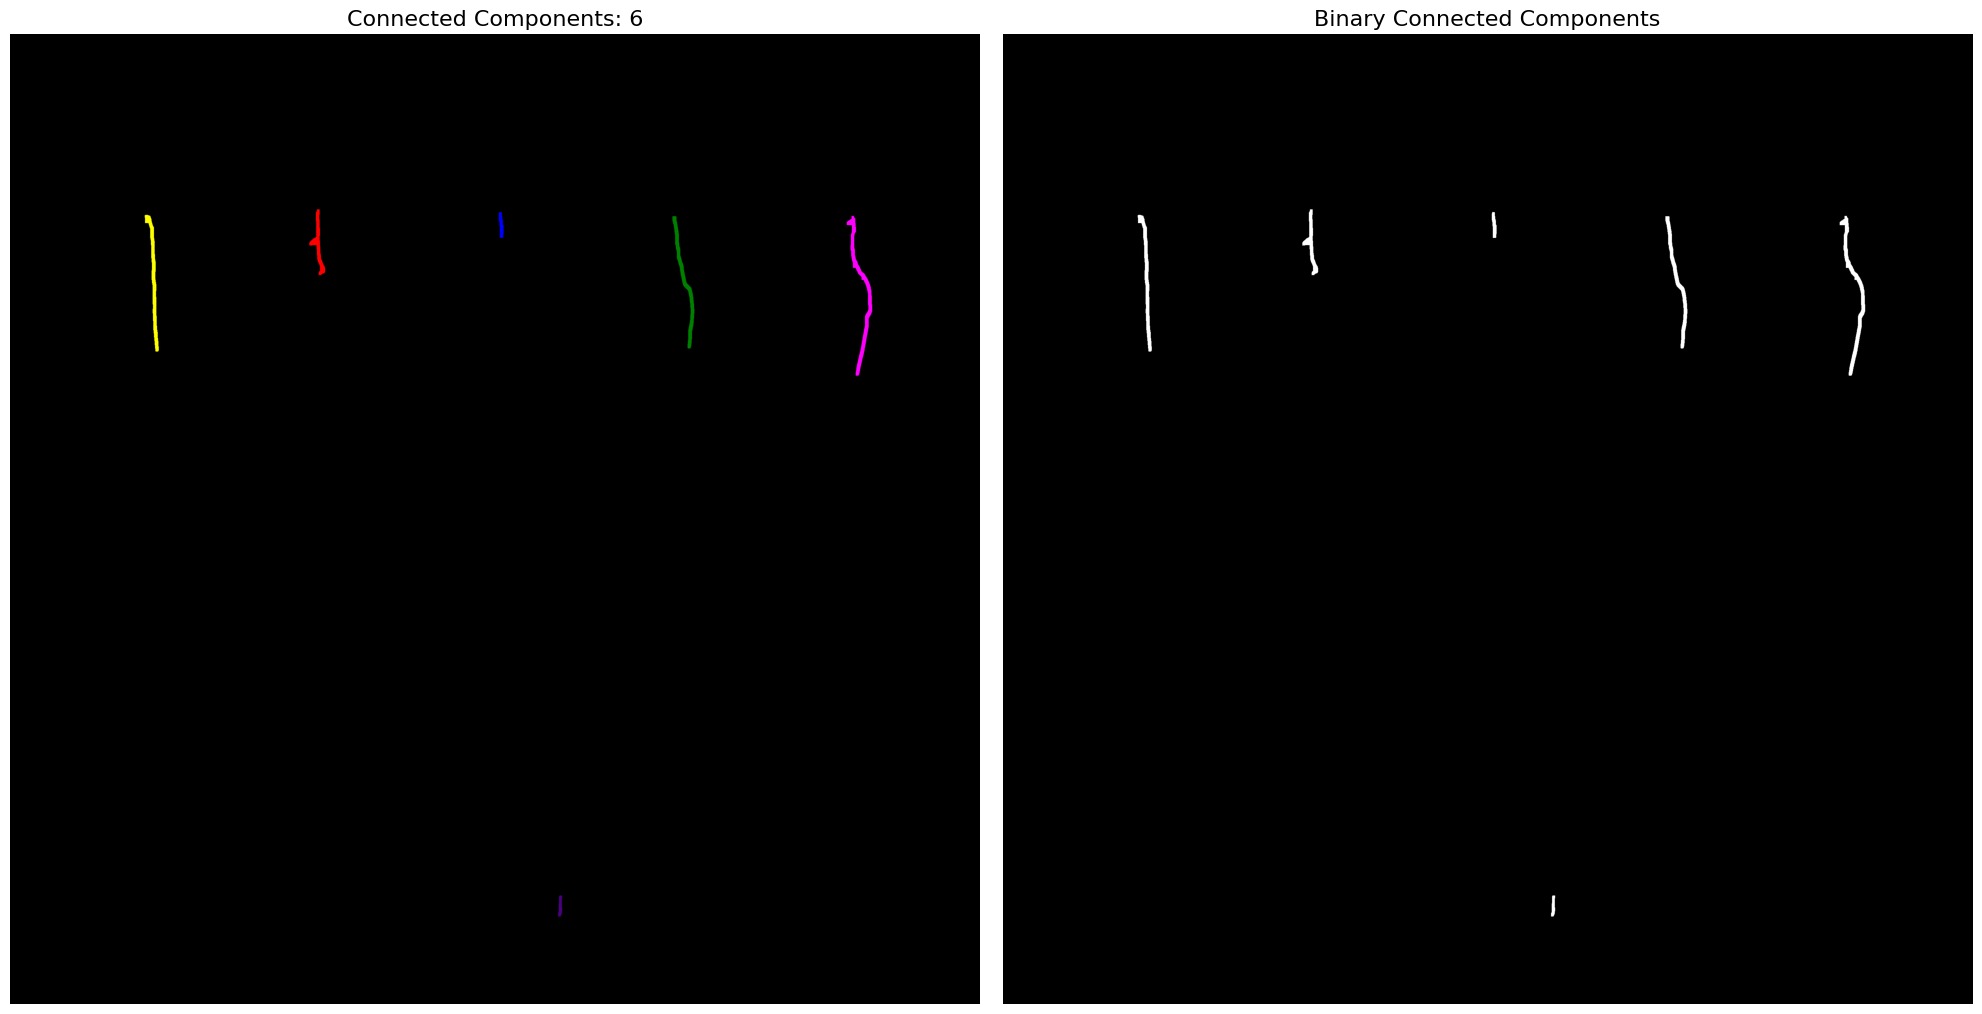

Filename: test_image_8.png | Number of connected components: 12


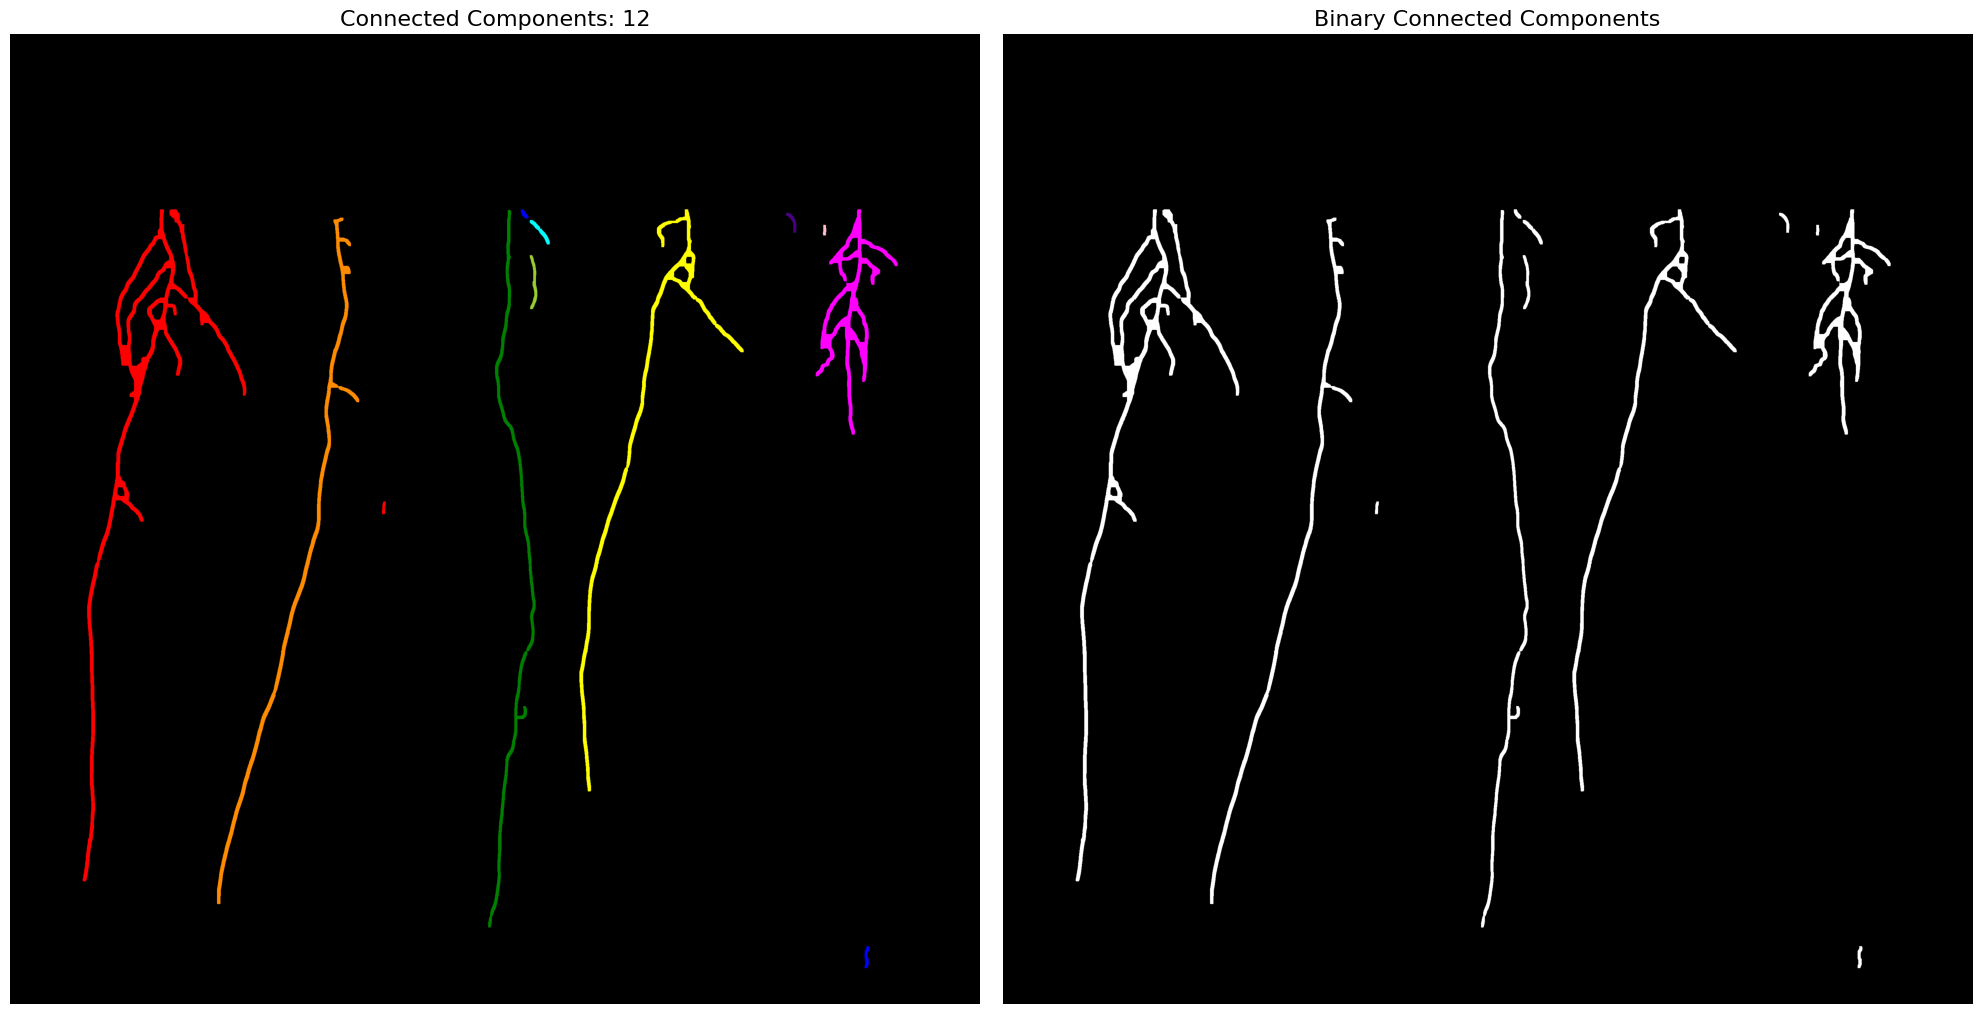

Filename: test_image_9.png | Number of connected components: 22


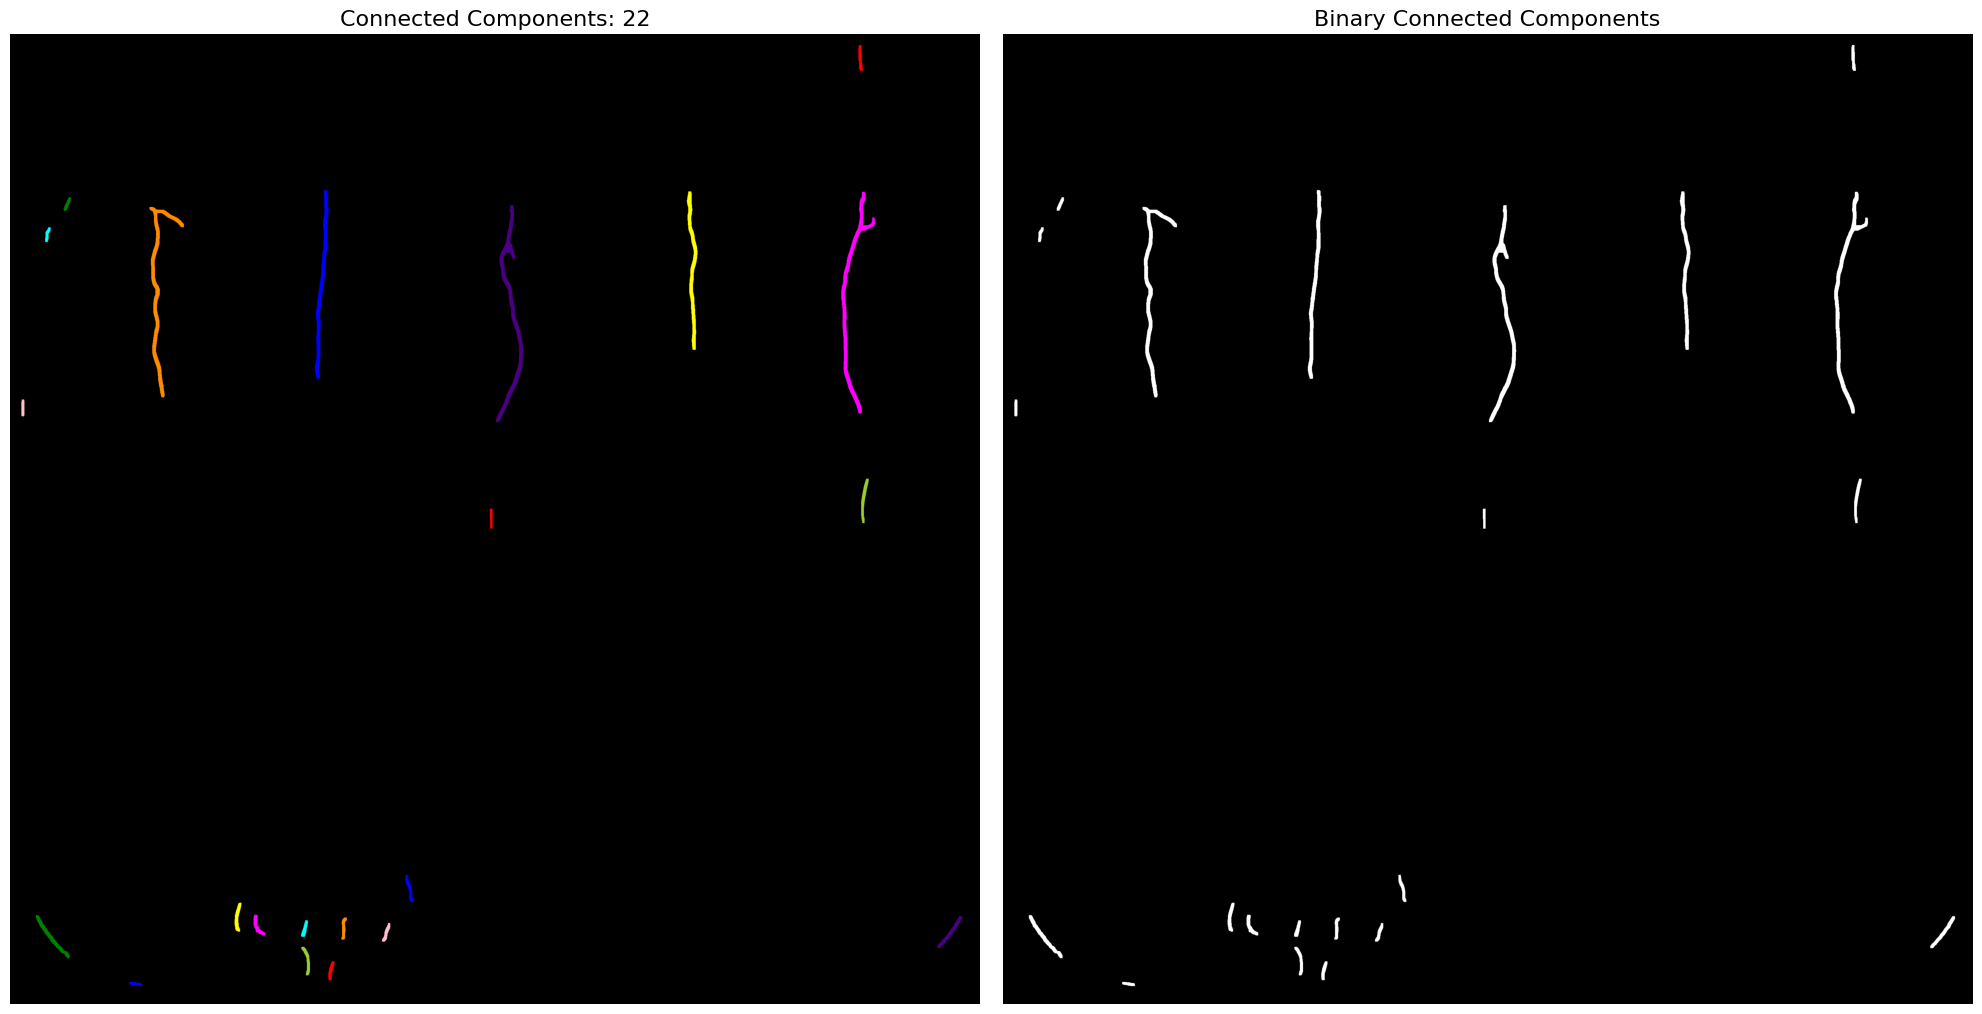

In [50]:
from skimage.measure import label
from skimage.color import label2rgb
import matplotlib.pyplot as plt

# Process connected components for each cleaned mask
for filename, cleaned_mask in processed_masks:
    # Step 1: Label connected components
    labeled_mask = label(cleaned_mask > 0)  # Ensure the mask is binary (True for foreground pixels)

    # Step 2: Count the number of connected components (excluding background)
    num_connected_components = labeled_mask.max()
    print(f"Filename: {filename} | Number of connected components: {num_connected_components}")

    # Step 3: Convert labeled mask to a color image for visualization
    colored_labels = label2rgb(labeled_mask, bg_label=0, bg_color=(0, 0, 0), colors=None)

    # Plot the labeled connected components
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.title(f"Connected Components: {num_connected_components}", fontsize=16)
    plt.imshow(colored_labels)
    plt.axis('off')

    # Step 4: Convert labeled mask back to binary
    binary_labels = (labeled_mask > 0).astype(np.uint8) * 255  # Set all non-zero labels to 255

    # Plot the binary connected components
    plt.subplot(1, 2, 2)
    plt.title("Binary Connected Components", fontsize=16)
    plt.imshow(binary_labels, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


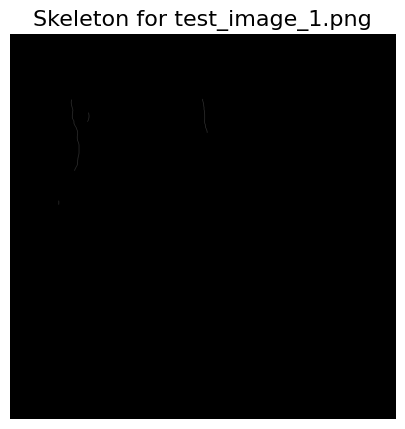

Branch data for test_image_1.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0          557       262.325902            0   
1            1            5          834       564.149278            0   
2            2          196          391        72.627417            0   
3            3          835          863        29.242641            0   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                475               1406   
1               1.0                0.0                480                449   
2               1.0                0.0                575                572   
3               1.0                0.0               1219                355   

   image-coord-dst-0  image-coord-dst-1  coord-src-0  coord-src-1  \
0                722               1437          475         1406   
1                999                470          480    

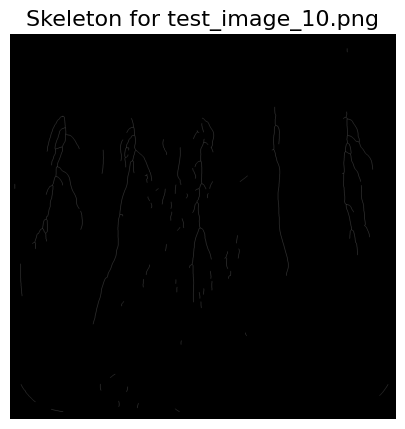

Branch data for test_image_10.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0           27        27.828427            0   
1            1           28          646       143.698485            1   
2            2           64          175        41.899495            1   
3            3          123          141         5.828427            1   
4            3          141         3371       311.249783            1   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                105               2459   
1               1.0                0.0                533               1932   
2               1.0                0.0                568               2456   
3               1.0                0.0                598                386   
4               1.0                0.0                603                384   

   image-coord-dst-0  image-coord-dst-1

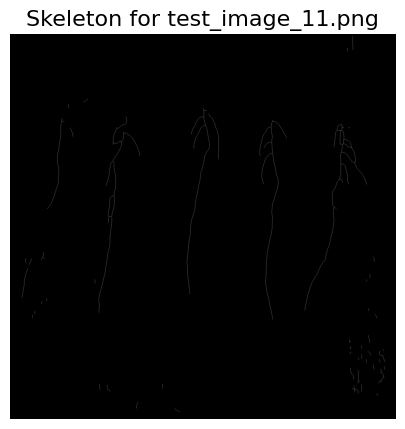

Branch data for test_image_11.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0          112       100.727922            0   
1            1           83          124        28.071068            0   
2            2          126          157        42.112698            0   
3            3          159          189        31.071068            0   
4            4          188          204        16.242641            1   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                 17               2500   
1               1.0                0.0                100               2461   
2               1.0                0.0                474                566   
3               1.0                0.0                514                427   
4               1.0                0.0                542               1412   

   image-coord-dst-0  image-coord-dst-1

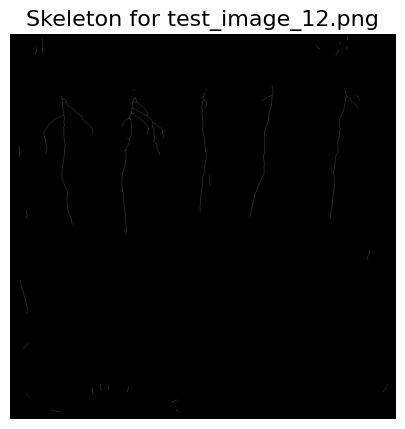

Branch data for test_image_12.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0           38        29.414214            0   
1            1           21          310       111.071068            0   
2            2           52           94        22.242641            0   
3            3           97          203        48.183766            0   
4            4          116          224        29.485281            0   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                 13               2461   
1               1.0                0.0                 34                234   
2               1.0                0.0                 55               2406   
3               1.0                0.0                 78               2228   
4               1.0                0.0                 87               2461   

   image-coord-dst-0  image-coord-dst-1

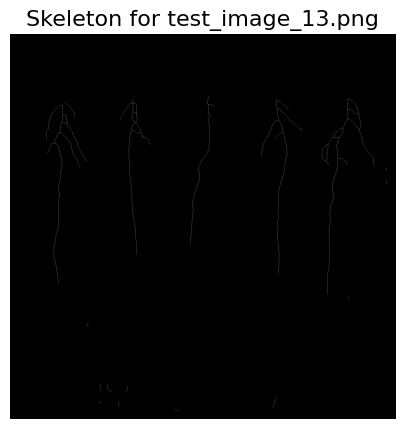

Branch data for test_image_13.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            1          356        72.455844            1   
1            1           22          214        32.313708            1   
2            2           24           42         6.242641            1   
3            3           33          115        14.242641            1   
4            2           42         1343       153.781746            2   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                452               1454   
1               1.0                0.0                473                888   
2               1.0                0.0                473               2464   
3               1.0                0.0                476               1949   
4               1.0                0.0                478               2467   

   image-coord-dst-0  image-coord-dst-1

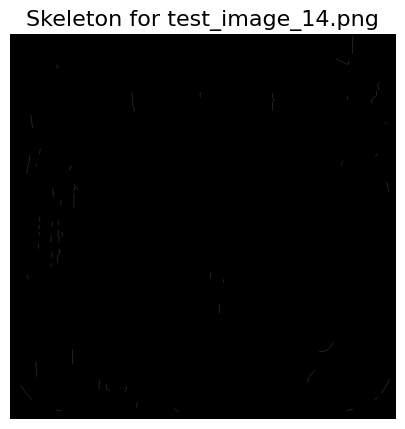

Branch data for test_image_14.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0          125       129.142136            0   
1            1          126          161       134.053824            0   
2            2          242          270        30.485281            0   
3            3          271          330        68.941125            0   
4            4          331          641       108.497475            0   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                 17               2501   
1               1.0                0.0                179               2375   
2               1.0                0.0                225                342   
3               1.0                0.0                350               2699   
4               1.0                0.0                419               2677   

   image-coord-dst-0  image-coord-dst-1

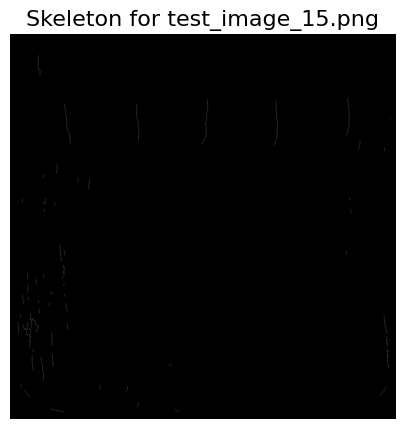

Branch data for test_image_15.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0          144       149.384776            1   
1            0          144          146         1.000000            2   
2            0          144          146         2.414214            2   
3            0          146          151         6.828427            1   
4            1          153         1419       298.710678            0   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                155                208   
1               1.0                0.0                293                219   
2               1.0                0.0                293                219   
3               1.0                0.0                294                219   
4               1.0                0.0                462               2468   

   image-coord-dst-0  image-coord-dst-1

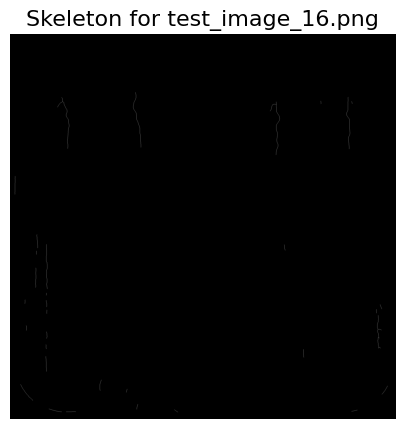

Branch data for test_image_16.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0         1638       438.208153            0   
1            1           36         1673       404.852814            0   
2            2           39          140        33.485281            1   
3            3          119          269        24.071068            0   
4            4          133          264        20.071068            0   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                426                915   
1               1.0                0.0                461               2467   
2               1.0                0.0                463                377   
3               1.0                0.0                489               2268   
4               1.0                0.0                492               2491   

   image-coord-dst-0  image-coord-dst-1

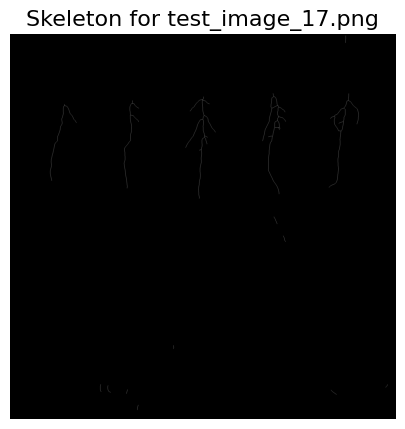

Branch data for test_image_17.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0           53        54.242641            0   
1            1           54           99        25.485281            1   
2            2           56          255        51.656854            1   
3            1           99          891        98.941125            2   
4            1           99          617        80.284271            2   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                 11               2450   
1               1.0                0.0                434               1918   
2               1.0                0.0                435               2472   
3               1.0                0.0                457               1924   
4               1.0                0.0                457               1924   

   image-coord-dst-0  image-coord-dst-1

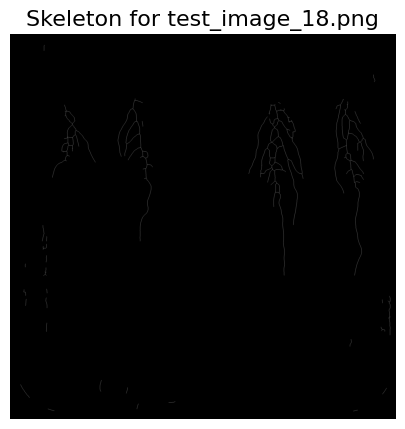

Branch data for test_image_18.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            1           42        44.071068            0   
1            1           43           96        59.627417            0   
2            2           97          121        13.828427            1   
3            3          108          317        54.526912            1   
4            2          121          537        68.213203            2   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                 81                253   
1               1.0                0.0                297               2653   
2               1.0                0.0                472                913   
3               1.0                0.0                478               2434   
4               1.0                0.0                485                911   

   image-coord-dst-0  image-coord-dst-1

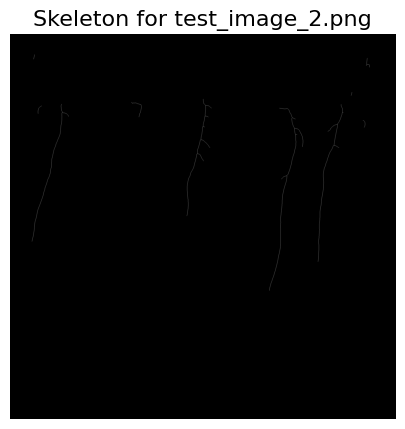

Branch data for test_image_2.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0           40        37.313708            0   
1            1           27           81        48.485281            1   
2            1           81          127        38.071068            1   
3            1           81          115        12.071068            1   
4            2          128          152        27.899495            0   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                150                180   
1               1.0                0.0                176               2607   
2               1.0                0.0                222               2603   
3               1.0                0.0                222               2603   
4               1.0                0.0                425               2495   

   image-coord-dst-0  image-coord-dst-1 

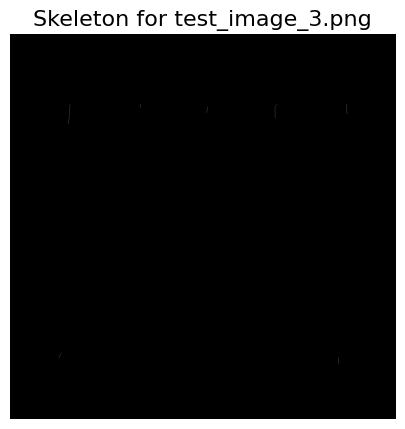

Branch data for test_image_3.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            1          359       114.698485            0   
1            1            2           21         4.414214            1   
2            2            3          403       152.798990            0   
3            3            4          108        24.656854            0   
4            1           17           21         4.414214            1   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                512               1951   
1               1.0                0.0                512               2456   
2               1.0                0.0                513                439   
3               1.0                0.0                513                950   
4               1.0                0.0                515               2459   

   image-coord-dst-0  image-coord-dst-1 

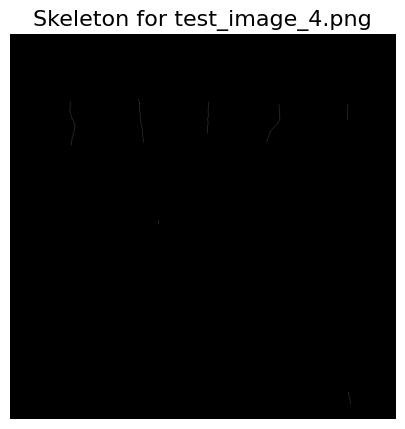

Branch data for test_image_4.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0           68        42.556349            1   
1            1           23         1056       243.355339            0   
2            2           28         1277       345.580736            0   
3            0           68           77         6.414214            1   
4            0           68         1259       300.083261            1   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                472                934   
1               1.0                0.0                494               1453   
2               1.0                0.0                497                441   
3               1.0                0.0                510                945   
4               1.0                0.0                510                945   

   image-coord-dst-0  image-coord-dst-1 

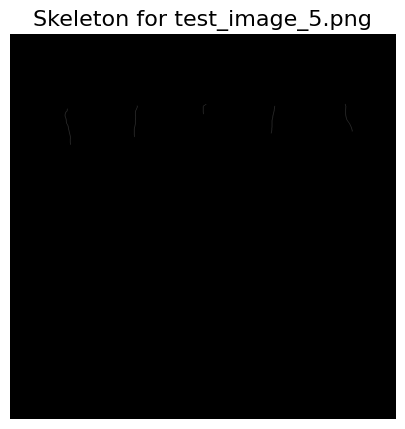

Branch data for test_image_5.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0          826       223.610173            0   
1            1            5          316        86.041631            0   
2            2           30          920       241.254834            0   
3            3           38          868       211.597980            0   
4            4          116          977       290.024387            0   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                512               2446   
1               1.0                0.0                514               1431   
2               1.0                0.0                524                927   
3               1.0                0.0                526               1932   
4               1.0                0.0                546                419   

   image-coord-dst-0  image-coord-dst-1 

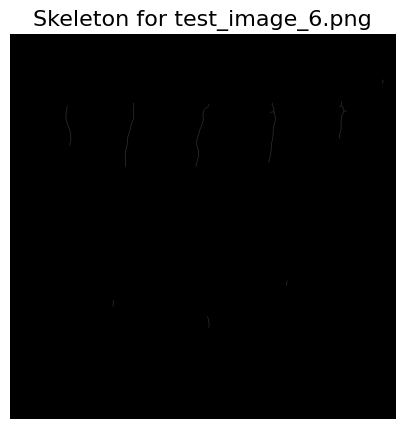

Branch data for test_image_6.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0           27        29.071068            0   
1            1           28          121        35.242641            1   
2            2           40          381        72.213203            1   
3            3           42         2035       498.722871            0   
4            4           67         2037       517.190909            0   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                334               2722   
1               1.0                0.0                490               2415   
2               1.0                0.0                502               1912   
3               1.0                0.0                503                898   
4               1.0                0.0                511               1453   

   image-coord-dst-0  image-coord-dst-1 

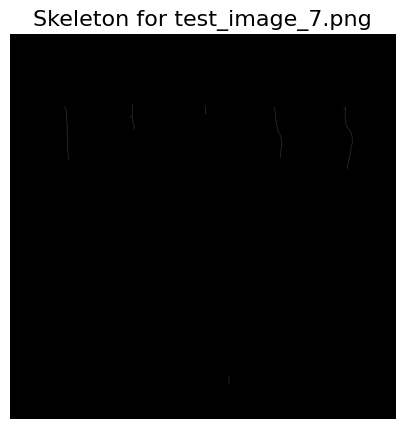

Branch data for test_image_7.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0          394        95.142136            1   
1            1            9          329        69.485281            0   
2            2           26         1444       403.669048            0   
3            3           32          120        19.071068            1   
4            4           48         1426       400.095454            0   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                512                895   
1               1.0                0.0                520               1423   
2               1.0                0.0                529                395   
3               1.0                0.0                530               2447   
4               1.0                0.0                534               1928   

   image-coord-dst-0  image-coord-dst-1 

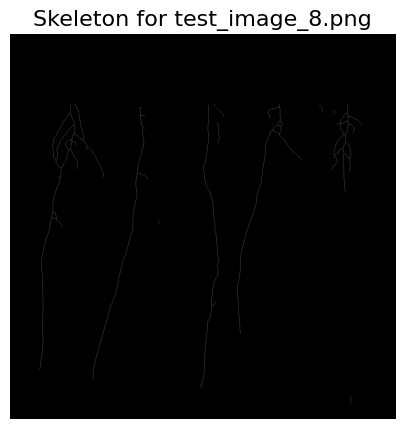

Branch data for test_image_8.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0          125        24.798990            0   
1            1            2          695        76.071068            1   
2            2            4          145        22.242641            1   
3            3            5          631        70.970563            1   
4            1           15           32         2.414214            1   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                512               1488   
1               1.0                0.0                513                442   
2               1.0                0.0                513               1964   
3               1.0                0.0                513               2466   
4               1.0                0.0                516                476   

   image-coord-dst-0  image-coord-dst-1 

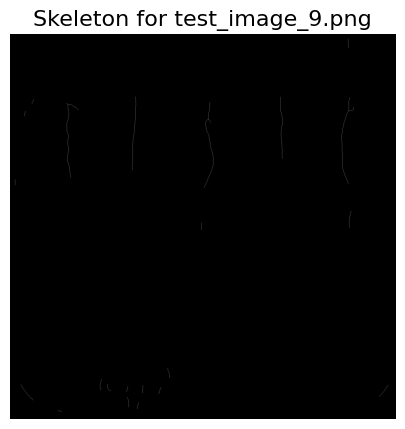

Branch data for test_image_9.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0           69        71.899495            0   
1            1           70         2820       555.225397            0   
2            2           73         2489       472.296465            0   
3            3           80          661       103.556349            1   
4            4          117          265        39.627417            0   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                 34               2469   
1               1.0                0.0                458                915   
2               1.0                0.0                460               1974   
3               1.0                0.0                463               2477   
4               1.0                0.0                476                174   

   image-coord-dst-0  image-coord-dst-1 

In [51]:
from skimage.morphology import skeletonize
from skan import Skeleton, summarize
import matplotlib.pyplot as plt

# Process skeletonization for each binary connected component
skeleton_results = []
for filename, binary_labels in processed_masks:
    # Step 1: Skeletonize the binary mask
    skeleton_object = skeletonize(binary_labels > 0)  # Ensure mask is binary (True for foreground)

    # Step 2: Convert the skeletonized object into a skan Skeleton object
    skeleton_data = Skeleton(skeleton_object)

    # Step 3: Summarize the skeleton's branch data
    branch_data = summarize(skeleton_data)

    # Append results for further use
    skeleton_results.append((filename, skeleton_object, branch_data))

    # Plot the skeletonized mask
    plt.figure(figsize=(10, 5))
    plt.title(f"Skeleton for {filename}", fontsize=16)
    plt.imshow(skeleton_object, cmap='gray')
    plt.axis('off')
    plt.show()

    # Display branch data
    print(f"Branch data for {filename}:")
    print(branch_data.head())  # Display the first few rows of branch data

Processing test_image_1.png...


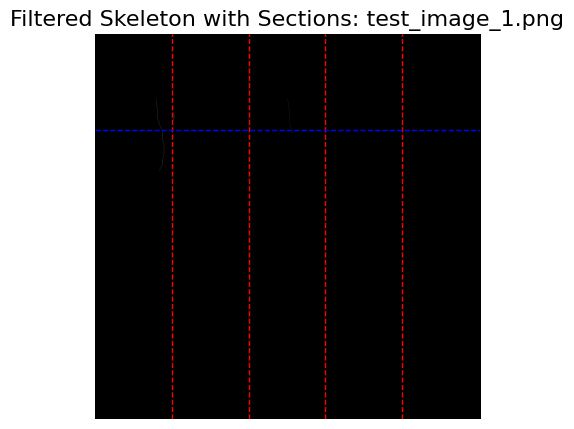

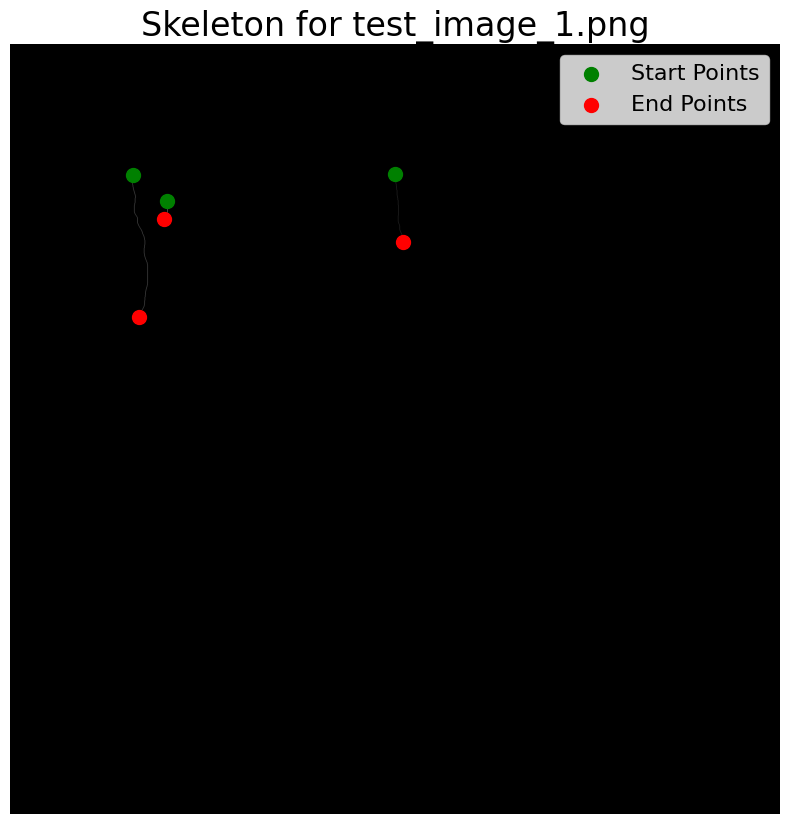

Processing test_image_10.png...


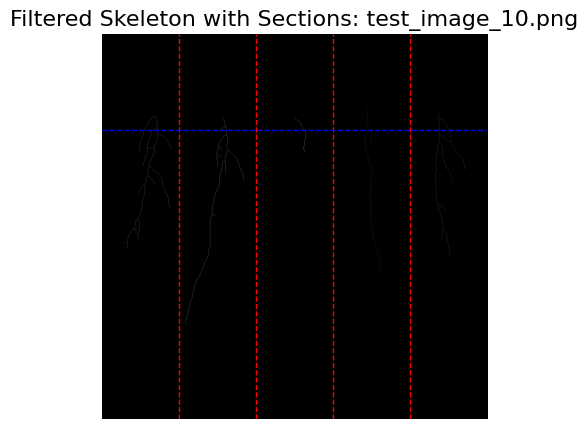

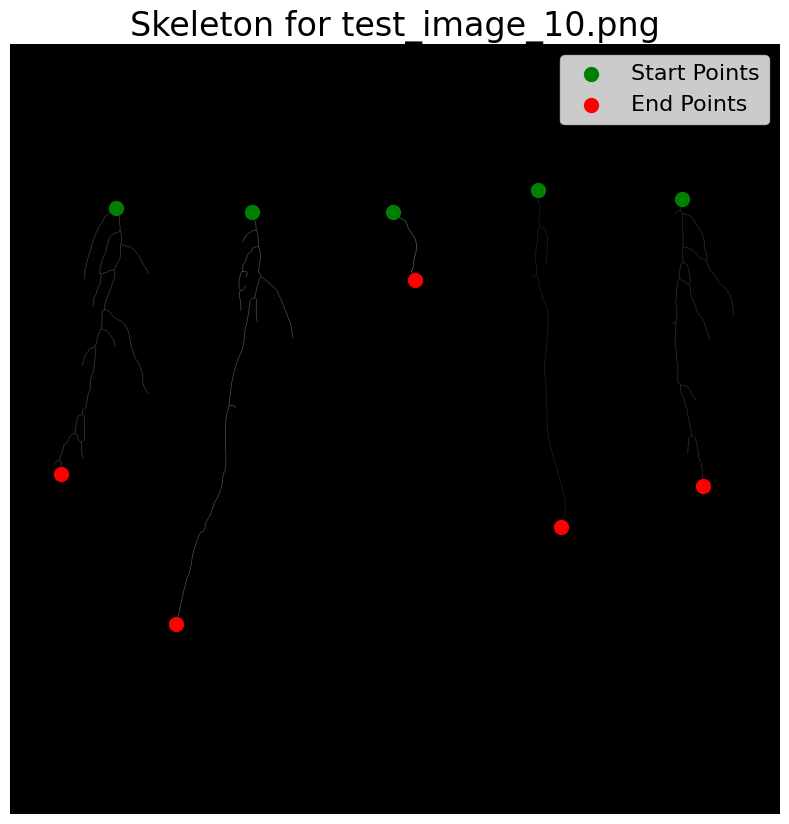

Processing test_image_11.png...


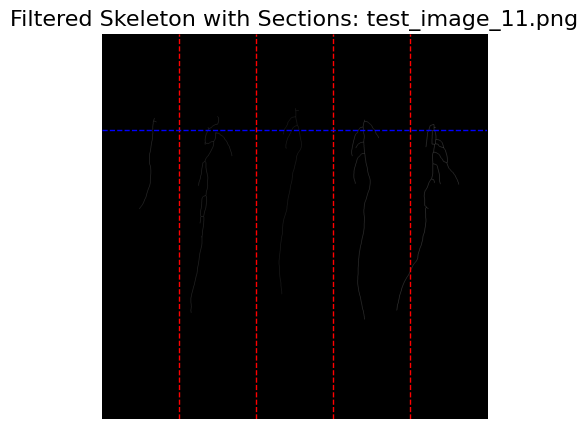

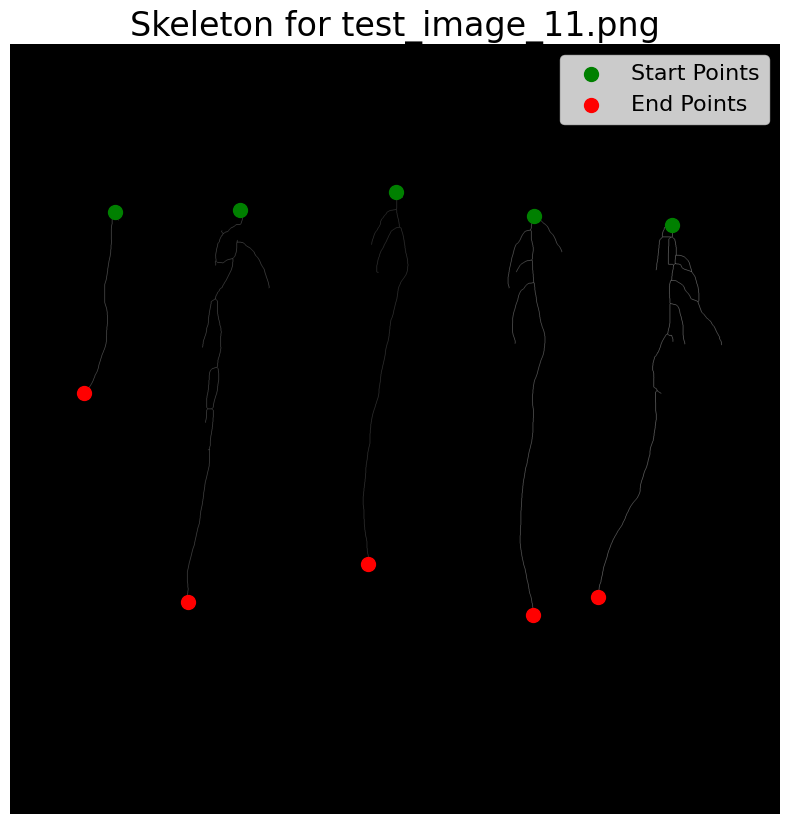

Processing test_image_12.png...


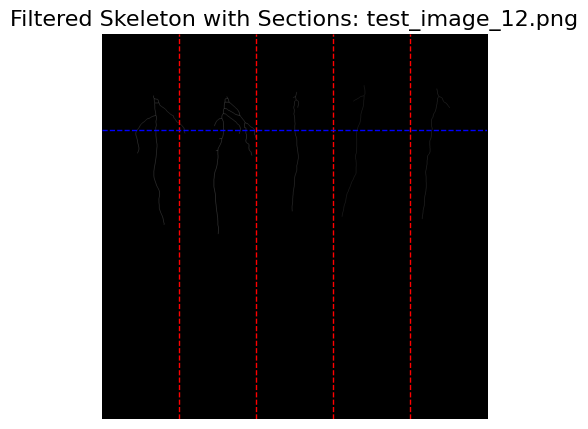

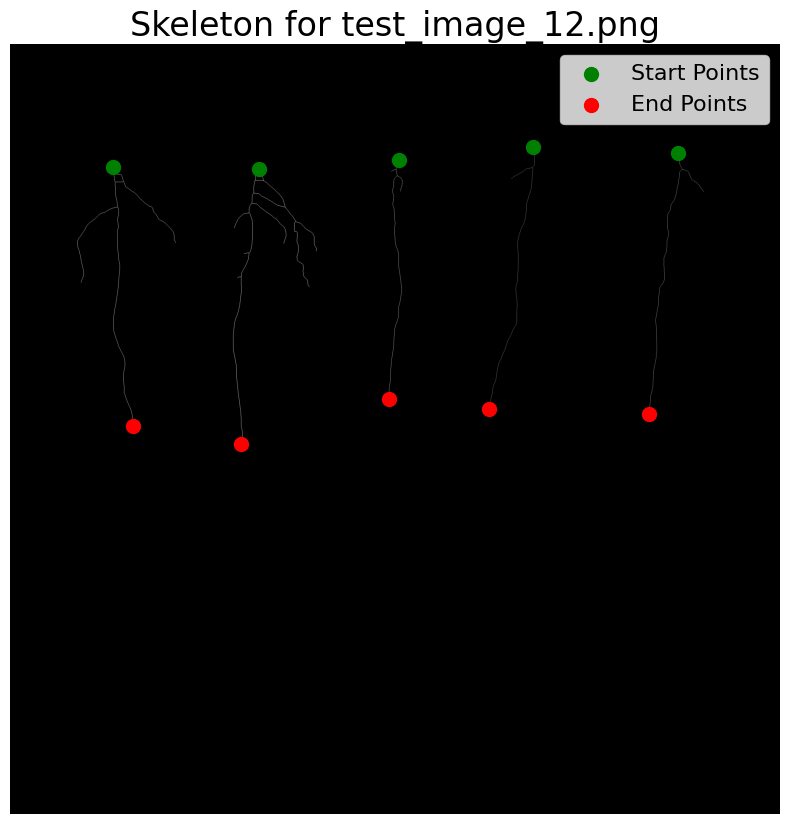

Processing test_image_13.png...


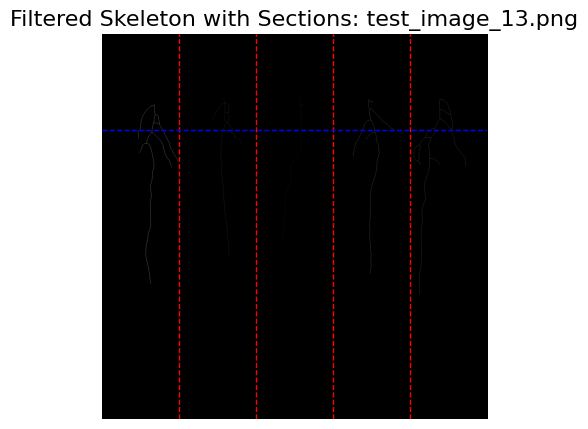

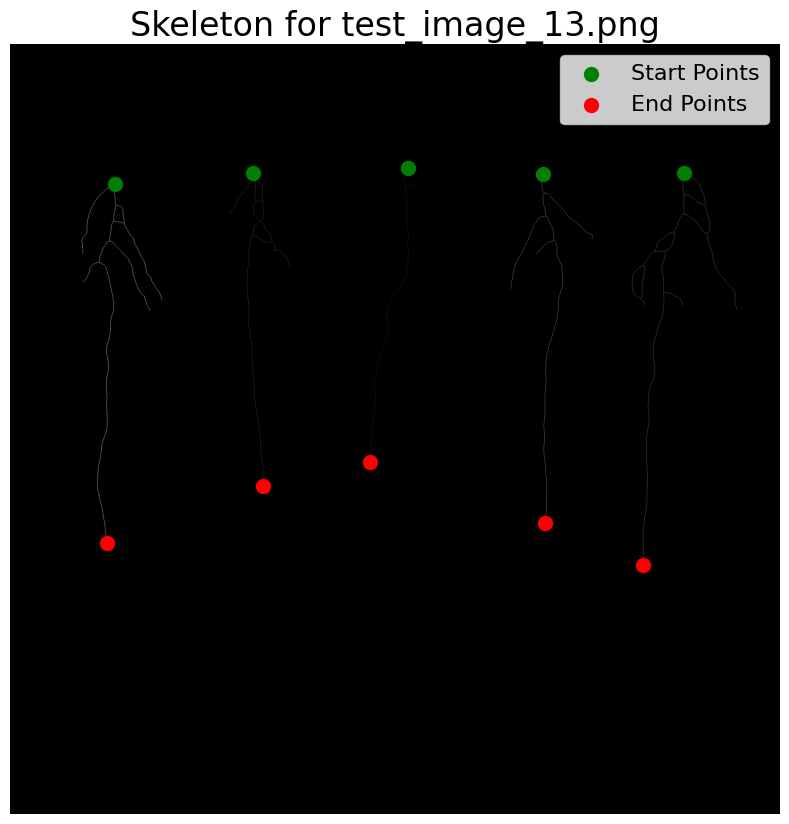

Processing test_image_14.png...


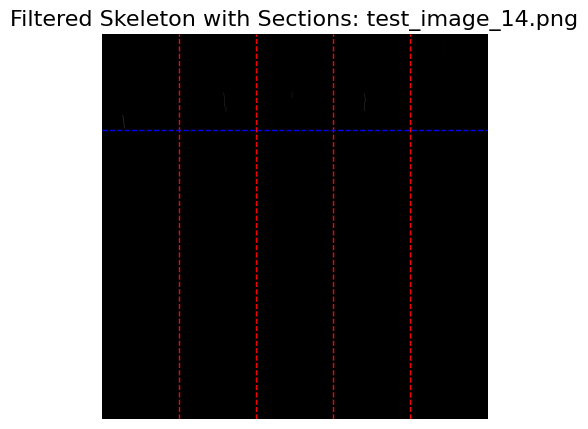

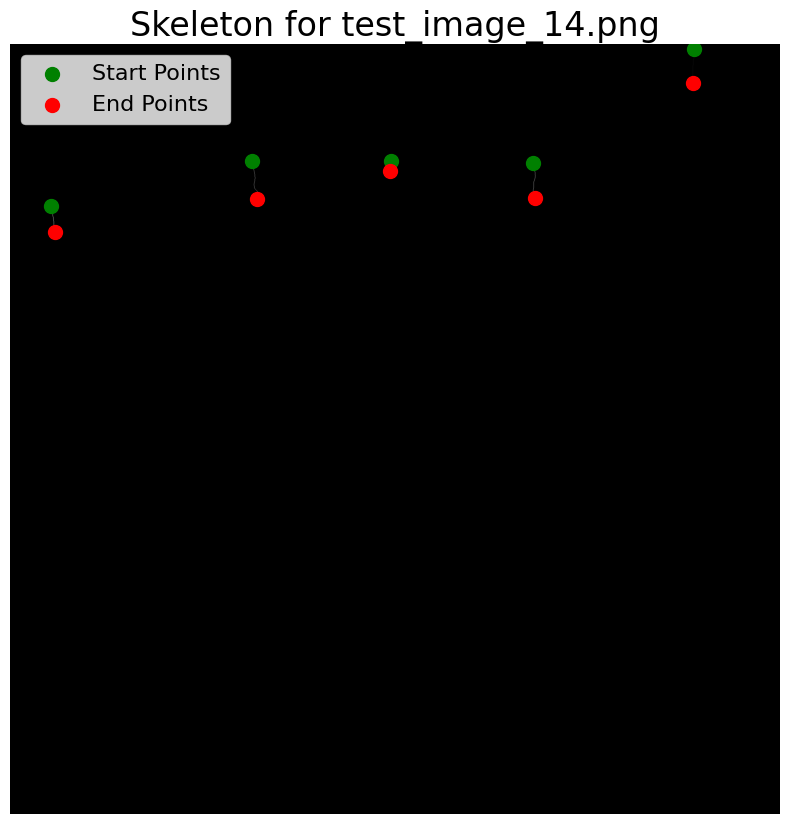

Processing test_image_15.png...


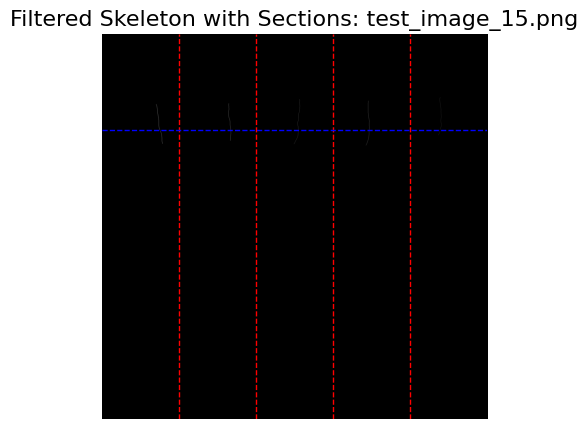

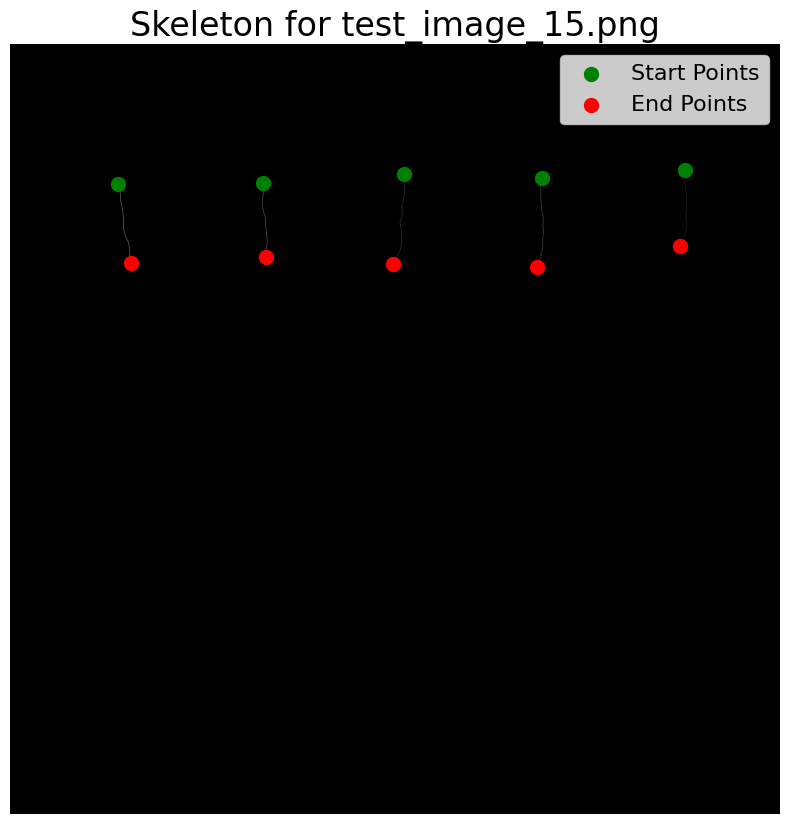

Processing test_image_16.png...


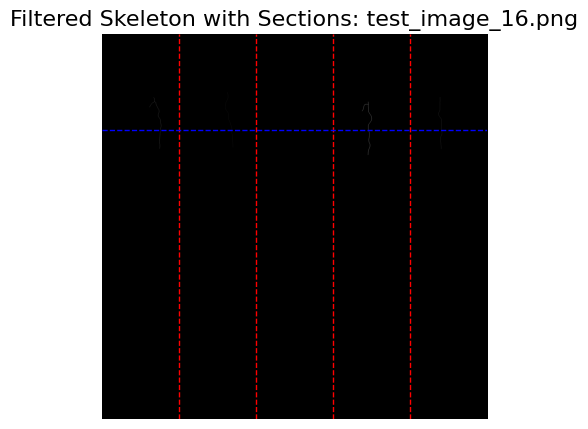

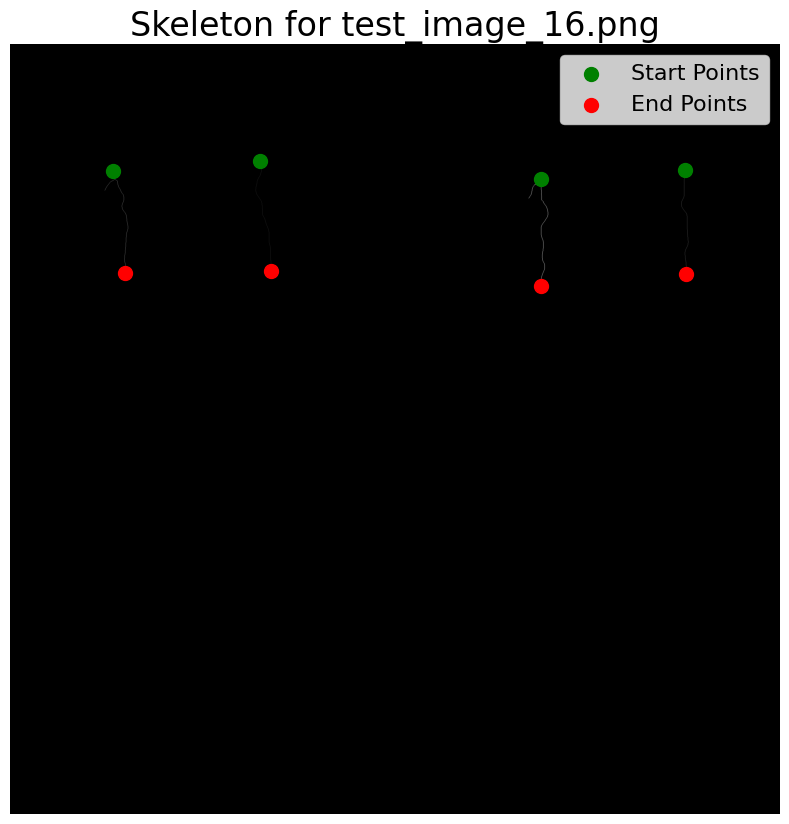

Processing test_image_17.png...


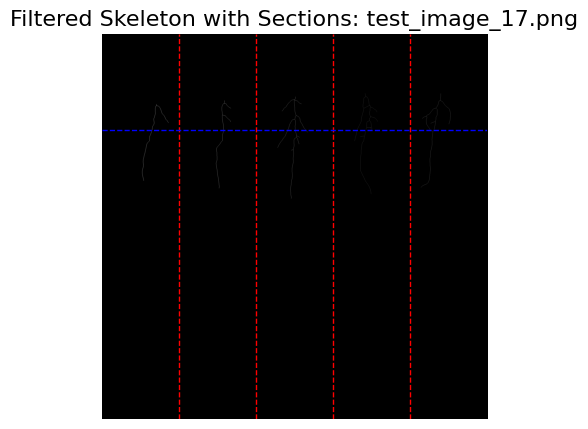

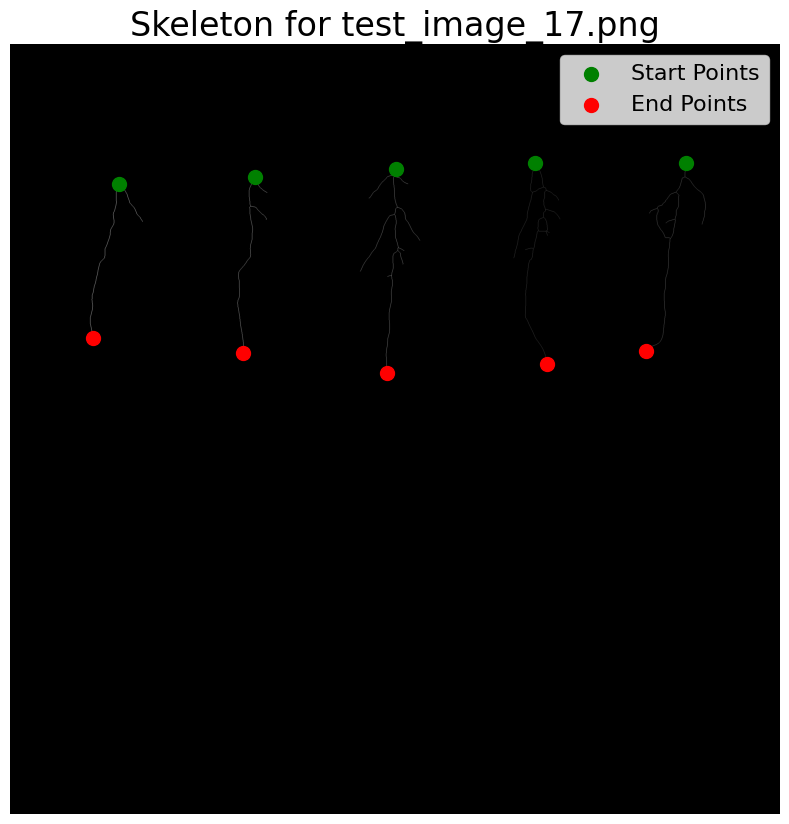

Processing test_image_18.png...


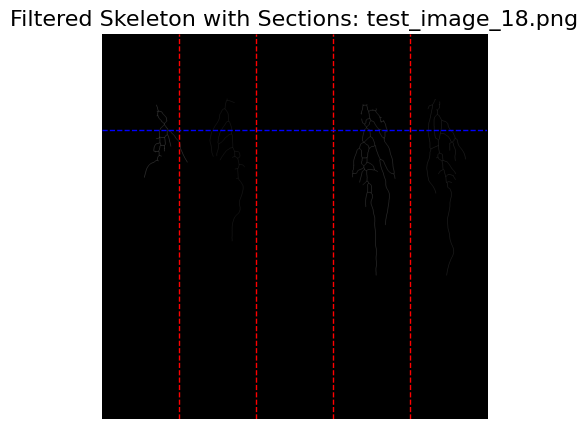

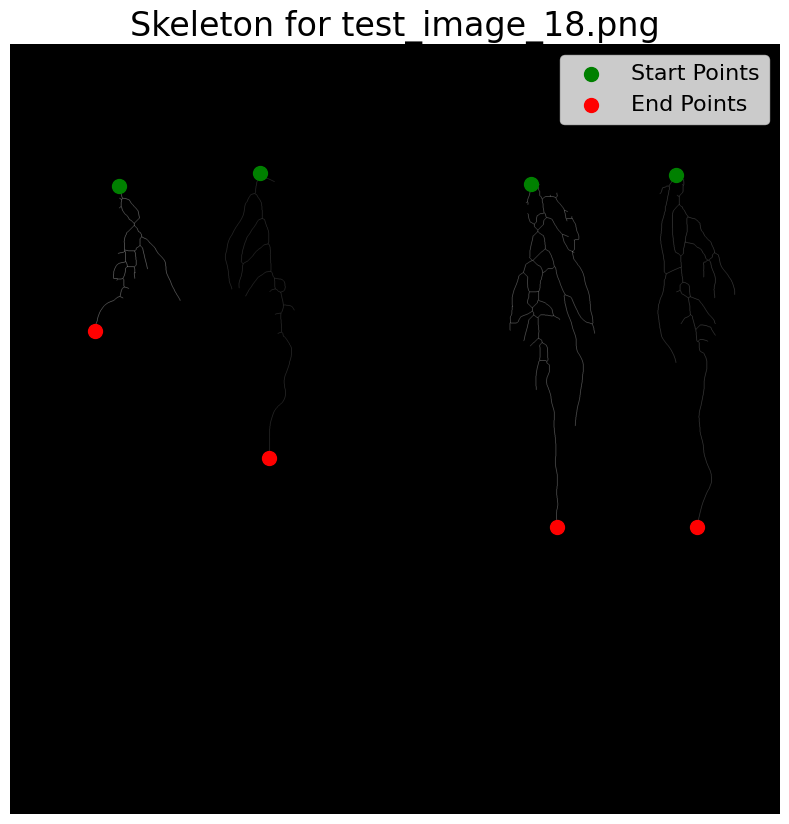

Processing test_image_2.png...


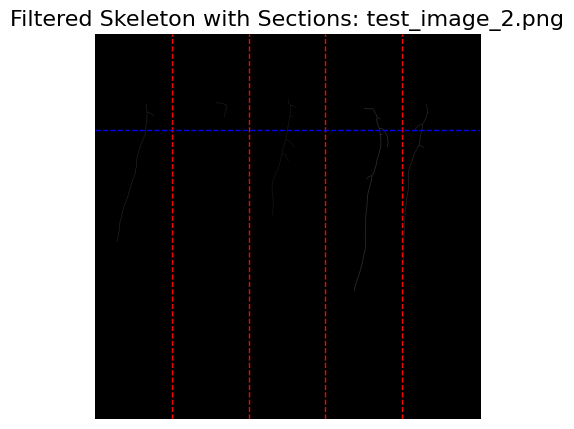

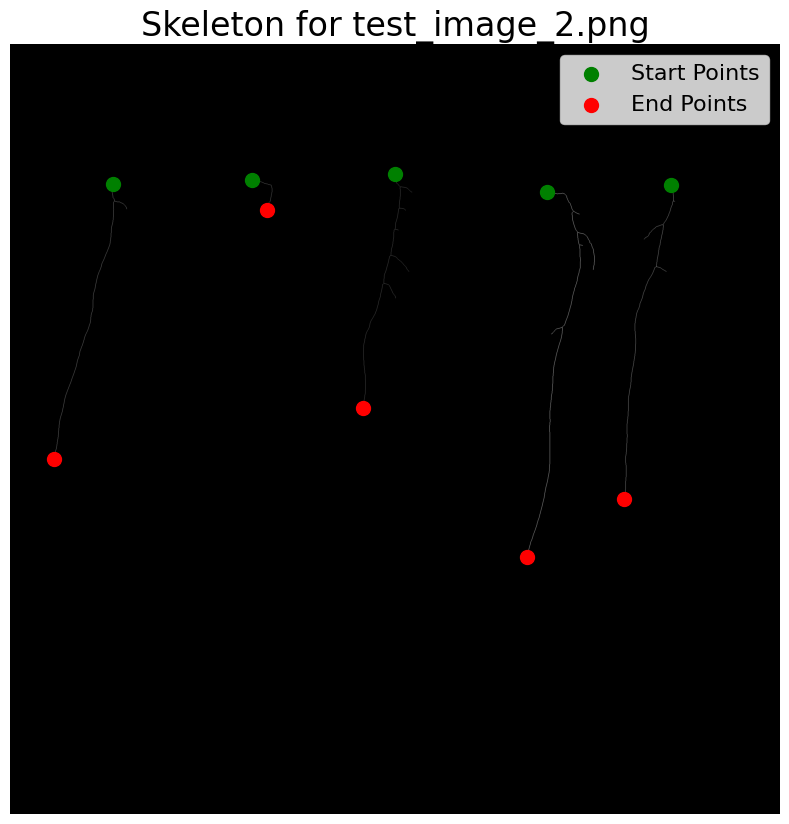

Processing test_image_3.png...


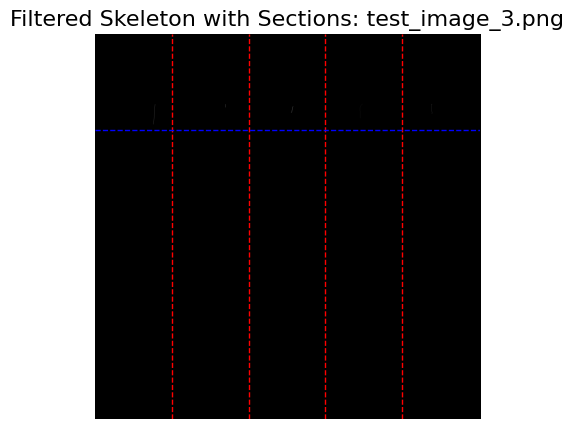

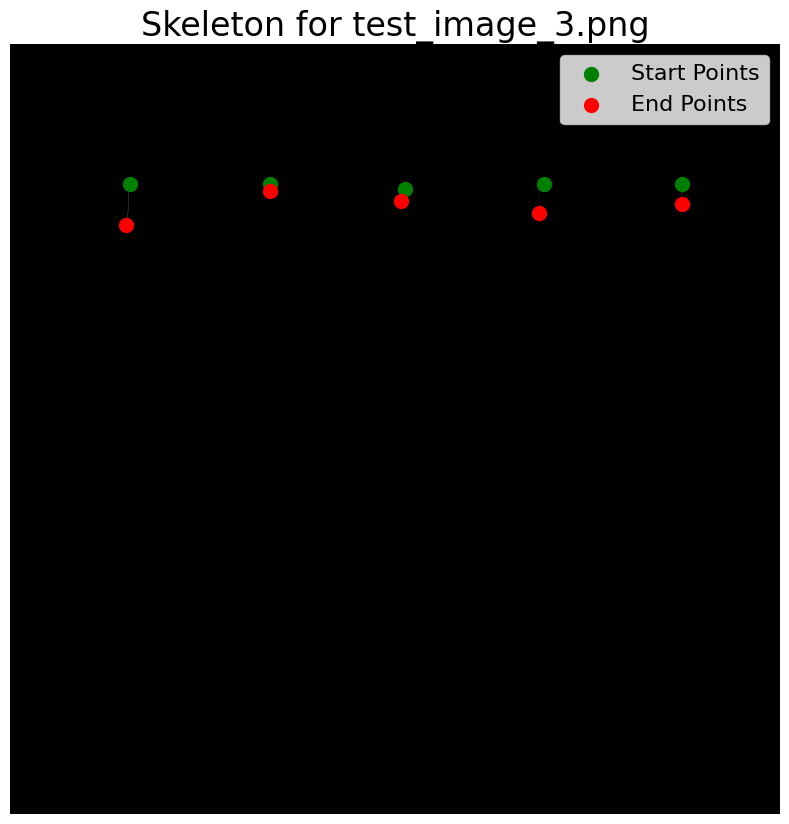

Processing test_image_4.png...


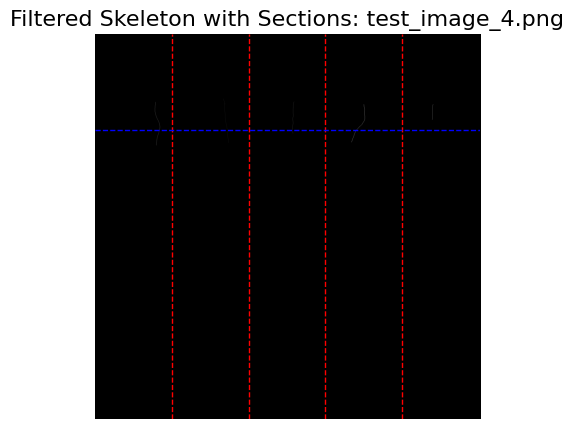

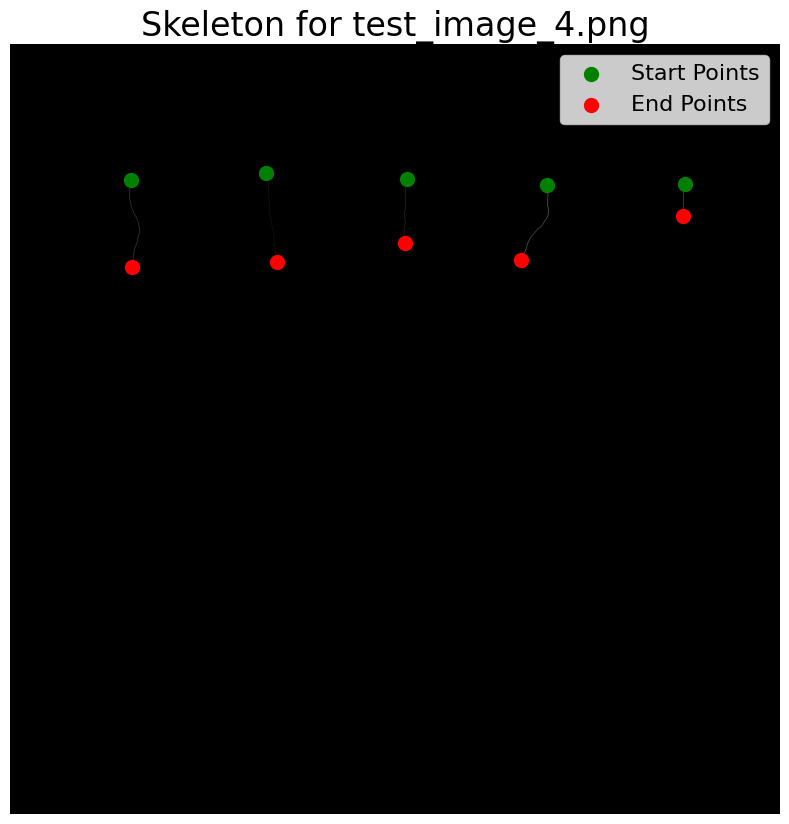

Processing test_image_5.png...


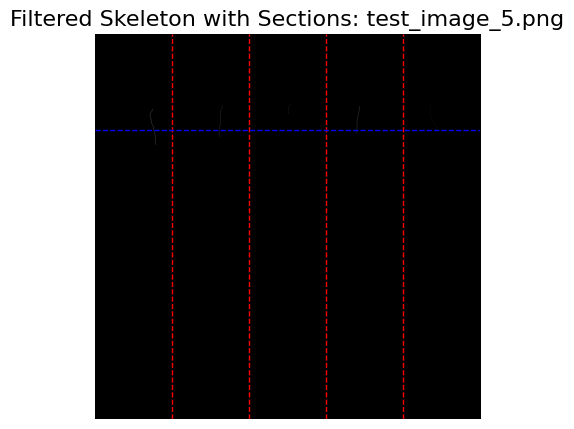

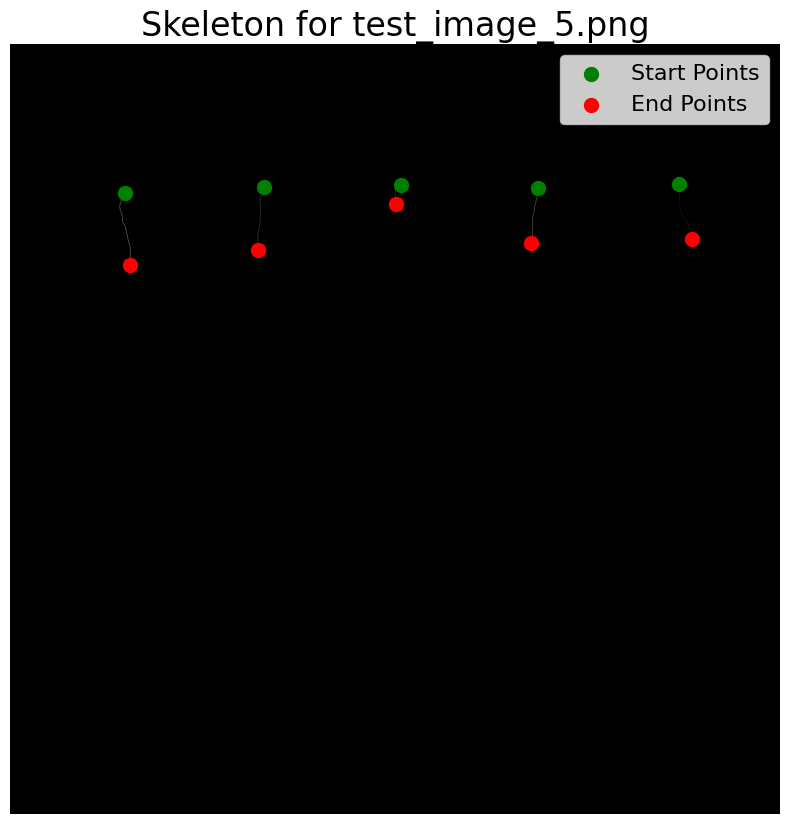

Processing test_image_6.png...


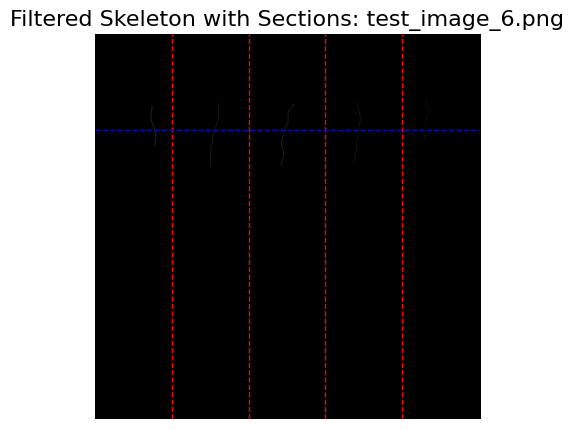

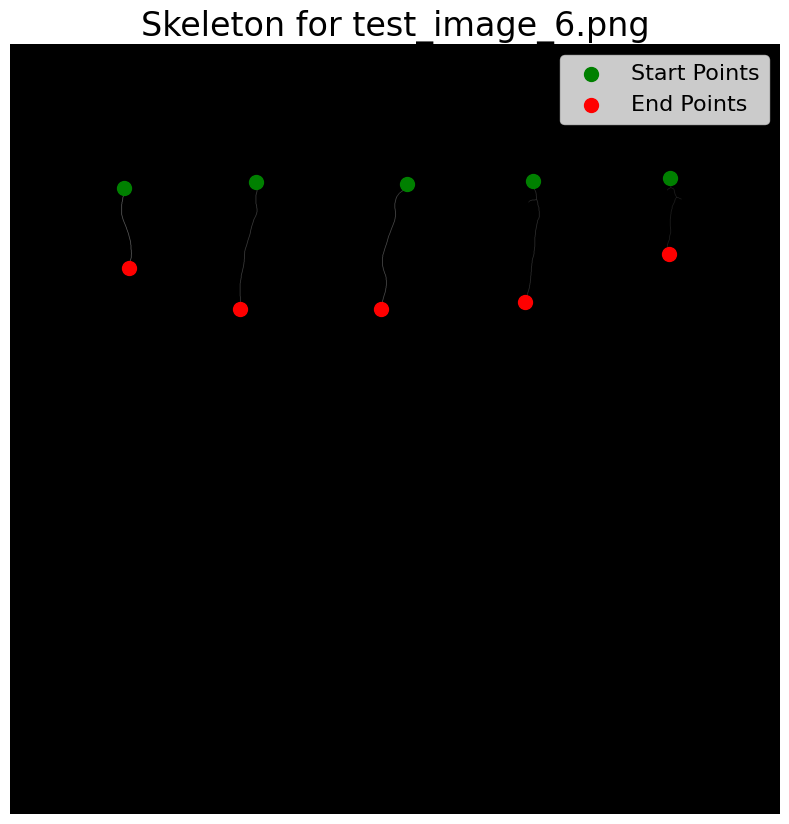

Processing test_image_7.png...


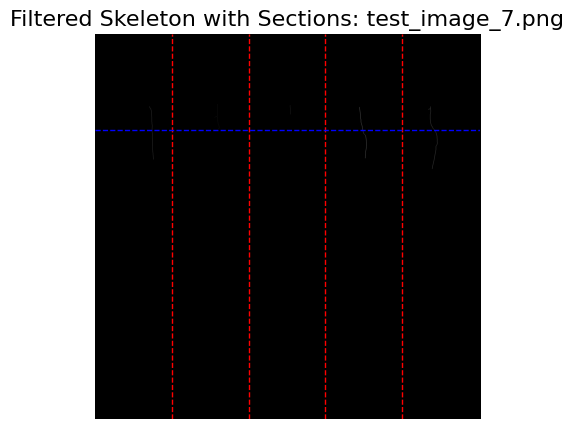

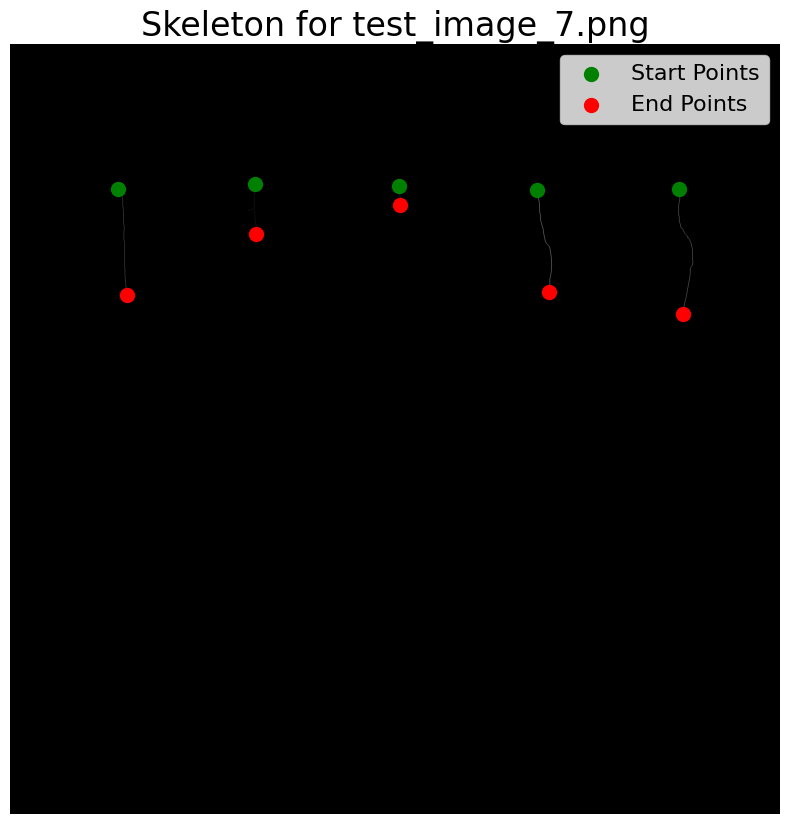

Processing test_image_8.png...


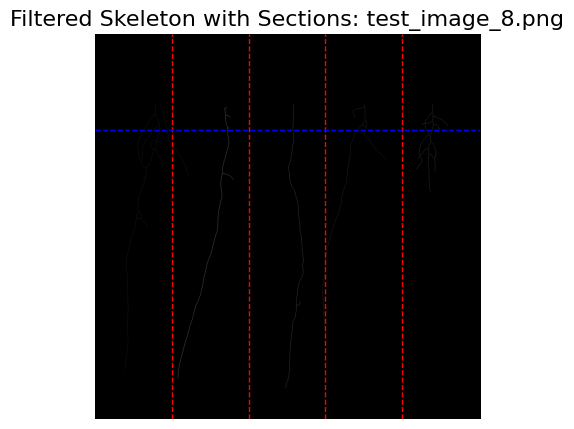

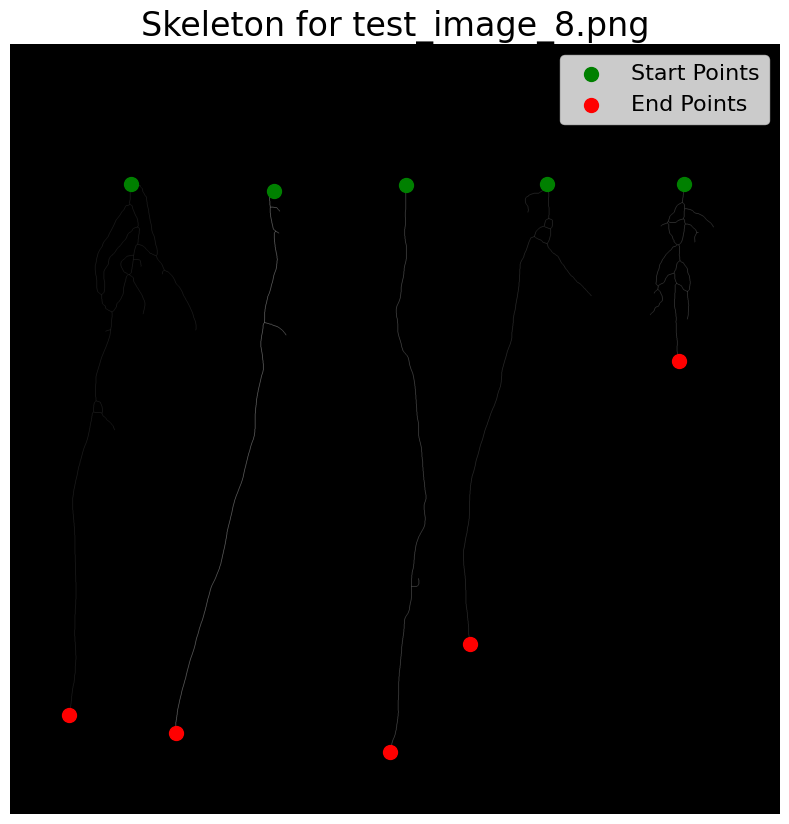

Processing test_image_9.png...


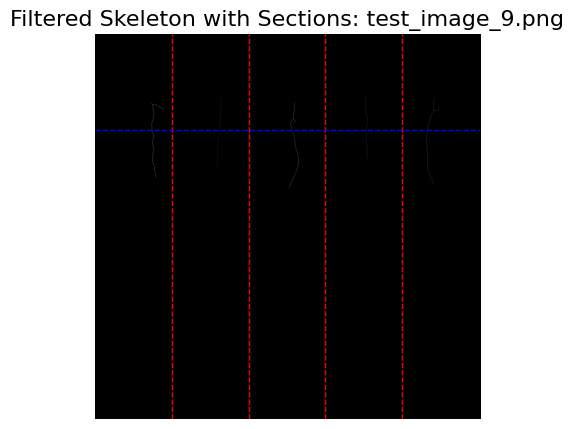

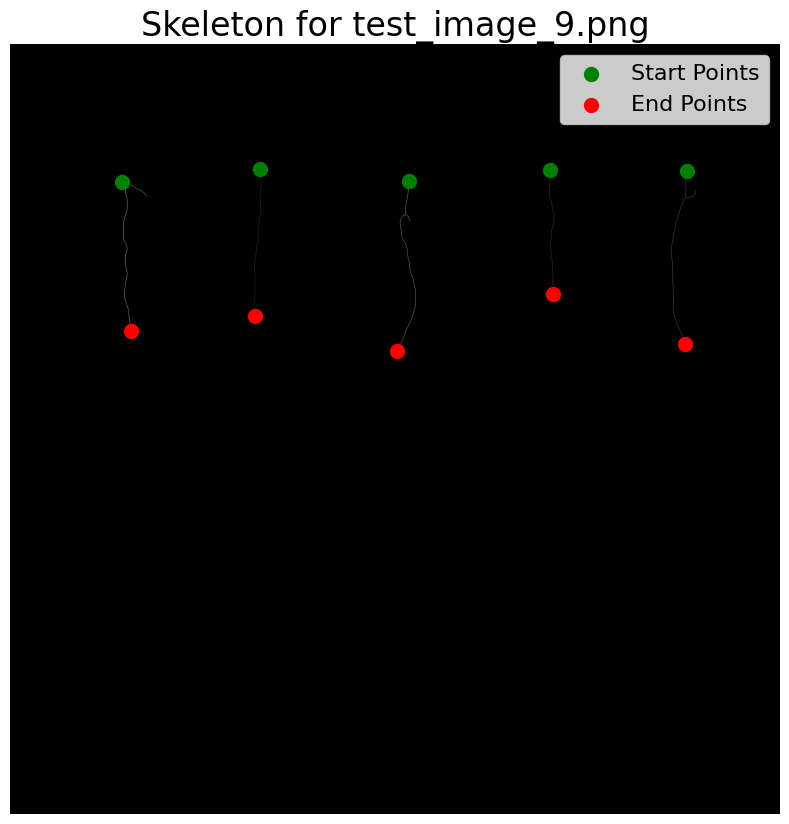

    skeleton-id           filename  start_y  start_x   end_y   end_x  \
0             0   test_image_1.png    475.0   1406.0   722.0  1437.0   
1             1   test_image_1.png    480.0    449.0   999.0   470.0   
2             2   test_image_1.png    575.0    572.0   640.0   563.0   
3             0  test_image_10.png    533.0   1932.0  1767.0  2015.0   
4             1  test_image_10.png    568.0   2456.0  1616.0  2535.0   
..          ...                ...      ...      ...     ...     ...   
81            0   test_image_9.png    458.0    915.0   995.0   895.0   
82            1   test_image_9.png    460.0   1974.0   912.0  1985.0   
83            2   test_image_9.png    463.0   2477.0  1095.0  2467.0   
84            3   test_image_9.png    500.0   1458.0  1123.0  1413.0   
85            4   test_image_9.png    505.0    409.0  1050.0   443.0   

    path_length  
0    262.325902  
1    564.149278  
2     72.627417  
3   1313.700577  
4   1131.901587  
..          ...  
81   555.

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from skimage.morphology import skeletonize
from skan import Skeleton, summarize
import networkx as nx

# Process skeletonization and extract data for each binary connected component
all_start_end_data = []

for filename, binary_labels in processed_masks:
    print(f"Processing {filename}...")

    # Step 1: Skeletonize the binary mask
    skeleton_object = skeletonize(binary_labels > 0)

    # Step 2: Label connected components
    labeled_roots = label(skeleton_object)

    # Step 3: Define the horizontal line at the top 25% of the height
    top_limit_y = int(binary_labels.shape[0] * 0.25)

    # Step 4: Divide the image into 5 vertical sections and retain the largest component in the top part of each sector
    section_width = binary_labels.shape[1] // 5
    filtered_roots = np.zeros_like(labeled_roots)

    for sector_id in range(5):
        x_start = sector_id * section_width
        x_end = (sector_id + 1) * section_width if sector_id < 4 else binary_labels.shape[1]

        # Get the components in the top 25% of the sector
        sector_mask_top = labeled_roots[:top_limit_y, x_start:x_end]
        sector_labels_top = np.unique(sector_mask_top[sector_mask_top > 0])  # Exclude background

        # Find the largest component in the top part of the sector
        max_area = 0
        largest_label_top = 0
        for label_id in sector_labels_top:
            area = np.sum(labeled_roots[:top_limit_y, :] == label_id)  # Count all pixels for the label in the top part
            if area > max_area:
                max_area = area
                largest_label_top = label_id

        # Retain the largest component in the top part of this sector
        if largest_label_top > 0:
            filtered_roots[labeled_roots == largest_label_top] = largest_label_top

    # Step 5: Plot filtered roots with sections and the horizontal line
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(filtered_roots, cmap="gray")

    # Draw vertical lines to indicate sections
    for i in range(1, 5):  # 4 lines divide into 5 sections
        x = i * section_width
        ax.axvline(x=x, color="red", linestyle="--", linewidth=1)

    # Draw the horizontal line at 35% of the height
    ax.axhline(y=top_limit_y, color="blue", linestyle="--", linewidth=1)

    ax.set_title(f"Filtered Skeleton with Sections: {filename}", fontsize=16)
    ax.axis("off")
    plt.show()

    # Step 6: Summarize the skeleton
    skeleton_data = Skeleton(filtered_roots)
    branch_data = summarize(skeleton_data)

    # Step 7: Create a NetworkX graph from the skeleton branch data
    G = nx.from_pandas_edgelist(
        branch_data, 
        source='node-id-src', 
        target='node-id-dst', 
        edge_attr='branch-distance'
    )

    # Step 8: Extract start and end points of the skeleton
    results = []
    for skeleton_id, group in branch_data.groupby("skeleton-id"):
        # Start point (minimum y-coordinate)
        start_branch = group.loc[group[["image-coord-src-0", "image-coord-dst-0"]].min(axis=1).idxmin()]
        start_y = start_branch[["image-coord-src-0", "image-coord-dst-0"]].min()
        start_x = start_branch[["image-coord-src-1", "image-coord-dst-1"]].iloc[start_branch[["image-coord-src-0", "image-coord-dst-0"]].argmin()]

        # End point (maximum y-coordinate)
        end_branch = group.loc[group[["image-coord-src-0", "image-coord-dst-0"]].max(axis=1).idxmax()]
        end_y = end_branch[["image-coord-src-0", "image-coord-dst-0"]].max()
        end_x = end_branch[["image-coord-src-1", "image-coord-dst-1"]].iloc[end_branch[["image-coord-src-0", "image-coord-dst-0"]].argmax()]

        results.append({
            "skeleton-id": skeleton_id,
            "filename": filename,
            "start_y": start_y,
            "start_x": start_x,
            "end_y": end_y,
            "end_x": end_x
        })

    # Convert results to a DataFrame
    start_end_df = pd.DataFrame(results)

    # Step 9: Map coordinates to nodes and compute shortest paths
    coordinate_to_node = {}
    for _, row in branch_data.iterrows():
        coordinate_to_node[(row['image-coord-src-0'], row['image-coord-src-1'])] = row['node-id-src']
        coordinate_to_node[(row['image-coord-dst-0'], row['image-coord-dst-1'])] = row['node-id-dst']

    path_lengths = []
    for _, row in start_end_df.iterrows():
        src_node = coordinate_to_node.get((row['start_y'], row['start_x']), None)
        dst_node = coordinate_to_node.get((row['end_y'], row['end_x']), None)

        if src_node is not None and dst_node is not None and src_node in G.nodes and dst_node in G.nodes:
            try:
                path_len = nx.dijkstra_path_length(G, src_node, dst_node, weight='branch-distance')
                path_lengths.append(path_len)
            except nx.NetworkXNoPath:
                path_lengths.append(None)
        else:
            path_lengths.append(None)

    start_end_df['path_length'] = path_lengths
    all_start_end_data.append(start_end_df)

    # Visualize skeleton with start and end points
    plt.figure(figsize=(15, 10))
    plt.title(f"Skeleton for {filename}", fontsize=24)
    plt.imshow(filtered_roots, cmap='gray')  # Updated to display filtered_roots
    plt.scatter(start_end_df["start_x"], start_end_df["start_y"], color='green', label='Start Points', s=100)
    plt.scatter(start_end_df["end_x"], start_end_df["end_y"], color='red', label='End Points', s=100)
    plt.legend(fontsize=16)
    plt.axis("off")
    plt.show()

# Combine all results into a single DataFrame
final_data = pd.concat(all_start_end_data, ignore_index=True)

# Display the final results
print(final_data)


In [54]:
# Filter the data to get the rows where filename is "test_image_8.png"
f = final_data[final_data["filename"] == "test_image_8.png"]

# Check if the filtered DataFrame is not empty
if not f.empty:
    # Get all unique start_y values
    unique_start_y = f["start_y"].unique()

    # Get all skeleton IDs
    skeleton_ids = f["skeleton-id"].unique()

    print("Unique start_y values:")
    print(unique_start_y)
    print("\nAll skeleton IDs:")
    print(skeleton_ids)
else:
    print("No data found for filename 'test_image_8.png'")

Unique start_y values:
[513. 516. 536.]

All skeleton IDs:
[0 1 2 3 4]


In [55]:
f["path_length"]

76    2093.447835
77    1837.376767
78     701.948268
79    2198.678282
80    2178.839754
Name: path_length, dtype: float64

In [22]:
final_data.head()

skeleton-id           filename  start_y  start_x   end_y   end_x  \
0            0   test_image_1.png    475.0   1406.0   722.0  1437.0   
1            1   test_image_1.png    480.0    449.0   999.0   470.0   
2            2   test_image_1.png    575.0    572.0   640.0   563.0   
3            0  test_image_10.png    533.0   1932.0  1767.0  2015.0   
4            1  test_image_10.png    568.0   2456.0  1616.0  2535.0   

   path_length  
0   262.325902  
1   564.149278  
2    72.627417  
3  1313.700577  
4  1131.901587

In [23]:
import numpy as np
import pandas as pd

# Initialize results
results = []

# Define the number of sectors (5) and calculate sector boundaries
num_sectors = 5
image_width = final_data["start_x"].max() + 1  # Assuming start_x represents horizontal pixel positions
sector_width = image_width // num_sectors

# Group by filename and process each group
for filename, group in final_data.groupby("filename"):
    # Create an array to store lengths for each sector
    sector_lengths = [0] * num_sectors

    # Assign roots to sectors based on their start_x position
    for _, row in group.iterrows():
        sector_index = int(row["start_x"] // sector_width)  # Determine the sector based on start_x
        sector_index = min(sector_index, num_sectors - 1)  # Ensure it's within bounds (sector 0 to 4)
        path_length = round(row["path_length"])
        sector_lengths[sector_index] = path_length  # Store the length for the corresponding sector

    # Add results for each sector (plant ID 1 to 5)
    for plant_id in range(1, num_sectors + 1):
        results.append([f"{filename[:-4]}_plant_{plant_id}", sector_lengths[plant_id - 1]])

# Convert results to DataFrame for submission
submission_df = pd.DataFrame(results, columns=["Plant ID","Length (px)"])

# Save to CSV
submission_df.to_csv("submission_8.csv", index=False, header=False)

# Print a preview of the submission file
print(submission_df.head())


               Plant ID  Length (px)
0  test_image_1_plant_1          564
1  test_image_1_plant_2           73
2  test_image_1_plant_3          262
3  test_image_1_plant_4            0
4  test_image_1_plant_5            0
